In [2]:
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import sys

In [3]:
def encode_lable(y, num_classes):
    y_gt = np.zeros((len(y), num_classes))
    for i in range(0, len(y)):
        y_gt[i, y[i]] = 1
    return y_gt

In [19]:
def h(theta, X):
    return 1.0 / (1 + np.exp(-np.dot(X, theta)))

In [5]:
def sigm_derivative(theta, X):
    return h(theta, X) * (1 - h(theta, X))

In [6]:
def loss(y_gt, y_pred):
    cross_entropy_error = 0.0
    for i in range(0, len(y_gt)):
        for j in range(0, len(y_gt[i])):
            cross_entropy_error -= (y_gt[i][j] * np.log(y_pred[i][j]) + (1 - y_gt[i][j]) * np.log(1 - y_pred[i][j]))
    return cross_entropy_error / len(y_gt)

In [7]:
def CEderivative(X, y_gt, y_pred):
    return np.dot(y_pred - y_gt, X) / len(y_gt)

In [8]:
def acc(y_test, y_out):
    accuracy = 0
    for i in range(len(y_out)):
        if np.argmax(y_test[i]) == np.argmax(y_out[i]):
            accuracy += 1
    return accuracy / len(y_test)

In [9]:
def RMSprob(Et_1, g, gamma, mu, e):
    Et = (gamma*Et_1) + (1-gamma)*(g**2)
    delta = (mu)/np.sqrt(Et + e)
    delta*=g
    return delta 

In [10]:
def forward(thetas, X, dropout_prob, train_test_check):
    num_layers = thetas.shape[0]
    outs = []
    for t in range(0, num_layers): #проходим по всем слоям (все слои с сигмоидальной функцией активации)
        if t == 0:
            outs.append(np.array([h(thetas[t][:, i], X) for i in range(0, thetas[t].shape[1])]).T)
        else:
            outs.append(np.array([h(thetas[t][:, i], np.asarray(outs[t-1])) for i in range(0, thetas[t].shape[1])]).T)
    #Dropout
    if train_test_check:
        for i in range(len(outs) - 1):#для всех слоев кроме выходного и входного
            for o in outs[i]:
                o *= np.random.binomial(1,dropout_prob,o.shape[0]) * (1) / (1 - dropout_prob)
    return [out for out in outs]

In [11]:
def backward(X, y_gt, thetas, dropout_prob):
    num_features = X.shape[1]
    num_classes = y_gt.shape[1]
    outs = forward(thetas, X,dropout_prob, True)
    num_layers = len(outs)
    d_theta = []
    d_theta.append(np.zeros([num_features, outs[0].shape[1]]))
    for i in range(0, num_layers - 1):
        d_theta.append(np.zeros([outs[i].shape[1], outs[i+1].shape[1]]))
    tmp_th = None
    #скрытые слои
    for i in range(len(outs) - 1, -1, -1):
        if i == len(outs) - 1:#выходной слой
            for class_no in range(0, num_classes):
                d_theta[i][:, class_no] = CEderivative(outs[i-1], y_gt[:, class_no], outs[i][:, class_no])
            tmp_th = outs[i] - y_gt
        elif i == 0:#первый скрытый
            tmp_th = np.dot(tmp_th, thetas[1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[0], X)
            d_theta[0] = np.dot(X.T, tmp_th)
            d_theta[0] = d_theta[0]/outs[0].shape[0]
        else:# остальные скрытые
            tmp_th = np.dot(tmp_th, thetas[i+1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[i], outs[i-1])
            d_theta[i] = np.dot(outs[i-1].T, tmp_th)
            d_theta[i] = d_theta[i]/outs[i].shape[0]
    return d_theta

In [12]:
(dx_train, dy_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 228s 1us/step


In [13]:
print('x_train shape:', dx_train.shape)
print(dx_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [14]:
dy_train = encode_lable(dy_train, 10)
y_test = encode_lable(y_test, 10)

In [15]:
dx_train = np.asarray([list(x.flat) for x in dx_train])
x_test = np.asarray([list(x.flat) for x in x_test])

In [16]:
p = np.random.permutation(dx_train.shape[0])
x_train = dx_train[p[0:int(len(dx_train)*0.8)], :]
y_train = dy_train[p[0:int(len(dx_train)*0.8)]]
x_val = dx_train[p[int(len(dx_train)*0.8):], :]
y_val = dy_train[p[int(len(dx_train)*0.8):]]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (40000, 3072)
y_train shape: (40000, 10)
x_val shape: (10000, 3072)
y_val shape: (10000, 10)
x_test shape: (10000, 3072)
y_test shape: (10000, 10)


In [17]:
x_train = (x_train - np.mean(x_train, axis = 0)) / np.var(x_train, axis = 0)
x_val = (x_val - np.mean(x_val, axis = 0)) / np.var(x_val, axis = 0)
x_test = (x_test - np.mean(x_test, axis = 0)) / np.var(x_test, axis = 0)

Initial loss : 17.04483905369733


Epoch 0/2000 ...........
Loss train: 3.205399127163887 
Loss val: 3.214130661580145 
Train accuracy :  0.181475 
Validation accuracy :  0.1829
Alpha:  4


Epoch 1/2000 ...........
Loss train: 3.090416155782336 
Loss val: 3.0898157106005284 
Train accuracy :  0.206075 
Validation accuracy :  0.2085
Alpha:  3.98


Epoch 2/2000 ...........
Loss train: 3.0013110319357357 
Loss val: 3.008178490227776 
Train accuracy :  0.244525 
Validation accuracy :  0.2476
Alpha:  3.9601


Epoch 3/2000 ...........
Loss train: 2.975207350302549 
Loss val: 2.9833883771291827 
Train accuracy :  0.25645 
Validation accuracy :  0.253
Alpha:  3.9402995


Epoch 4/2000 ...........
Loss train: 2.969164530875789 
Loss val: 2.9819446888249996 
Train accuracy :  0.2751 
Validation accuracy :  0.2695
Alpha:  3.9205980025000002


Epoch 5/2000 ...........
Loss train: 2.8735019859906727 
Loss val: 2.8848054367405958 
Train accuracy :  0.286175 
Validation accuracy :  0.2817
Alpha:  3.90

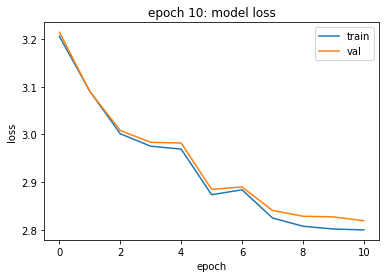

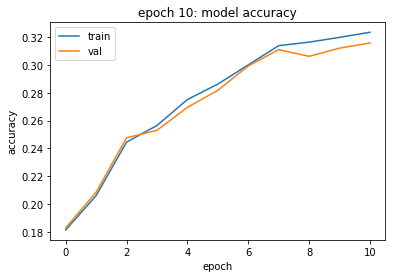



Epoch 11/2000 ...........
Loss train: 2.7634630405561187 
Loss val: 2.7796669884577665 
Train accuracy :  0.3365 
Validation accuracy :  0.3271
Alpha:  3.785418319253772


Epoch 12/2000 ...........
Loss train: 2.7554786059524794 
Loss val: 2.7787345070604346 
Train accuracy :  0.3361 
Validation accuracy :  0.3314
Alpha:  3.766491227657503


Epoch 13/2000 ...........
Loss train: 2.7744149619655647 
Loss val: 2.8023092037471664 
Train accuracy :  0.337525 
Validation accuracy :  0.3282
Alpha:  3.7476587715192156


Epoch 14/2000 ...........
Loss train: 2.731331155273838 
Loss val: 2.7544255236101263 
Train accuracy :  0.344025 
Validation accuracy :  0.3344
Alpha:  3.7289204776616196


Epoch 15/2000 ...........
Loss train: 2.7250962089760757 
Loss val: 2.7423125840568874 
Train accuracy :  0.3468 
Validation accuracy :  0.3415
Alpha:  3.7102758752733114


Epoch 16/2000 ...........
Loss train: 2.720992975164271 
Loss val: 2.742113414856049 
Train accuracy :  0.34685 
Validation accuracy

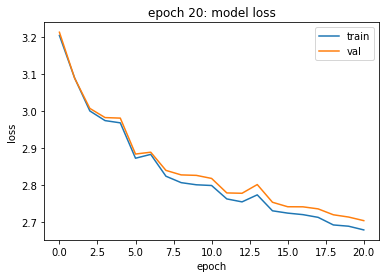

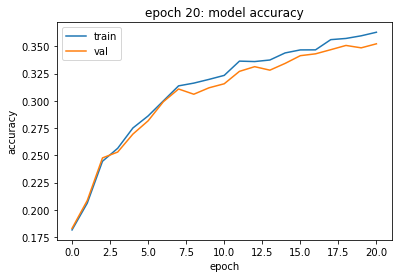



Epoch 21/2000 ...........
Loss train: 2.6696272301855792 
Loss val: 2.696192465020761 
Train accuracy :  0.367175 
Validation accuracy :  0.3546
Alpha:  3.600349711492978


Epoch 22/2000 ...........
Loss train: 2.658737111334142 
Loss val: 2.6819589945475704 
Train accuracy :  0.368925 
Validation accuracy :  0.3599
Alpha:  3.582347962935513


Epoch 23/2000 ...........
Loss train: 2.6580761645288424 
Loss val: 2.6871620081243184 
Train accuracy :  0.3684 
Validation accuracy :  0.3553
Alpha:  3.5644362231208353


Epoch 24/2000 ...........
Loss train: 2.6393900680193636 
Loss val: 2.669246848901256 
Train accuracy :  0.3755 
Validation accuracy :  0.3626
Alpha:  3.5466140420052312


Epoch 25/2000 ...........
Loss train: 2.6470933618567 
Loss val: 2.675758248697007 
Train accuracy :  0.3704 
Validation accuracy :  0.3575
Alpha:  3.528880971795205


Epoch 26/2000 ...........
Loss train: 2.648684220737718 
Loss val: 2.6797878165478126 
Train accuracy :  0.369475 
Validation accuracy :  0

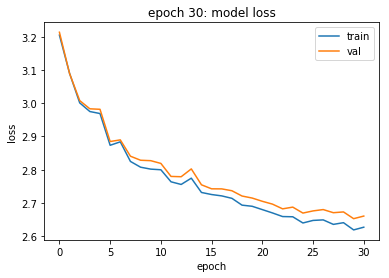

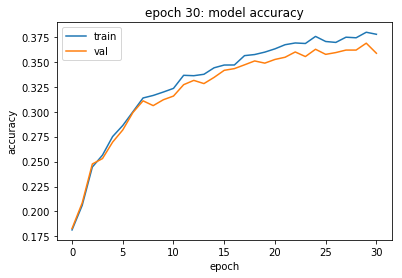



Epoch 31/2000 ...........
Loss train: 2.618637300447831 
Loss val: 2.651113485480214 
Train accuracy :  0.38415 
Validation accuracy :  0.3745
Alpha:  3.4243290838204907


Epoch 32/2000 ...........
Loss train: 2.6196766050823093 
Loss val: 2.6459860443407406 
Train accuracy :  0.3824 
Validation accuracy :  0.3735
Alpha:  3.407207438401388


Epoch 33/2000 ...........
Loss train: 2.613044672209089 
Loss val: 2.6450720111799595 
Train accuracy :  0.38455 
Validation accuracy :  0.3773
Alpha:  3.3901714012093813


Epoch 34/2000 ...........
Loss train: 2.6251213234742186 
Loss val: 2.666760920854514 
Train accuracy :  0.376675 
Validation accuracy :  0.3646
Alpha:  3.3732205442033343


Epoch 35/2000 ...........
Loss train: 2.602575680515646 
Loss val: 2.636067431410621 
Train accuracy :  0.3848 
Validation accuracy :  0.3783
Alpha:  3.3563544414823174


Epoch 36/2000 ...........
Loss train: 2.6033195676780094 
Loss val: 2.6397736457558194 
Train accuracy :  0.385775 
Validation accuracy 

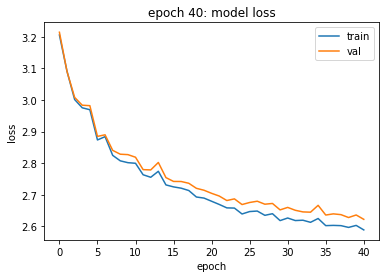

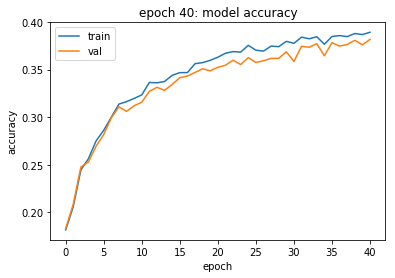



Epoch 41/2000 ...........
Loss train: 2.590155252075401 
Loss val: 2.6215975851076734 
Train accuracy :  0.391525 
Validation accuracy :  0.378
Alpha:  3.2569140816702435


Epoch 42/2000 ...........
Loss train: 2.589334326994651 
Loss val: 2.6235232665232915 
Train accuracy :  0.393875 
Validation accuracy :  0.3895
Alpha:  3.240629511261892


Epoch 43/2000 ...........
Loss train: 2.574233548260216 
Loss val: 2.610621731467539 
Train accuracy :  0.39845 
Validation accuracy :  0.3842
Alpha:  3.2244263637055828


Epoch 44/2000 ...........
Loss train: 2.5864540736202826 
Loss val: 2.626077982284478 
Train accuracy :  0.397225 
Validation accuracy :  0.3838
Alpha:  3.208304231887055


Epoch 45/2000 ...........
Loss train: 2.565344960302219 
Loss val: 2.602811361417482 
Train accuracy :  0.3983 
Validation accuracy :  0.3884
Alpha:  3.19226271072762


Epoch 46/2000 ...........
Loss train: 2.5658100095629752 
Loss val: 2.601363448439305 
Train accuracy :  0.398225 
Validation accuracy :  

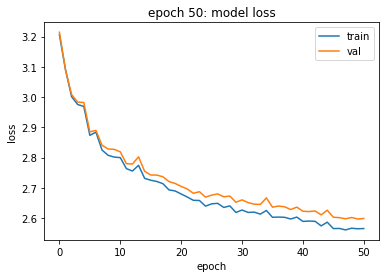

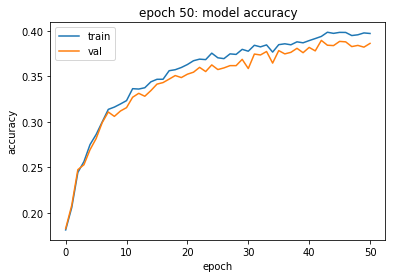



Epoch 51/2000 ...........
Loss train: 2.563548027502041 
Loss val: 2.594456937928109 
Train accuracy :  0.398425 
Validation accuracy :  0.3868
Alpha:  3.097683977133195


Epoch 52/2000 ...........
Loss train: 2.5531423621921188 
Loss val: 2.587072118816678 
Train accuracy :  0.400975 
Validation accuracy :  0.39
Alpha:  3.082195557247529


Epoch 53/2000 ...........
Loss train: 2.549417350370767 
Loss val: 2.5822599640291974 
Train accuracy :  0.40535 
Validation accuracy :  0.3946
Alpha:  3.0667845794612916


Epoch 54/2000 ...........
Loss train: 2.551987305557416 
Loss val: 2.5882540142642165 
Train accuracy :  0.4034 
Validation accuracy :  0.3926
Alpha:  3.051450656563985


Epoch 55/2000 ...........
Loss train: 2.547652077575829 
Loss val: 2.5849286586899205 
Train accuracy :  0.405475 
Validation accuracy :  0.3929
Alpha:  3.036193403281165


Epoch 56/2000 ...........
Loss train: 2.5458228827285954 
Loss val: 2.583231402078437 
Train accuracy :  0.405975 
Validation accuracy :  

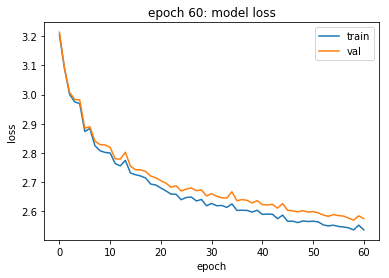

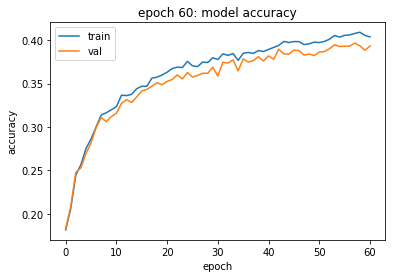



Epoch 61/2000 ...........
Loss train: 2.532750238190978 
Loss val: 2.5764972048689145 
Train accuracy :  0.40715 
Validation accuracy :  0.3909
Alpha:  2.946238611632884


Epoch 62/2000 ...........
Loss train: 2.5388631799911843 
Loss val: 2.582224419533985 
Train accuracy :  0.4034 
Validation accuracy :  0.3878
Alpha:  2.9315074185747196


Epoch 63/2000 ...........
Loss train: 2.5261629070610345 
Loss val: 2.571930138701138 
Train accuracy :  0.409825 
Validation accuracy :  0.3938
Alpha:  2.916849881481846


Epoch 64/2000 ...........
Loss train: 2.534390329863739 
Loss val: 2.580231210964703 
Train accuracy :  0.4079 
Validation accuracy :  0.3902
Alpha:  2.902265632074437


Epoch 65/2000 ...........
Loss train: 2.534217155679044 
Loss val: 2.582549344406193 
Train accuracy :  0.406425 
Validation accuracy :  0.3862
Alpha:  2.8877543039140647


Epoch 66/2000 ...........
Loss train: 2.5335669998222454 
Loss val: 2.583740548990573 
Train accuracy :  0.405675 
Validation accuracy :  

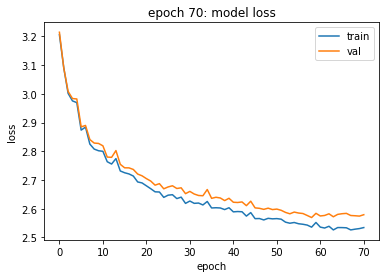

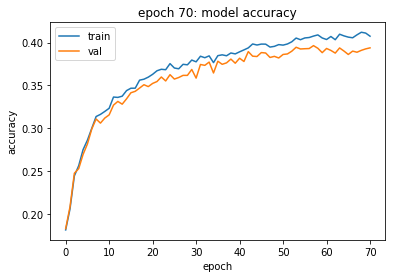



Epoch 71/2000 ...........
Loss train: 2.5212659328864926 
Loss val: 2.5692766694465132 
Train accuracy :  0.4142 
Validation accuracy :  0.3987
Alpha:  2.802197390293447


Epoch 72/2000 ...........
Loss train: 2.5180737353462415 
Loss val: 2.5718207565964573 
Train accuracy :  0.414675 
Validation accuracy :  0.394
Alpha:  2.78818640334198


Epoch 73/2000 ...........
Loss train: 2.5120158760914806 
Loss val: 2.5667133521569516 
Train accuracy :  0.41365 
Validation accuracy :  0.3955
Alpha:  2.77424547132527


Epoch 74/2000 ...........
Loss train: 2.506843952074889 
Loss val: 2.5564842179409166 
Train accuracy :  0.41865 
Validation accuracy :  0.3987
Alpha:  2.7603742439686436


Epoch 75/2000 ...........
Loss train: 2.5147294273660106 
Loss val: 2.568123603977623 
Train accuracy :  0.41435 
Validation accuracy :  0.3944
Alpha:  2.7465723727488003


Epoch 76/2000 ...........
Loss train: 2.5208683987645686 
Loss val: 2.576480594874834 
Train accuracy :  0.41225 
Validation accuracy : 

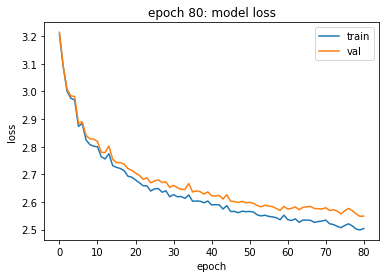

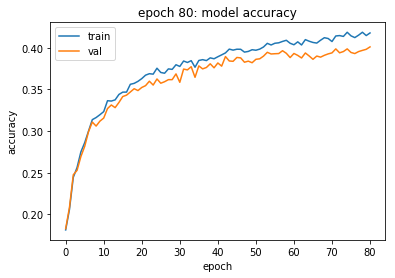



Epoch 81/2000 ...........
Loss train: 2.4954902290227197 
Loss val: 2.546164939889275 
Train accuracy :  0.420125 
Validation accuracy :  0.4025
Alpha:  2.665198325472846


Epoch 82/2000 ...........
Loss train: 2.49124509858394 
Loss val: 2.543194049954491 
Train accuracy :  0.42155 
Validation accuracy :  0.405
Alpha:  2.651872333845482


Epoch 83/2000 ...........
Loss train: 2.490624962263419 
Loss val: 2.5414616478660204 
Train accuracy :  0.424525 
Validation accuracy :  0.4034
Alpha:  2.6386129721762543


Epoch 84/2000 ...........
Loss train: 2.4914559126882314 
Loss val: 2.5482328284397853 
Train accuracy :  0.421625 
Validation accuracy :  0.4031
Alpha:  2.625419907315373


Epoch 85/2000 ...........
Loss train: 2.4921952507485288 
Loss val: 2.544515333634088 
Train accuracy :  0.42015 
Validation accuracy :  0.3989
Alpha:  2.612292807778796


Epoch 86/2000 ...........
Loss train: 2.4952986051910386 
Loss val: 2.5486710346182946 
Train accuracy :  0.420275 
Validation accuracy 

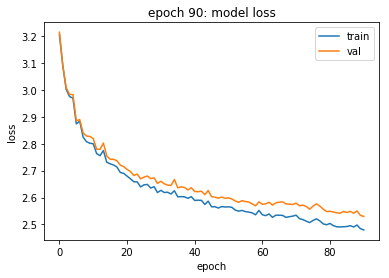

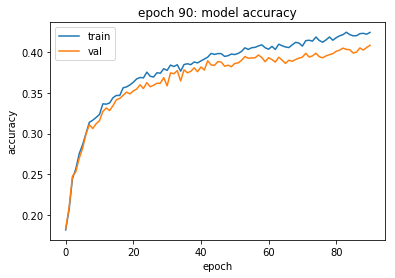



Epoch 91/2000 ...........
Loss train: 2.4823114167397673 
Loss val: 2.5289879067623957 
Train accuracy :  0.4236 
Validation accuracy :  0.4058
Alpha:  2.5348971270576346


Epoch 92/2000 ...........
Loss train: 2.485952980506444 
Loss val: 2.533225005700109 
Train accuracy :  0.4234 
Validation accuracy :  0.4038
Alpha:  2.5222226414223465


Epoch 93/2000 ...........
Loss train: 2.4787327055945796 
Loss val: 2.5255838979280325 
Train accuracy :  0.42415 
Validation accuracy :  0.4079
Alpha:  2.5096115282152347


Epoch 94/2000 ...........
Loss train: 2.47989772081188 
Loss val: 2.5319192572285294 
Train accuracy :  0.42565 
Validation accuracy :  0.4068
Alpha:  2.4970634705741586


Epoch 95/2000 ...........
Loss train: 2.4838080810869725 
Loss val: 2.5374266037171713 
Train accuracy :  0.42295 
Validation accuracy :  0.4061
Alpha:  2.4845781532212876


Epoch 96/2000 ...........
Loss train: 2.4775967473843714 
Loss val: 2.531886164354739 
Train accuracy :  0.426225 
Validation accuracy

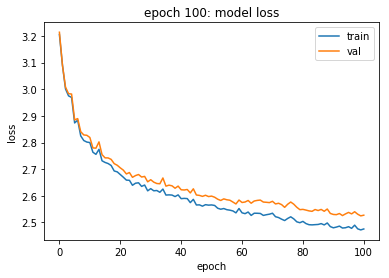

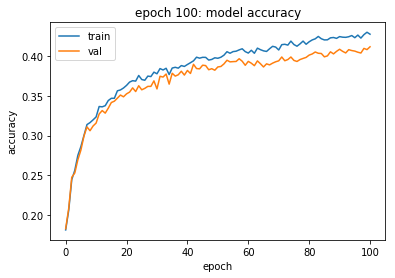



Epoch 101/2000 ...........
Loss train: 2.4733573821076664 
Loss val: 2.525543172864818 
Train accuracy :  0.427975 
Validation accuracy :  0.4078
Alpha:  2.4109663372330967


Epoch 102/2000 ...........
Loss train: 2.482142390955121 
Loss val: 2.5373424891083904 
Train accuracy :  0.4231 
Validation accuracy :  0.403
Alpha:  2.3989115055469314


Epoch 103/2000 ...........
Loss train: 2.4736622454756225 
Loss val: 2.5278837360637025 
Train accuracy :  0.42765 
Validation accuracy :  0.4076
Alpha:  2.3869169480191967


Epoch 104/2000 ...........
Loss train: 2.473204873190288 
Loss val: 2.5313011802138456 
Train accuracy :  0.425075 
Validation accuracy :  0.4028
Alpha:  2.3749823632791007


Epoch 105/2000 ...........
Loss train: 2.4679975279040627 
Loss val: 2.524747845467554 
Train accuracy :  0.4279 
Validation accuracy :  0.4081
Alpha:  2.3631074514627053


Epoch 106/2000 ...........
Loss train: 2.459963854436622 
Loss val: 2.5221082643001593 
Train accuracy :  0.42895 
Validation ac

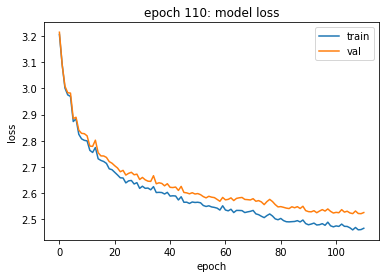

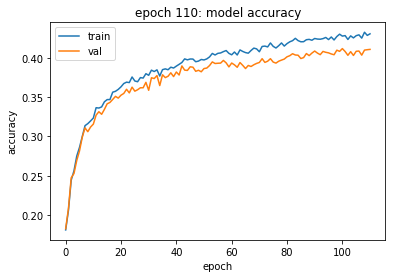



Epoch 111/2000 ...........
Loss train: 2.4656631377535705 
Loss val: 2.5271022336865654 
Train accuracy :  0.4302 
Validation accuracy :  0.4088
Alpha:  2.293094507554355


Epoch 112/2000 ...........
Loss train: 2.461743108903666 
Loss val: 2.5210539748315646 
Train accuracy :  0.4303 
Validation accuracy :  0.4084
Alpha:  2.281629035016583


Epoch 113/2000 ...........
Loss train: 2.461277127908526 
Loss val: 2.5226334549216722 
Train accuracy :  0.429675 
Validation accuracy :  0.4108
Alpha:  2.2702208898415


Epoch 114/2000 ...........
Loss train: 2.4643247243518576 
Loss val: 2.5234150507610393 
Train accuracy :  0.427175 
Validation accuracy :  0.4067
Alpha:  2.2588697853922928


Epoch 115/2000 ...........
Loss train: 2.4570803104106633 
Loss val: 2.51553966444488 
Train accuracy :  0.431125 
Validation accuracy :  0.4089
Alpha:  2.2475754364653313


Epoch 116/2000 ...........
Loss train: 2.4555499517014012 
Loss val: 2.5173998595490255 
Train accuracy :  0.430925 
Validation acc

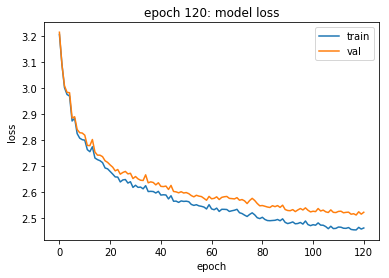

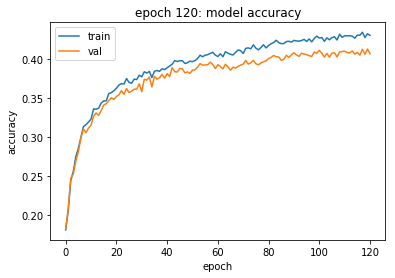



Epoch 121/2000 ...........
Loss train: 2.4496732304486413 
Loss val: 2.5043354186137194 
Train accuracy :  0.433675 
Validation accuracy :  0.411
Alpha:  2.1809854162503672


Epoch 122/2000 ...........
Loss train: 2.4479543884694213 
Loss val: 2.508294006590431 
Train accuracy :  0.43585 
Validation accuracy :  0.411
Alpha:  2.1700804891691154


Epoch 123/2000 ...........
Loss train: 2.4482168150805683 
Loss val: 2.5091349653523194 
Train accuracy :  0.43505 
Validation accuracy :  0.4054
Alpha:  2.15923008672327


Epoch 124/2000 ...........
Loss train: 2.4501292754636252 
Loss val: 2.5104731053050537 
Train accuracy :  0.431575 
Validation accuracy :  0.4113
Alpha:  2.1484339362896536


Epoch 125/2000 ...........
Loss train: 2.44820167920125 
Loss val: 2.506639270064623 
Train accuracy :  0.43355 
Validation accuracy :  0.4126
Alpha:  2.137691766608205


Epoch 126/2000 ...........
Loss train: 2.4439623781454256 
Loss val: 2.5077809802625373 
Train accuracy :  0.435375 
Validation ac

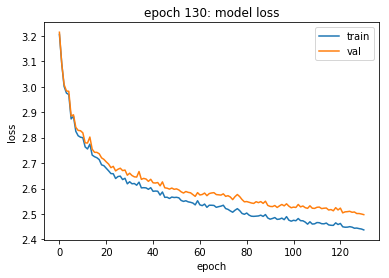

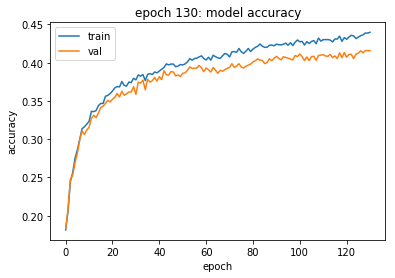



Epoch 131/2000 ...........
Loss train: 2.4417984107366615 
Loss val: 2.502881125778646 
Train accuracy :  0.43925 
Validation accuracy :  0.413
Alpha:  2.0743573237938326


Epoch 132/2000 ...........
Loss train: 2.4387061394912486 
Loss val: 2.4973976149630657 
Train accuracy :  0.44315 
Validation accuracy :  0.4149
Alpha:  2.0639855371748634


Epoch 133/2000 ...........
Loss train: 2.4343933339289885 
Loss val: 2.4925971718810573 
Train accuracy :  0.4403 
Validation accuracy :  0.4147
Alpha:  2.053665609488989


Epoch 134/2000 ...........
Loss train: 2.4338055948413375 
Loss val: 2.493335839118872 
Train accuracy :  0.4397 
Validation accuracy :  0.4163
Alpha:  2.043397281441544


Epoch 135/2000 ...........
Loss train: 2.4359898724880957 
Loss val: 2.4944161804144787 
Train accuracy :  0.443325 
Validation accuracy :  0.4186
Alpha:  2.0331802950343363


Epoch 136/2000 ...........
Loss train: 2.436711153738765 
Loss val: 2.4977728443264207 
Train accuracy :  0.440725 
Validation ac

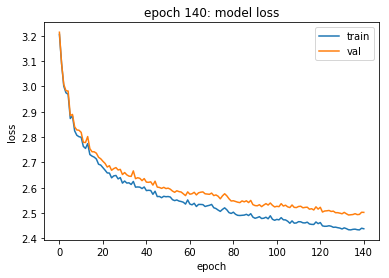

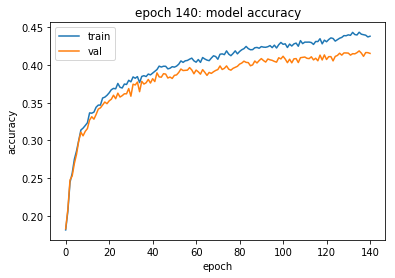



Epoch 141/2000 ...........
Loss train: 2.4309840288813924 
Loss val: 2.493754907875816 
Train accuracy :  0.44065 
Validation accuracy :  0.4163
Alpha:  1.9729422648661812


Epoch 142/2000 ...........
Loss train: 2.4326362300735607 
Loss val: 2.4955265369435744 
Train accuracy :  0.4406 
Validation accuracy :  0.4165
Alpha:  1.9630775535418503


Epoch 143/2000 ...........
Loss train: 2.4352093106632786 
Loss val: 2.49703198637523 
Train accuracy :  0.44195 
Validation accuracy :  0.4146
Alpha:  1.9532621657741411


Epoch 144/2000 ...........
Loss train: 2.44309101935362 
Loss val: 2.505164141939426 
Train accuracy :  0.436025 
Validation accuracy :  0.4146
Alpha:  1.9434958549452703


Epoch 145/2000 ...........
Loss train: 2.435707286986854 
Loss val: 2.495833238607953 
Train accuracy :  0.43905 
Validation accuracy :  0.4159
Alpha:  1.933778375670544


Epoch 146/2000 ...........
Loss train: 2.4276603831933525 
Loss val: 2.4933152744838094 
Train accuracy :  0.441875 
Validation accu

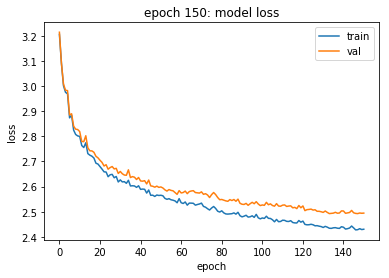

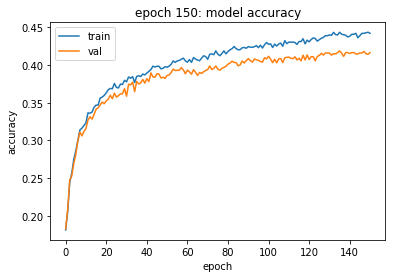



Epoch 151/2000 ...........
Loss train: 2.433857317060718 
Loss val: 2.5035926144372667 
Train accuracy :  0.441175 
Validation accuracy :  0.4158
Alpha:  1.876485374938309


Epoch 152/2000 ...........
Loss train: 2.4243896978164403 
Loss val: 2.4937102388543515 
Train accuracy :  0.4448 
Validation accuracy :  0.4201
Alpha:  1.8671029480636174


Epoch 153/2000 ...........
Loss train: 2.4280548836453875 
Loss val: 2.4974172814756534 
Train accuracy :  0.440575 
Validation accuracy :  0.4149
Alpha:  1.8577674333232994


Epoch 154/2000 ...........
Loss train: 2.4221298483975335 
Loss val: 2.4908453227773086 
Train accuracy :  0.443375 
Validation accuracy :  0.419
Alpha:  1.848478596156683


Epoch 155/2000 ...........
Loss train: 2.4242009343818802 
Loss val: 2.4902077390227593 
Train accuracy :  0.4433 
Validation accuracy :  0.4214
Alpha:  1.8392362031758995


Epoch 156/2000 ...........
Loss train: 2.4227193066066572 
Loss val: 2.489298383552419 
Train accuracy :  0.44445 
Validation 

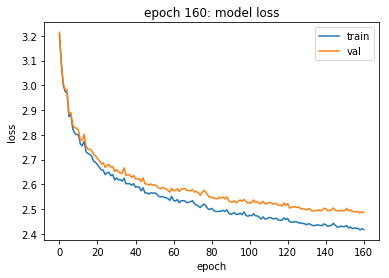

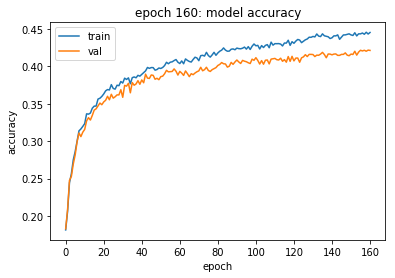



Epoch 161/2000 ...........
Loss train: 2.421182776891119 
Loss val: 2.488181848127023 
Train accuracy :  0.447775 
Validation accuracy :  0.4245
Alpha:  1.784744249774688


Epoch 162/2000 ...........
Loss train: 2.416456232517514 
Loss val: 2.4870690757435425 
Train accuracy :  0.445325 
Validation accuracy :  0.4209
Alpha:  1.7758205285258144


Epoch 163/2000 ...........
Loss train: 2.415057416748703 
Loss val: 2.4844313277163357 
Train accuracy :  0.449025 
Validation accuracy :  0.424
Alpha:  1.7669414258831853


Epoch 164/2000 ...........
Loss train: 2.41605489135157 
Loss val: 2.483370222902212 
Train accuracy :  0.445825 
Validation accuracy :  0.4222
Alpha:  1.7581067187537693


Epoch 165/2000 ...........
Loss train: 2.417678450610381 
Loss val: 2.486237395023116 
Train accuracy :  0.445875 
Validation accuracy :  0.4225
Alpha:  1.7493161851600005


Epoch 166/2000 ...........
Loss train: 2.4176065157521576 
Loss val: 2.4819011619068467 
Train accuracy :  0.444025 
Validation a

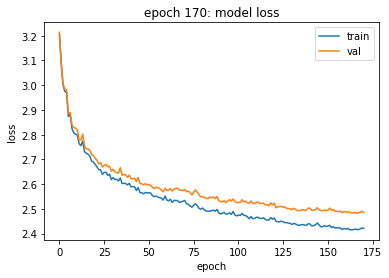

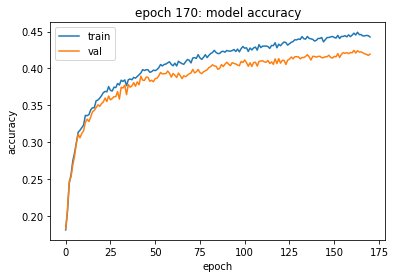



Epoch 171/2000 ...........
Loss train: 2.4144648493875707 
Loss val: 2.4797844610174007 
Train accuracy :  0.443725 
Validation accuracy :  0.4201
Alpha:  1.6974883362512394


Epoch 172/2000 ...........
Loss train: 2.4176464947363505 
Loss val: 2.4794157431805512 
Train accuracy :  0.4439 
Validation accuracy :  0.422
Alpha:  1.6890008945699833


Epoch 173/2000 ...........
Loss train: 2.4118323194158746 
Loss val: 2.478955627646786 
Train accuracy :  0.4465 
Validation accuracy :  0.4191
Alpha:  1.6805558900971334


Epoch 174/2000 ...........
Loss train: 2.4170257982163004 
Loss val: 2.4863489980983884 
Train accuracy :  0.443175 
Validation accuracy :  0.4157
Alpha:  1.6721531106466476


Epoch 175/2000 ...........
Loss train: 2.411514288208612 
Loss val: 2.4778994588766543 
Train accuracy :  0.44485 
Validation accuracy :  0.4212
Alpha:  1.6637923450934144


Epoch 176/2000 ...........
Loss train: 2.4120581576440534 
Loss val: 2.4786088127540795 
Train accuracy :  0.447425 
Validatio

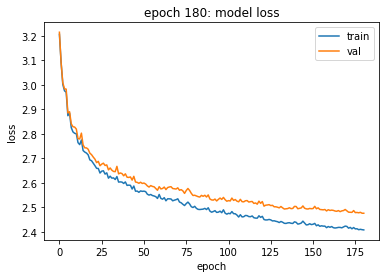

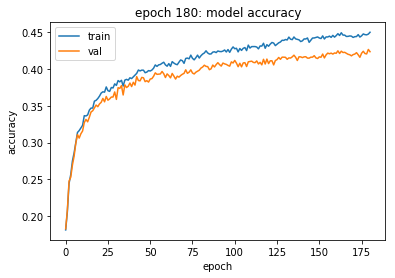



Epoch 181/2000 ...........
Loss train: 2.402300610946369 
Loss val: 2.4717841308902324 
Train accuracy :  0.450125 
Validation accuracy :  0.4235
Alpha:  1.6144983529560424


Epoch 182/2000 ...........
Loss train: 2.406667250915734 
Loss val: 2.4763602166168472 
Train accuracy :  0.44905 
Validation accuracy :  0.4202
Alpha:  1.606425861191262


Epoch 183/2000 ...........
Loss train: 2.4038321859547422 
Loss val: 2.4718559774276825 
Train accuracy :  0.4488 
Validation accuracy :  0.4228
Alpha:  1.5983937318853056


Epoch 184/2000 ...........
Loss train: 2.4016704475446304 
Loss val: 2.4697179831900655 
Train accuracy :  0.45 
Validation accuracy :  0.4218
Alpha:  1.5904017632258791


Epoch 185/2000 ...........
Loss train: 2.403640349591775 
Loss val: 2.4712247802200267 
Train accuracy :  0.452175 
Validation accuracy :  0.4234
Alpha:  1.5824497544097498


Epoch 186/2000 ...........
Loss train: 2.401482152723515 
Loss val: 2.4721077383371437 
Train accuracy :  0.452775 
Validation ac

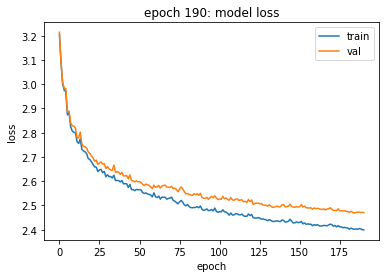

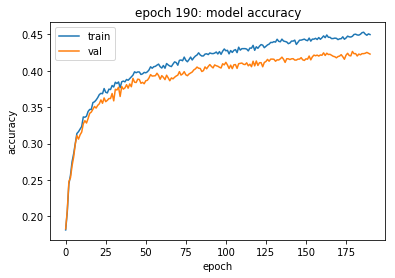



Epoch 191/2000 ...........
Loss train: 2.3973657716777788 
Loss val: 2.467214316561246 
Train accuracy :  0.455075 
Validation accuracy :  0.4272
Alpha:  1.5355657391167954


Epoch 192/2000 ...........
Loss train: 2.3977004904199726 
Loss val: 2.468377573884578 
Train accuracy :  0.45215 
Validation accuracy :  0.4245
Alpha:  1.5278879104212113


Epoch 193/2000 ...........
Loss train: 2.397679721471539 
Loss val: 2.468694689446583 
Train accuracy :  0.45035 
Validation accuracy :  0.4237
Alpha:  1.5202484708691053


Epoch 194/2000 ...........
Loss train: 2.395243693077927 
Loss val: 2.4640817165170272 
Train accuracy :  0.4529 
Validation accuracy :  0.4229
Alpha:  1.5126472285147599


Epoch 195/2000 ...........
Loss train: 2.394975147210928 
Loss val: 2.4656209798515922 
Train accuracy :  0.45165 
Validation accuracy :  0.4252
Alpha:  1.5050839923721862


Epoch 196/2000 ...........
Loss train: 2.39502552084021 
Loss val: 2.466469119180374 
Train accuracy :  0.452 
Validation accurac

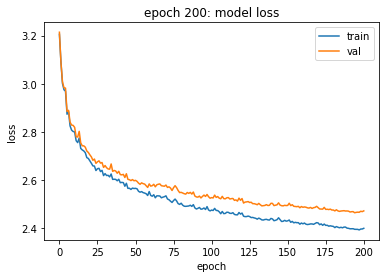

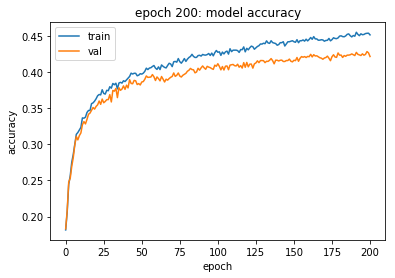



Epoch 201/2000 ...........
Loss train: 2.3941392080474997 
Loss val: 2.4672363877463135 
Train accuracy :  0.452925 
Validation accuracy :  0.4236
Alpha:  1.460492130470145


Epoch 202/2000 ...........
Loss train: 2.394832009090565 
Loss val: 2.467462475141976 
Train accuracy :  0.45455 
Validation accuracy :  0.4243
Alpha:  1.4531896698177944


Epoch 203/2000 ...........
Loss train: 2.388272738495999 
Loss val: 2.4635578706611536 
Train accuracy :  0.45555 
Validation accuracy :  0.4268
Alpha:  1.4459237214687055


Epoch 204/2000 ...........
Loss train: 2.3916919721808774 
Loss val: 2.4678512751006756 
Train accuracy :  0.453775 
Validation accuracy :  0.4241
Alpha:  1.438694102861362


Epoch 205/2000 ...........
Loss train: 2.3892910564197876 
Loss val: 2.463121263183939 
Train accuracy :  0.45375 
Validation accuracy :  0.4257
Alpha:  1.4315006323470552


Epoch 206/2000 ...........
Loss train: 2.395660588262946 
Loss val: 2.469632845658631 
Train accuracy :  0.45055 
Validation ac

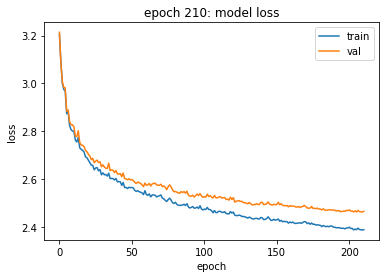

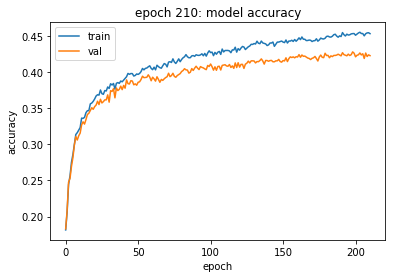



Epoch 211/2000 ...........
Loss train: 2.388823038156891 
Loss val: 2.466507176545405 
Train accuracy :  0.45435 
Validation accuracy :  0.4245
Alpha:  1.3890888607556928


Epoch 212/2000 ...........
Loss train: 2.3855325823888505 
Loss val: 2.4617180582814795 
Train accuracy :  0.45575 
Validation accuracy :  0.4239
Alpha:  1.3821434164519144


Epoch 213/2000 ...........
Loss train: 2.3876392330274174 
Loss val: 2.4624994827732256 
Train accuracy :  0.454775 
Validation accuracy :  0.4243
Alpha:  1.3752326993696549


Epoch 214/2000 ...........
Loss train: 2.3880506845821188 
Loss val: 2.4623816639168687 
Train accuracy :  0.453725 
Validation accuracy :  0.4267
Alpha:  1.3683565358728065


Epoch 215/2000 ...........
Loss train: 2.3879876564413656 
Loss val: 2.4628591873510515 
Train accuracy :  0.4538 
Validation accuracy :  0.4253
Alpha:  1.3615147531934424


Epoch 216/2000 ...........
Loss train: 2.38724423859039 
Loss val: 2.46301955286518 
Train accuracy :  0.453275 
Validation 

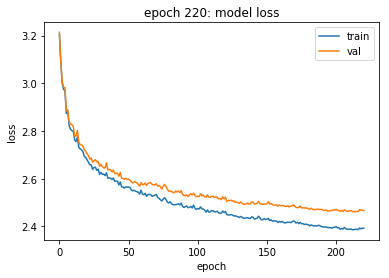

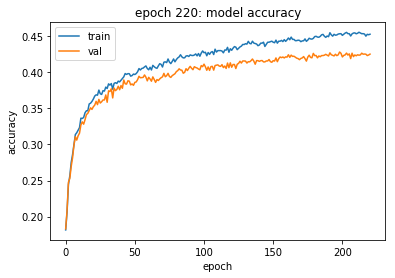



Epoch 221/2000 ...........
Loss train: 2.393374832598176 
Loss val: 2.4683535027384464 
Train accuracy :  0.451425 
Validation accuracy :  0.4253
Alpha:  1.3211764875818972


Epoch 222/2000 ...........
Loss train: 2.387588086067497 
Loss val: 2.463791238653137 
Train accuracy :  0.456525 
Validation accuracy :  0.4286
Alpha:  1.3145706051439878


Epoch 223/2000 ...........
Loss train: 2.3865599617542075 
Loss val: 2.459545111548951 
Train accuracy :  0.455975 
Validation accuracy :  0.4291
Alpha:  1.307997752118268


Epoch 224/2000 ...........
Loss train: 2.385606296866782 
Loss val: 2.4588396136361985 
Train accuracy :  0.455525 
Validation accuracy :  0.4274
Alpha:  1.3014577633576767


Epoch 225/2000 ...........
Loss train: 2.39147251711841 
Loss val: 2.464812116635068 
Train accuracy :  0.452025 
Validation accuracy :  0.4231
Alpha:  1.2949504745408884


Epoch 226/2000 ...........
Loss train: 2.3846737967528657 
Loss val: 2.459876360922093 
Train accuracy :  0.455025 
Validation 

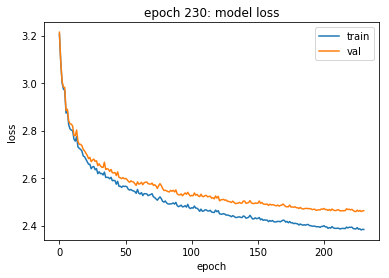

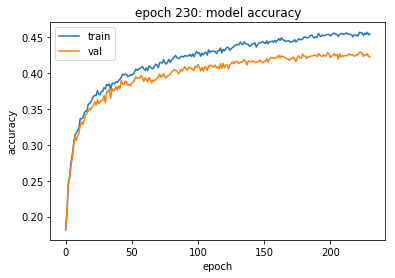



Epoch 231/2000 ...........
Loss train: 2.385187053119537 
Loss val: 2.4643345228940072 
Train accuracy :  0.454575 
Validation accuracy :  0.427
Alpha:  1.2565843414723288


Epoch 232/2000 ...........
Loss train: 2.3837739702326886 
Loss val: 2.4633655790127675 
Train accuracy :  0.4541 
Validation accuracy :  0.4238
Alpha:  1.2503014197649671


Epoch 233/2000 ...........
Loss train: 2.3832584921337197 
Loss val: 2.463953279759486 
Train accuracy :  0.455225 
Validation accuracy :  0.4217
Alpha:  1.2440499126661422


Epoch 234/2000 ...........
Loss train: 2.380746087354531 
Loss val: 2.462479333454602 
Train accuracy :  0.456425 
Validation accuracy :  0.4265
Alpha:  1.2378296631028114


Epoch 235/2000 ...........
Loss train: 2.3831903045728153 
Loss val: 2.4607576843800847 
Train accuracy :  0.457025 
Validation accuracy :  0.4288
Alpha:  1.2316405147872973


Epoch 236/2000 ...........
Loss train: 2.3854667077398473 
Loss val: 2.4650549444252996 
Train accuracy :  0.4536 
Validation

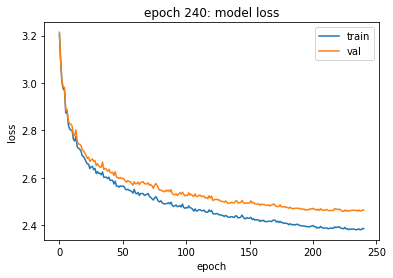

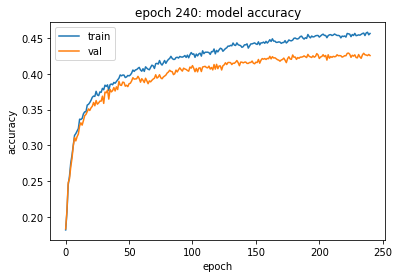



Epoch 241/2000 ...........
Loss train: 2.386225382568357 
Loss val: 2.464764999793025 
Train accuracy :  0.45505 
Validation accuracy :  0.425
Alpha:  1.1951500969589928


Epoch 242/2000 ...........
Loss train: 2.3870406445386103 
Loss val: 2.4709304986329723 
Train accuracy :  0.4556 
Validation accuracy :  0.4273
Alpha:  1.1891743464741977


Epoch 243/2000 ...........
Loss train: 2.3831151912994635 
Loss val: 2.46305342635595 
Train accuracy :  0.457 
Validation accuracy :  0.4269
Alpha:  1.1832284747418267


Epoch 244/2000 ...........
Loss train: 2.384609845274263 
Loss val: 2.4643608902398952 
Train accuracy :  0.456875 
Validation accuracy :  0.4261
Alpha:  1.1773123323681176


Epoch 245/2000 ...........
Loss train: 2.382026460711911 
Loss val: 2.460310704634124 
Train accuracy :  0.456925 
Validation accuracy :  0.4285
Alpha:  1.171425770706277


Epoch 246/2000 ...........
Loss train: 2.38026410977002 
Loss val: 2.4614404005074015 
Train accuracy :  0.45745 
Validation accuracy

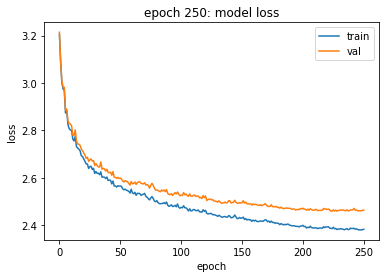

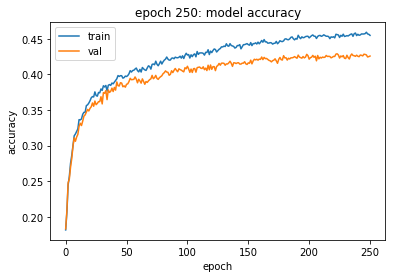



Epoch 251/2000 ...........
Loss train: 2.3818358313664687 
Loss val: 2.460274353181234 
Train accuracy :  0.45705 
Validation accuracy :  0.4263
Alpha:  1.1367193646448475


Epoch 252/2000 ...........
Loss train: 2.3819974696155946 
Loss val: 2.4613262946722347 
Train accuracy :  0.45745 
Validation accuracy :  0.4259
Alpha:  1.1310357678216232


Epoch 253/2000 ...........
Loss train: 2.3863687932318296 
Loss val: 2.4656441169326935 
Train accuracy :  0.45505 
Validation accuracy :  0.4262
Alpha:  1.125380588982515


Epoch 254/2000 ...........
Loss train: 2.3808415877203752 
Loss val: 2.4606701959019266 
Train accuracy :  0.4557 
Validation accuracy :  0.4261
Alpha:  1.1197536860376025


Epoch 255/2000 ...........
Loss train: 2.3814256154867546 
Loss val: 2.4621751419094355 
Train accuracy :  0.457225 
Validation accuracy :  0.4261
Alpha:  1.1141549176074146


Epoch 256/2000 ...........
Loss train: 2.375685841571134 
Loss val: 2.4565243376783346 
Train accuracy :  0.458425 
Validatio

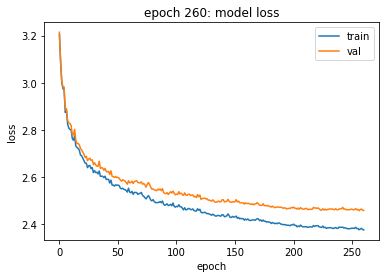

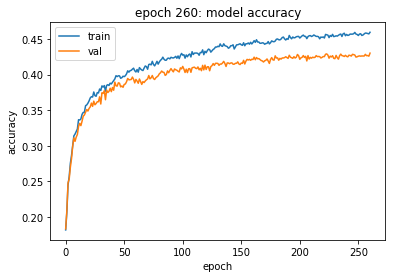



Epoch 261/2000 ...........
Loss train: 2.3736248769545694 
Loss val: 2.45429535159128 
Train accuracy :  0.458775 
Validation accuracy :  0.4278
Alpha:  1.08114530321033


Epoch 262/2000 ...........
Loss train: 2.373838108489046 
Loss val: 2.45510950645501 
Train accuracy :  0.458125 
Validation accuracy :  0.4293
Alpha:  1.0757395766942783


Epoch 263/2000 ...........
Loss train: 2.3744279992304795 
Loss val: 2.455887090328663 
Train accuracy :  0.4613 
Validation accuracy :  0.4289
Alpha:  1.070360878810807


Epoch 264/2000 ...........
Loss train: 2.3761261271993788 
Loss val: 2.4561403379361764 
Train accuracy :  0.4606 
Validation accuracy :  0.4282
Alpha:  1.0650090744167529


Epoch 265/2000 ...........
Loss train: 2.3758238499730777 
Loss val: 2.4550313001913895 
Train accuracy :  0.460425 
Validation accuracy :  0.4309
Alpha:  1.0596840290446692


Epoch 266/2000 ...........
Loss train: 2.374020725027373 
Loss val: 2.454972443305195 
Train accuracy :  0.4595 
Validation accurac

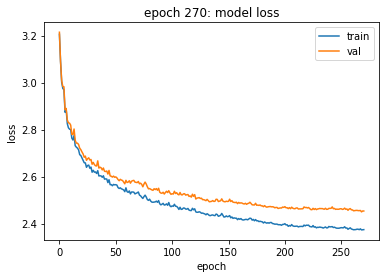

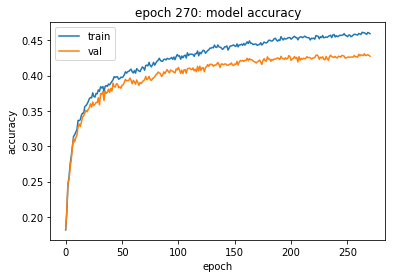



Epoch 271/2000 ...........
Loss train: 2.3707728056562267 
Loss val: 2.4534167638909268 
Train accuracy :  0.4608 
Validation accuracy :  0.4272
Alpha:  1.0282882503888335


Epoch 272/2000 ...........
Loss train: 2.369689556672128 
Loss val: 2.4512015177606483 
Train accuracy :  0.45955 
Validation accuracy :  0.4275
Alpha:  1.0231468091368894


Epoch 273/2000 ...........
Loss train: 2.3676937500293667 
Loss val: 2.4494342849037927 
Train accuracy :  0.461975 
Validation accuracy :  0.4269
Alpha:  1.018031075091205


Epoch 274/2000 ...........
Loss train: 2.3683129299704384 
Loss val: 2.4499828028060104 
Train accuracy :  0.45935 
Validation accuracy :  0.4272
Alpha:  1.0129409197157488


Epoch 275/2000 ...........
Loss train: 2.3700812013437895 
Loss val: 2.452232241128915 
Train accuracy :  0.461825 
Validation accuracy :  0.4284
Alpha:  1.00787621511717


Epoch 276/2000 ...........
Loss train: 2.371353385731168 
Loss val: 2.4540428856269334 
Train accuracy :  0.4621 
Validation ac

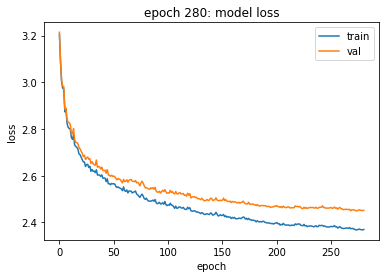

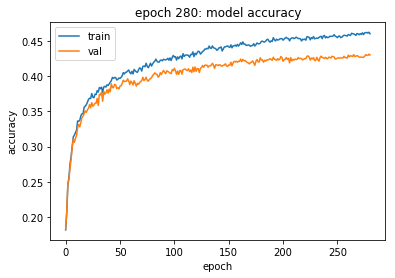



Epoch 281/2000 ...........
Loss train: 2.369966383127927 
Loss val: 2.4554160899663757 
Train accuracy :  0.46195 
Validation accuracy :  0.4285
Alpha:  0.9780153719837437


Epoch 282/2000 ...........
Loss train: 2.3690967353949177 
Loss val: 2.455571061191788 
Train accuracy :  0.461675 
Validation accuracy :  0.4308
Alpha:  0.973125295123825


Epoch 283/2000 ...........
Loss train: 2.3717450390002544 
Loss val: 2.4582791746263104 
Train accuracy :  0.4609 
Validation accuracy :  0.4323
Alpha:  0.9682596686482058


Epoch 284/2000 ...........
Loss train: 2.370908853049827 
Loss val: 2.455718063101716 
Train accuracy :  0.461025 
Validation accuracy :  0.4294
Alpha:  0.9634183703049648


Epoch 285/2000 ...........
Loss train: 2.3661168133131056 
Loss val: 2.45193513235676 
Train accuracy :  0.46245 
Validation accuracy :  0.4291
Alpha:  0.95860127845344


Epoch 286/2000 ...........
Loss train: 2.3654741338134078 
Loss val: 2.4513821774878597 
Train accuracy :  0.461475 
Validation acc

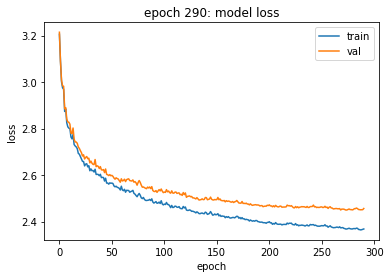

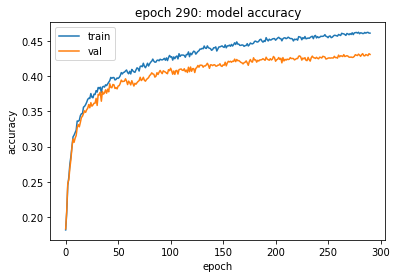



Epoch 291/2000 ...........
Loss train: 2.3687722125220696 
Loss val: 2.4539453721814617 
Train accuracy :  0.4606 
Validation accuracy :  0.4309
Alpha:  0.9302003280449889


Epoch 292/2000 ...........
Loss train: 2.3658496048964537 
Loss val: 2.453842345642226 
Train accuracy :  0.462125 
Validation accuracy :  0.4315
Alpha:  0.925549326404764


Epoch 293/2000 ...........
Loss train: 2.3669524823875605 
Loss val: 2.454588888378023 
Train accuracy :  0.462125 
Validation accuracy :  0.4309
Alpha:  0.9209215797727401


Epoch 294/2000 ...........
Loss train: 2.3644530205126952 
Loss val: 2.45128005260725 
Train accuracy :  0.4628 
Validation accuracy :  0.4313
Alpha:  0.9163169718738764


Epoch 295/2000 ...........
Loss train: 2.361672373518828 
Loss val: 2.4470791035731754 
Train accuracy :  0.46435 
Validation accuracy :  0.4339
Alpha:  0.911735387014507


Epoch 296/2000 ...........
Loss train: 2.3620128641946287 
Loss val: 2.4469969681862707 
Train accuracy :  0.46345 
Validation acc

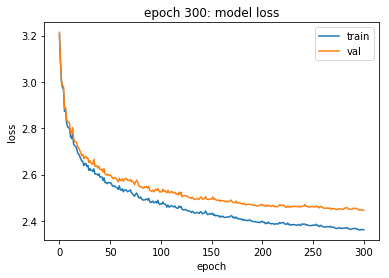

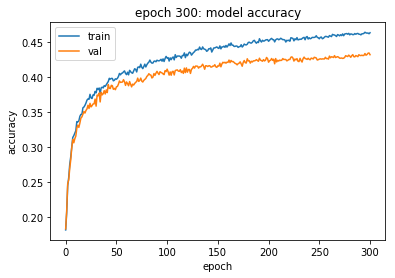



Epoch 301/2000 ...........
Loss train: 2.364703602222392 
Loss val: 2.4467666661305936 
Train accuracy :  0.4635 
Validation accuracy :  0.4332
Alpha:  0.8847229553661732


Epoch 302/2000 ...........
Loss train: 2.3635340997141228 
Loss val: 2.448882800855603 
Train accuracy :  0.463725 
Validation accuracy :  0.4321
Alpha:  0.8802993405893423


Epoch 303/2000 ...........
Loss train: 2.363237135690769 
Loss val: 2.4475725109880417 
Train accuracy :  0.463225 
Validation accuracy :  0.4331
Alpha:  0.8758978438863956


Epoch 304/2000 ...........
Loss train: 2.3628394160162 
Loss val: 2.4450642083338927 
Train accuracy :  0.4635 
Validation accuracy :  0.4324
Alpha:  0.8715183546669636


Epoch 305/2000 ...........
Loss train: 2.363690575142951 
Loss val: 2.4474177794462073 
Train accuracy :  0.463925 
Validation accuracy :  0.4353
Alpha:  0.8671607628936288


Epoch 306/2000 ...........
Loss train: 2.3627493774437434 
Loss val: 2.4464762646998848 
Train accuracy :  0.465125 
Validation a

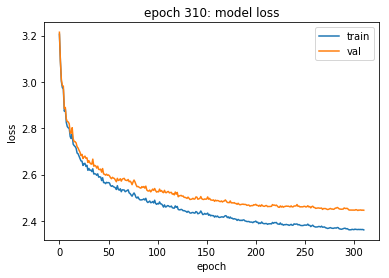

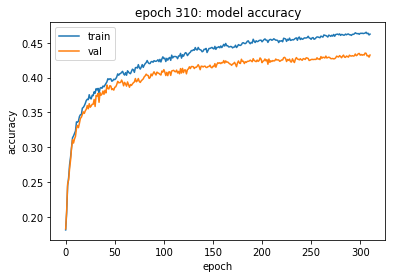



Epoch 311/2000 ...........
Loss train: 2.361714191422342 
Loss val: 2.447043790979612 
Train accuracy :  0.46525 
Validation accuracy :  0.4324
Alpha:  0.8414689655043841


Epoch 312/2000 ...........
Loss train: 2.361682417937013 
Loss val: 2.444862835551074 
Train accuracy :  0.463025 
Validation accuracy :  0.4308
Alpha:  0.8372616206768622


Epoch 313/2000 ...........
Loss train: 2.363047070232171 
Loss val: 2.4467165119875722 
Train accuracy :  0.461825 
Validation accuracy :  0.4328
Alpha:  0.8330753125734779


Epoch 314/2000 ...........
Loss train: 2.3605793768765886 
Loss val: 2.4435297674184793 
Train accuracy :  0.463475 
Validation accuracy :  0.4313
Alpha:  0.8289099360106105


Epoch 315/2000 ...........
Loss train: 2.359730047826382 
Loss val: 2.445590925827153 
Train accuracy :  0.4654 
Validation accuracy :  0.4301
Alpha:  0.8247653863305574


Epoch 316/2000 ...........
Loss train: 2.3605521520182458 
Loss val: 2.4481607354554544 
Train accuracy :  0.463 
Validation acc

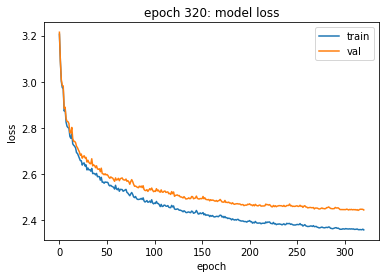

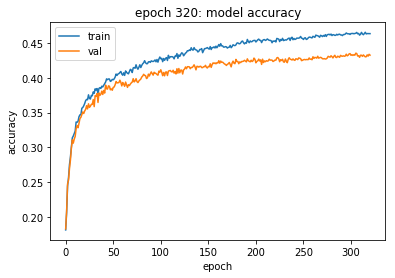



Epoch 321/2000 ...........
Loss train: 2.3603749265608833 
Loss val: 2.445416534390321 
Train accuracy :  0.46295 
Validation accuracy :  0.4327
Alpha:  0.8003296575637728


Epoch 322/2000 ...........
Loss train: 2.358770285674244 
Loss val: 2.444592599822904 
Train accuracy :  0.46355 
Validation accuracy :  0.4303
Alpha:  0.7963280092759539


Epoch 323/2000 ...........
Loss train: 2.3569459355167957 
Loss val: 2.443607677990611 
Train accuracy :  0.464575 
Validation accuracy :  0.431
Alpha:  0.7923463692295741


Epoch 324/2000 ...........
Loss train: 2.3557637946881074 
Loss val: 2.442172028177992 
Train accuracy :  0.465175 
Validation accuracy :  0.4333
Alpha:  0.7883846373834262


Epoch 325/2000 ...........
Loss train: 2.35481158681098 
Loss val: 2.4418861754988184 
Train accuracy :  0.465025 
Validation accuracy :  0.433
Alpha:  0.7844427141965091


Epoch 326/2000 ...........
Loss train: 2.3556289736402007 
Loss val: 2.4429314429035665 
Train accuracy :  0.464425 
Validation a

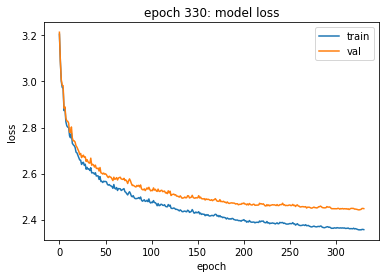

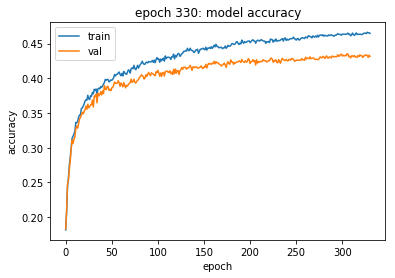



Epoch 331/2000 ...........
Loss train: 2.357279764194431 
Loss val: 2.4467320675648088 
Train accuracy :  0.465175 
Validation accuracy :  0.4318
Alpha:  0.7612016450211064


Epoch 332/2000 ...........
Loss train: 2.3577928461048963 
Loss val: 2.447088364397335 
Train accuracy :  0.466025 
Validation accuracy :  0.4318
Alpha:  0.7573956367960009


Epoch 333/2000 ...........
Loss train: 2.3562393658659198 
Loss val: 2.4470452894321335 
Train accuracy :  0.4668 
Validation accuracy :  0.4343
Alpha:  0.7536086586120209


Epoch 334/2000 ...........
Loss train: 2.357152443197877 
Loss val: 2.4474900494292937 
Train accuracy :  0.4662 
Validation accuracy :  0.4336
Alpha:  0.7498406153189607


Epoch 335/2000 ...........
Loss train: 2.352946749300206 
Loss val: 2.4418180308189874 
Train accuracy :  0.465375 
Validation accuracy :  0.4345
Alpha:  0.746091412242366


Epoch 336/2000 ...........
Loss train: 2.353504020072959 
Loss val: 2.441857871416382 
Train accuracy :  0.467175 
Validation a

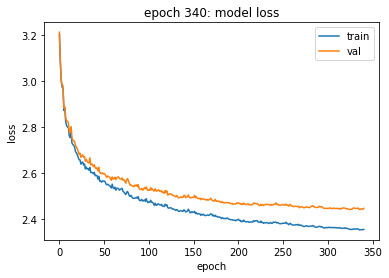

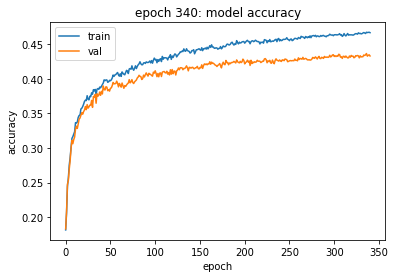



Epoch 341/2000 ...........
Loss train: 2.3515866154222733 
Loss val: 2.4424048194206125 
Train accuracy :  0.467825 
Validation accuracy :  0.4369
Alpha:  0.7239865959067847


Epoch 342/2000 ...........
Loss train: 2.354685922539813 
Loss val: 2.4441225528886603 
Train accuracy :  0.466425 
Validation accuracy :  0.4345
Alpha:  0.7203666629272508


Epoch 343/2000 ...........
Loss train: 2.3515552527035752 
Loss val: 2.439948160482015 
Train accuracy :  0.46725 
Validation accuracy :  0.4346
Alpha:  0.7167648296126146


Epoch 344/2000 ...........
Loss train: 2.3532111939373457 
Loss val: 2.441957719528694 
Train accuracy :  0.46745 
Validation accuracy :  0.4363
Alpha:  0.7131810054645514


Epoch 345/2000 ...........
Loss train: 2.351982378954356 
Loss val: 2.441827217778081 
Train accuracy :  0.4676 
Validation accuracy :  0.4363
Alpha:  0.7096151004372286


Epoch 346/2000 ...........
Loss train: 2.3528046532203444 
Loss val: 2.442094415107832 
Train accuracy :  0.46645 
Validation a

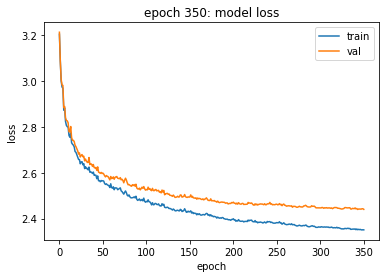

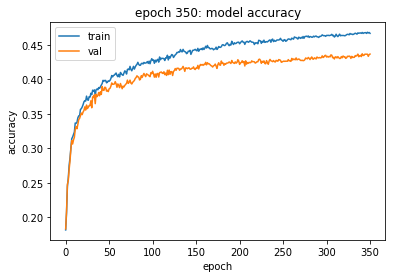



Epoch 351/2000 ...........
Loss train: 2.3529190594369105 
Loss val: 2.443088681262031 
Train accuracy :  0.468225 
Validation accuracy :  0.4373
Alpha:  0.6885909856883718


Epoch 352/2000 ...........
Loss train: 2.3523698804832702 
Loss val: 2.4437789622551533 
Train accuracy :  0.46975 
Validation accuracy :  0.4369
Alpha:  0.68514803075993


Epoch 353/2000 ...........
Loss train: 2.352570776408113 
Loss val: 2.4439018328387823 
Train accuracy :  0.4682 
Validation accuracy :  0.4336
Alpha:  0.6817222906061303


Epoch 354/2000 ...........
Loss train: 2.35309732271983 
Loss val: 2.445172331922634 
Train accuracy :  0.467875 
Validation accuracy :  0.4355
Alpha:  0.6783136791530997


Epoch 355/2000 ...........
Loss train: 2.3529014789704266 
Loss val: 2.4433439786294304 
Train accuracy :  0.467425 
Validation accuracy :  0.4338
Alpha:  0.6749221107573342


Epoch 356/2000 ...........
Loss train: 2.353744716222362 
Loss val: 2.445241091525874 
Train accuracy :  0.4672 
Validation accu

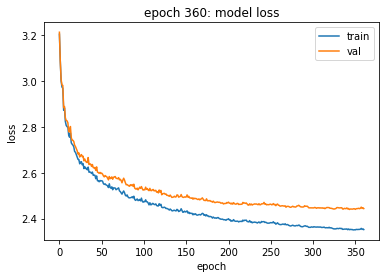

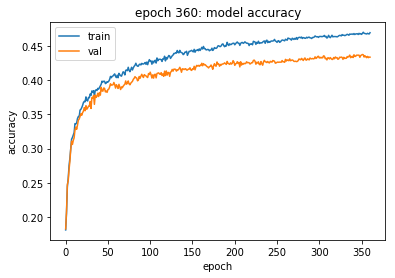



Epoch 361/2000 ...........
Loss train: 2.355359266277171 
Loss val: 2.448025142534769 
Train accuracy :  0.4678 
Validation accuracy :  0.4353
Alpha:  0.6549258622356218


Epoch 362/2000 ...........
Loss train: 2.354082602552187 
Loss val: 2.447605006401001 
Train accuracy :  0.469 
Validation accuracy :  0.4354
Alpha:  0.6516512329244437


Epoch 363/2000 ...........
Loss train: 2.3565311768278754 
Loss val: 2.45166113658365 
Train accuracy :  0.469325 
Validation accuracy :  0.4344
Alpha:  0.6483929767598214


Epoch 364/2000 ...........
Loss train: 2.353184784267289 
Loss val: 2.451219690054223 
Train accuracy :  0.46865 
Validation accuracy :  0.4318
Alpha:  0.6451510118760223


Epoch 365/2000 ...........
Loss train: 2.3532314281507873 
Loss val: 2.450411460645649 
Train accuracy :  0.469175 
Validation accuracy :  0.4341
Alpha:  0.6419252568166421


Epoch 366/2000 ...........
Loss train: 2.353078534126837 
Loss val: 2.4504079135277337 
Train accuracy :  0.46875 
Validation accurac

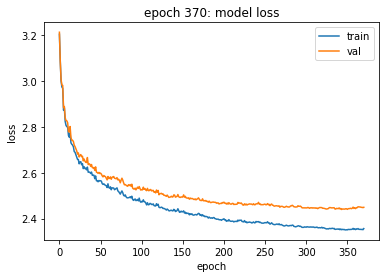

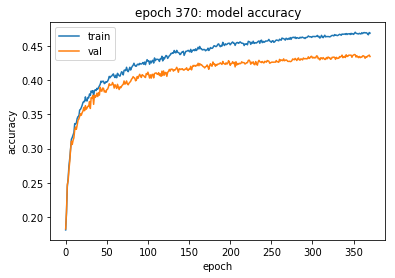



Epoch 371/2000 ...........
Loss train: 2.357716047382608 
Loss val: 2.4515011092784804 
Train accuracy :  0.466625 
Validation accuracy :  0.4315
Alpha:  0.6229066222763304


Epoch 372/2000 ...........
Loss train: 2.3565781207453353 
Loss val: 2.4524633503626503 
Train accuracy :  0.4667 
Validation accuracy :  0.4345
Alpha:  0.6197920891649488


Epoch 373/2000 ...........
Loss train: 2.354769193532168 
Loss val: 2.4498706878712957 
Train accuracy :  0.46605 
Validation accuracy :  0.4324
Alpha:  0.6166931287191241


Epoch 374/2000 ...........
Loss train: 2.3540442225626474 
Loss val: 2.448392921174658 
Train accuracy :  0.46885 
Validation accuracy :  0.4325
Alpha:  0.6136096630755284


Epoch 375/2000 ...........
Loss train: 2.3544781414593525 
Loss val: 2.449591756586603 
Train accuracy :  0.4679 
Validation accuracy :  0.4349
Alpha:  0.6105416147601508


Epoch 376/2000 ...........
Loss train: 2.3578290516112603 
Loss val: 2.4506554750756853 
Train accuracy :  0.466825 
Validation 

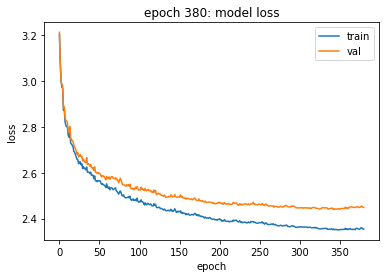

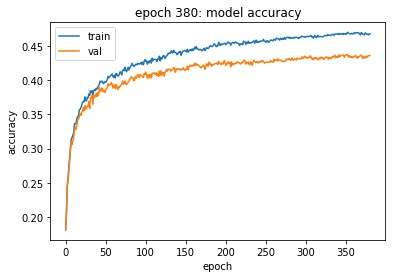



Epoch 381/2000 ...........
Loss train: 2.3550926863156283 
Loss val: 2.4487760947614574 
Train accuracy :  0.465725 
Validation accuracy :  0.4336
Alpha:  0.5924527987812338


Epoch 382/2000 ...........
Loss train: 2.355399654984424 
Loss val: 2.45164835329889 
Train accuracy :  0.4656 
Validation accuracy :  0.4313
Alpha:  0.5894905347873276


Epoch 383/2000 ...........
Loss train: 2.3517013149828667 
Loss val: 2.448139796072158 
Train accuracy :  0.466125 
Validation accuracy :  0.434
Alpha:  0.586543082113391


Epoch 384/2000 ...........
Loss train: 2.3486918989730823 
Loss val: 2.443373497930688 
Train accuracy :  0.46935 
Validation accuracy :  0.4335
Alpha:  0.5836103667028241


Epoch 385/2000 ...........
Loss train: 2.352316247631724 
Loss val: 2.446482054708829 
Train accuracy :  0.466425 
Validation accuracy :  0.4341
Alpha:  0.58069231486931


Epoch 386/2000 ...........
Loss train: 2.351173498500339 
Loss val: 2.4459041544007794 
Train accuracy :  0.4669 
Validation accurac

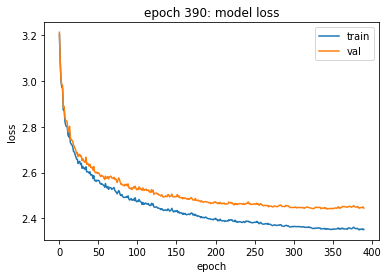

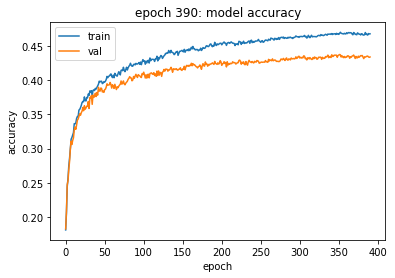



Epoch 391/2000 ...........
Loss train: 2.351359303640991 
Loss val: 2.446080069721938 
Train accuracy :  0.467925 
Validation accuracy :  0.4342
Alpha:  0.563487858743631


Epoch 392/2000 ...........
Loss train: 2.3504763496641683 
Loss val: 2.44707455176908 
Train accuracy :  0.4694 
Validation accuracy :  0.435
Alpha:  0.5606704194499129


Epoch 393/2000 ...........
Loss train: 2.3503871866846797 
Loss val: 2.4486164592436666 
Train accuracy :  0.467375 
Validation accuracy :  0.4337
Alpha:  0.5578670673526633


Epoch 394/2000 ...........
Loss train: 2.351158191572673 
Loss val: 2.4492994503800523 
Train accuracy :  0.4669 
Validation accuracy :  0.4351
Alpha:  0.5550777320159


Epoch 395/2000 ...........
Loss train: 2.3514551868263966 
Loss val: 2.4489794669799516 
Train accuracy :  0.46705 
Validation accuracy :  0.4331
Alpha:  0.5523023433558205


Epoch 396/2000 ...........
Loss train: 2.3512491988957054 
Loss val: 2.448021411969372 
Train accuracy :  0.4677 
Validation accuracy

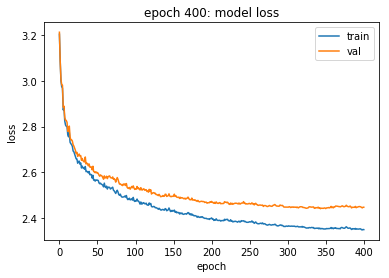

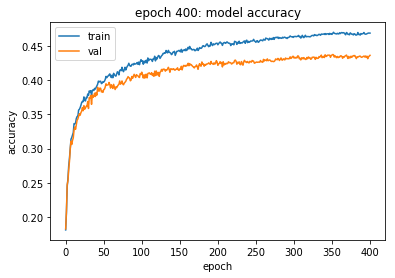



Epoch 401/2000 ...........
Loss train: 2.3488178645575783 
Loss val: 2.447435549913379 
Train accuracy :  0.469025 
Validation accuracy :  0.4364
Alpha:  0.5359390108455334


Epoch 402/2000 ...........
Loss train: 2.3521534103404727 
Loss val: 2.4494622745087526 
Train accuracy :  0.4681 
Validation accuracy :  0.4351
Alpha:  0.5332593157913057


Epoch 403/2000 ...........
Loss train: 2.352946050242798 
Loss val: 2.450082198294914 
Train accuracy :  0.46775 
Validation accuracy :  0.4364
Alpha:  0.5305930192123491


Epoch 404/2000 ...........
Loss train: 2.350271420356085 
Loss val: 2.4469556477608068 
Train accuracy :  0.468425 
Validation accuracy :  0.4357
Alpha:  0.5279400541162874


Epoch 405/2000 ...........
Loss train: 2.3482586925222217 
Loss val: 2.4445703740144356 
Train accuracy :  0.4678 
Validation accuracy :  0.4328
Alpha:  0.525300353845706


Epoch 406/2000 ...........
Loss train: 2.3479733088807357 
Loss val: 2.4441094935836336 
Train accuracy :  0.4684 
Validation ac

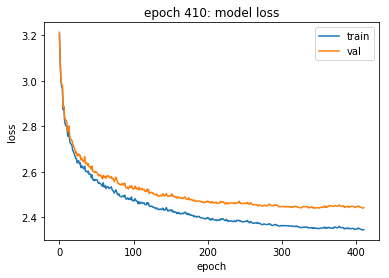

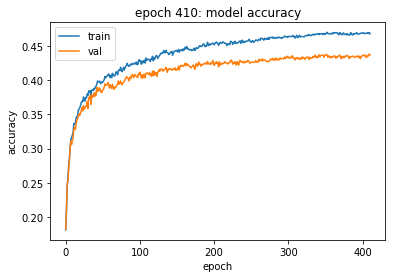



Epoch 411/2000 ...........
Loss train: 2.345014233296769 
Loss val: 2.4421794428021077 
Train accuracy :  0.468675 
Validation accuracy :  0.4356
Alpha:  0.5097370225269919


Epoch 412/2000 ...........
Loss train: 2.3444233118186966 
Loss val: 2.441789742773229 
Train accuracy :  0.47095 
Validation accuracy :  0.4367
Alpha:  0.507188337414357


Epoch 413/2000 ...........
Loss train: 2.3443607781257865 
Loss val: 2.4418393286200706 
Train accuracy :  0.4686 
Validation accuracy :  0.4339
Alpha:  0.5046523957272852


Epoch 414/2000 ...........
Loss train: 2.346472786190191 
Loss val: 2.4439624835743716 
Train accuracy :  0.46955 
Validation accuracy :  0.4359
Alpha:  0.5021291337486488


Epoch 415/2000 ...........
Loss train: 2.347116283723192 
Loss val: 2.4430501149743957 
Train accuracy :  0.4673 
Validation accuracy :  0.4368
Alpha:  0.4996184880799055


Epoch 416/2000 ...........
Loss train: 2.3452817726041473 
Loss val: 2.4413409909023054 
Train accuracy :  0.468925 
Validation a

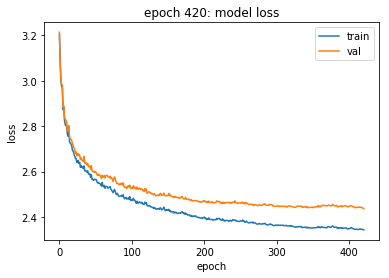

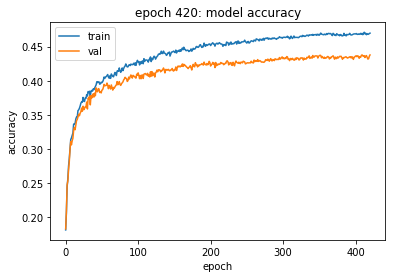



Epoch 421/2000 ...........
Loss train: 2.34233080577589 
Loss val: 2.437613560988783 
Train accuracy :  0.4687 
Validation accuracy :  0.4356
Alpha:  0.4848160459988814


Epoch 422/2000 ...........
Loss train: 2.342866776887306 
Loss val: 2.4395357635847352 
Train accuracy :  0.46865 
Validation accuracy :  0.4381
Alpha:  0.482391965768887


Epoch 423/2000 ...........
Loss train: 2.3431216434847864 
Loss val: 2.4397763948496767 
Train accuracy :  0.469725 
Validation accuracy :  0.4375
Alpha:  0.47998000594004253


Epoch 424/2000 ...........
Loss train: 2.341549800081619 
Loss val: 2.4384951969547637 
Train accuracy :  0.4681 
Validation accuracy :  0.4369
Alpha:  0.47758010591034233


Epoch 425/2000 ...........
Loss train: 2.3427062318172966 
Loss val: 2.440228360308834 
Train accuracy :  0.468675 
Validation accuracy :  0.4374
Alpha:  0.4751922053807906


Epoch 426/2000 ...........
Loss train: 2.3419287358153373 
Loss val: 2.4396161818841855 
Train accuracy :  0.4694 
Validation ac

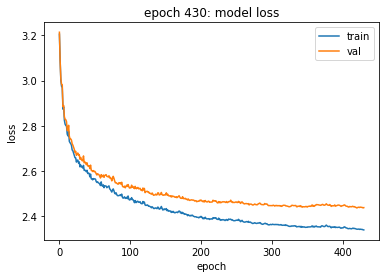

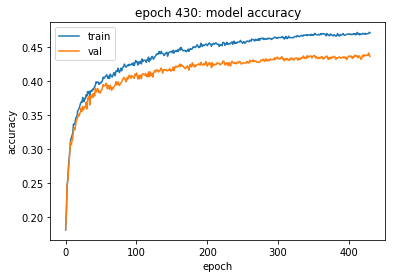



Epoch 431/2000 ...........
Loss train: 2.3390819620582772 
Loss val: 2.4366641141891066 
Train accuracy :  0.471375 
Validation accuracy :  0.4361
Alpha:  0.4611134527618957


Epoch 432/2000 ...........
Loss train: 2.3378789684148495 
Loss val: 2.4356871591691402 
Train accuracy :  0.470725 
Validation accuracy :  0.4358
Alpha:  0.4588078854980862


Epoch 433/2000 ...........
Loss train: 2.339221982934701 
Loss val: 2.437408206636699 
Train accuracy :  0.47 
Validation accuracy :  0.4365
Alpha:  0.45651384607059575


Epoch 434/2000 ...........
Loss train: 2.3399702053551192 
Loss val: 2.438109681157962 
Train accuracy :  0.46995 
Validation accuracy :  0.435
Alpha:  0.4542312768402428


Epoch 435/2000 ...........
Loss train: 2.3395402664841405 
Loss val: 2.4372522751071823 
Train accuracy :  0.468825 
Validation accuracy :  0.4349
Alpha:  0.45196012045604156


Epoch 436/2000 ...........
Loss train: 2.3412614991988425 
Loss val: 2.4400850117885367 
Train accuracy :  0.46945 
Validatio

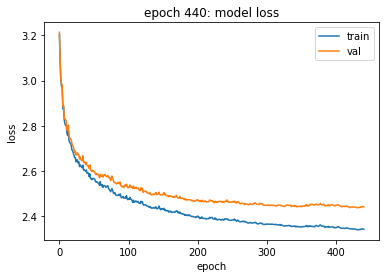

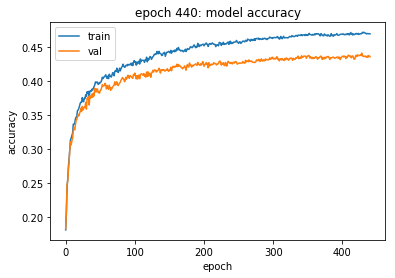



Epoch 441/2000 ...........
Loss train: 2.3401773355827244 
Loss val: 2.4394632725458156 
Train accuracy :  0.46945 
Validation accuracy :  0.4363
Alpha:  0.4385696762158891


Epoch 442/2000 ...........
Loss train: 2.3410656170434394 
Loss val: 2.4397845275853 
Train accuracy :  0.4707 
Validation accuracy :  0.4363
Alpha:  0.43637682783480963


Epoch 443/2000 ...........
Loss train: 2.3434360705611876 
Loss val: 2.4424711890490673 
Train accuracy :  0.470225 
Validation accuracy :  0.4354
Alpha:  0.4341949436956356


Epoch 444/2000 ...........
Loss train: 2.3430005012021327 
Loss val: 2.442732435415109 
Train accuracy :  0.4692 
Validation accuracy :  0.4364
Alpha:  0.43202396897715745


Epoch 445/2000 ...........
Loss train: 2.34343792858525 
Loss val: 2.442640956756734 
Train accuracy :  0.4702 
Validation accuracy :  0.4366
Alpha:  0.42986384913227166


Epoch 446/2000 ...........
Loss train: 2.343138085551257 
Loss val: 2.444244213931281 
Train accuracy :  0.469125 
Validation acc

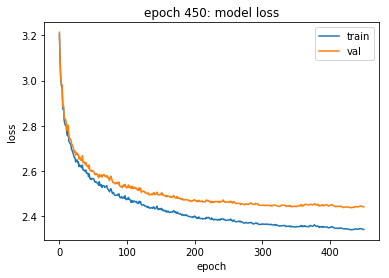

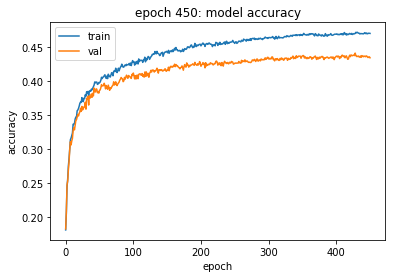



Epoch 451/2000 ...........
Loss train: 2.341904293940182 
Loss val: 2.443203312361582 
Train accuracy :  0.471175 
Validation accuracy :  0.4373
Alpha:  0.4171280619640256


Epoch 452/2000 ...........
Loss train: 2.3407715079885327 
Loss val: 2.44107008723122 
Train accuracy :  0.470375 
Validation accuracy :  0.4333
Alpha:  0.41504242165420546


Epoch 453/2000 ...........
Loss train: 2.3416263780166586 
Loss val: 2.440761830945657 
Train accuracy :  0.470125 
Validation accuracy :  0.4328
Alpha:  0.4129672095459344


Epoch 454/2000 ...........
Loss train: 2.3381454310805774 
Loss val: 2.43740273427171 
Train accuracy :  0.470375 
Validation accuracy :  0.4337
Alpha:  0.41090237349820474


Epoch 455/2000 ...........
Loss train: 2.3370971993596004 
Loss val: 2.436026133023708 
Train accuracy :  0.470825 
Validation accuracy :  0.4364
Alpha:  0.40884786163071374


Epoch 456/2000 ...........
Loss train: 2.337878649919177 
Loss val: 2.4367652920042926 
Train accuracy :  0.4701 
Validatio

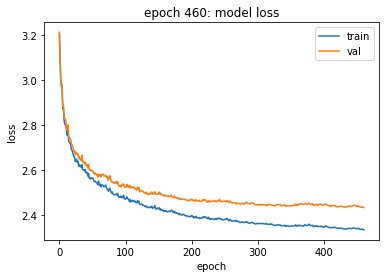

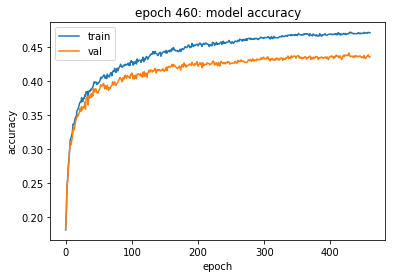



Epoch 461/2000 ...........
Loss train: 2.3369864113659 
Loss val: 2.437283466442067 
Train accuracy :  0.47155 
Validation accuracy :  0.4373
Alpha:  0.39673472543553895


Epoch 462/2000 ...........
Loss train: 2.3367861840431585 
Loss val: 2.436135101505851 
Train accuracy :  0.470575 
Validation accuracy :  0.4359
Alpha:  0.39475105180836123


Epoch 463/2000 ...........
Loss train: 2.3386024514870147 
Loss val: 2.4379716789003436 
Train accuracy :  0.470075 
Validation accuracy :  0.4348
Alpha:  0.3927772965493194


Epoch 464/2000 ...........
Loss train: 2.337469962710046 
Loss val: 2.4371449945650263 
Train accuracy :  0.471275 
Validation accuracy :  0.435
Alpha:  0.39081341006657283


Epoch 465/2000 ...........
Loss train: 2.3372936436234872 
Loss val: 2.436180685925259 
Train accuracy :  0.47085 
Validation accuracy :  0.4354
Alpha:  0.38885934301624


Epoch 466/2000 ...........
Loss train: 2.3364946266291406 
Loss val: 2.4352278606244386 
Train accuracy :  0.470775 
Validation

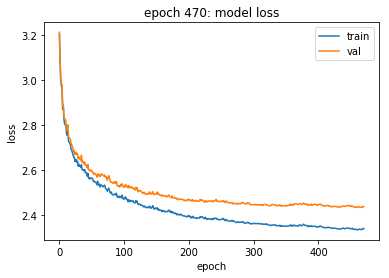

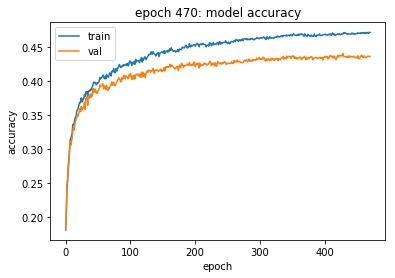



Epoch 471/2000 ...........
Loss train: 2.3460873016407717 
Loss val: 2.4444848398619143 
Train accuracy :  0.4717 
Validation accuracy :  0.4384
Alpha:  0.3773384164692976


Epoch 472/2000 ...........
Loss train: 2.34663934144832 
Loss val: 2.444273624122338 
Train accuracy :  0.470925 
Validation accuracy :  0.4378
Alpha:  0.3754517243869511


Epoch 473/2000 ...........
Loss train: 2.348602103729425 
Loss val: 2.4462652365646482 
Train accuracy :  0.47055 
Validation accuracy :  0.4384
Alpha:  0.37357446576501635


Epoch 474/2000 ...........
Loss train: 2.3469104045604707 
Loss val: 2.4452683694766213 
Train accuracy :  0.471675 
Validation accuracy :  0.439
Alpha:  0.3717065934361913


Epoch 475/2000 ...........
Loss train: 2.3448005976838138 
Loss val: 2.442832514478613 
Train accuracy :  0.470625 
Validation accuracy :  0.4394
Alpha:  0.3698480604690103


Epoch 476/2000 ...........
Loss train: 2.344917154993074 
Loss val: 2.4435844494438035 
Train accuracy :  0.4717 
Validation a

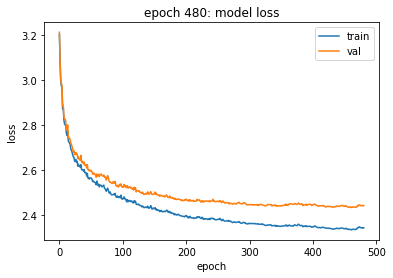

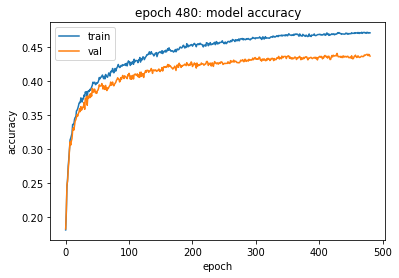



Epoch 481/2000 ...........
Loss train: 2.3439056624603487 
Loss val: 2.4434061831555964 
Train accuracy :  0.472375 
Validation accuracy :  0.4374
Alpha:  0.3588903905178613


Epoch 482/2000 ...........
Loss train: 2.342828359770697 
Loss val: 2.442367951851055 
Train accuracy :  0.47195 
Validation accuracy :  0.4374
Alpha:  0.357095938565272


Epoch 483/2000 ...........
Loss train: 2.3408006974415216 
Loss val: 2.439259888834406 
Train accuracy :  0.472875 
Validation accuracy :  0.4351
Alpha:  0.3553104588724456


Epoch 484/2000 ...........
Loss train: 2.340092687462497 
Loss val: 2.439589350770914 
Train accuracy :  0.47295 
Validation accuracy :  0.4345
Alpha:  0.35353390657808337


Epoch 485/2000 ...........
Loss train: 2.339629055395171 
Loss val: 2.4400759458013592 
Train accuracy :  0.472275 
Validation accuracy :  0.437
Alpha:  0.35176623704519294


Epoch 486/2000 ...........
Loss train: 2.339178328907789 
Loss val: 2.4396153419275706 
Train accuracy :  0.47225 
Validation 

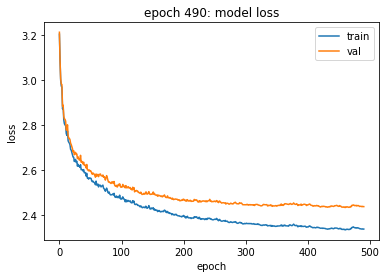

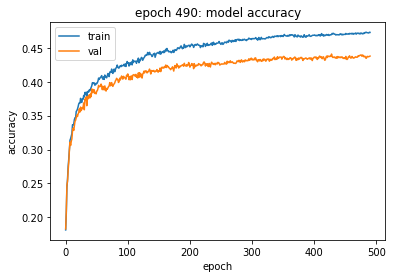



Epoch 491/2000 ...........
Loss train: 2.339914499934546 
Loss val: 2.440072581957347 
Train accuracy :  0.472375 
Validation accuracy :  0.437
Alpha:  0.3413442861483549


Epoch 492/2000 ...........
Loss train: 2.3396460022324415 
Loss val: 2.43993289743193 
Train accuracy :  0.4732 
Validation accuracy :  0.4385
Alpha:  0.3396375647176131


Epoch 493/2000 ...........
Loss train: 2.339144797049936 
Loss val: 2.439878075578763 
Train accuracy :  0.473475 
Validation accuracy :  0.4382
Alpha:  0.33793937689402503


Epoch 494/2000 ...........
Loss train: 2.3395924054750186 
Loss val: 2.4408338493966584 
Train accuracy :  0.472875 
Validation accuracy :  0.4367
Alpha:  0.3362496800095549


Epoch 495/2000 ...........
Loss train: 2.3389781574457733 
Loss val: 2.4402629145584536 
Train accuracy :  0.47185 
Validation accuracy :  0.4379
Alpha:  0.3345684316095071


Epoch 496/2000 ...........
Loss train: 2.3372393716098725 
Loss val: 2.438113480991398 
Train accuracy :  0.47345 
Validation a

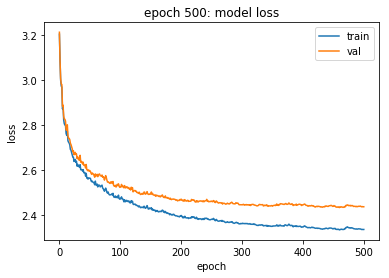

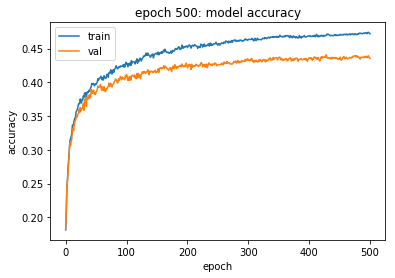



Epoch 501/2000 ...........
Loss train: 2.336696798981886 
Loss val: 2.4375589692343627 
Train accuracy :  0.471825 
Validation accuracy :  0.4362
Alpha:  0.3246560085323076


Epoch 502/2000 ...........
Loss train: 2.336764057350487 
Loss val: 2.4376001527593765 
Train accuracy :  0.47175 
Validation accuracy :  0.4371
Alpha:  0.32303272848964604


Epoch 503/2000 ...........
Loss train: 2.33798949937437 
Loss val: 2.438575915614595 
Train accuracy :  0.472575 
Validation accuracy :  0.4364
Alpha:  0.3214175648471978


Epoch 504/2000 ...........
Loss train: 2.3373159629582956 
Loss val: 2.436538392677723 
Train accuracy :  0.471925 
Validation accuracy :  0.4357
Alpha:  0.31981047702296184


Epoch 505/2000 ...........
Loss train: 2.336596762758998 
Loss val: 2.4361428225432804 
Train accuracy :  0.473875 
Validation accuracy :  0.4357
Alpha:  0.318211424637847


Epoch 506/2000 ...........
Loss train: 2.336690048444711 
Loss val: 2.4363931183488634 
Train accuracy :  0.473325 
Validatio

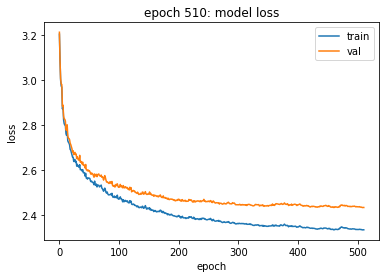

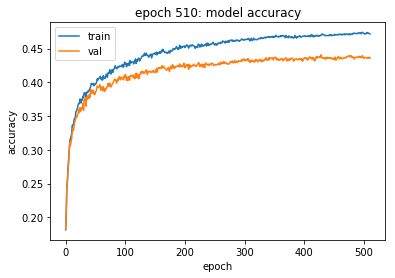



Epoch 511/2000 ...........
Loss train: 2.3358025111337404 
Loss val: 2.4344827758934486 
Train accuracy :  0.4726 
Validation accuracy :  0.4376
Alpha:  0.30878361863165976


Epoch 512/2000 ...........
Loss train: 2.3360787925507576 
Loss val: 2.434377229429521 
Train accuracy :  0.47265 
Validation accuracy :  0.4365
Alpha:  0.30723970053850147


Epoch 513/2000 ...........
Loss train: 2.3341822548101683 
Loss val: 2.4323985822865346 
Train accuracy :  0.473275 
Validation accuracy :  0.4371
Alpha:  0.305703502035809


Epoch 514/2000 ...........
Loss train: 2.3357153811791487 
Loss val: 2.4336429493700296 
Train accuracy :  0.4717 
Validation accuracy :  0.4378
Alpha:  0.3041749845256299


Epoch 515/2000 ...........
Loss train: 2.334368460094193 
Loss val: 2.4323132228897664 
Train accuracy :  0.472375 
Validation accuracy :  0.4359
Alpha:  0.30265410960300176


Epoch 516/2000 ...........
Loss train: 2.3341902946480513 
Loss val: 2.4314612944892344 
Train accuracy :  0.47305 
Validat

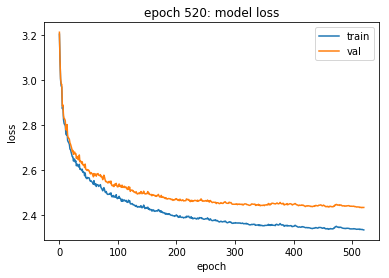

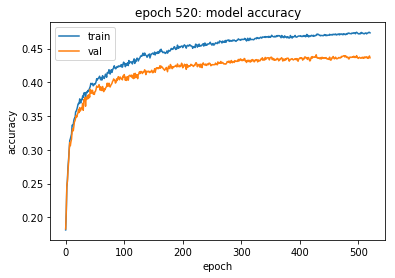



Epoch 521/2000 ...........
Loss train: 2.332218950998591 
Loss val: 2.4329680402573572 
Train accuracy :  0.47285 
Validation accuracy :  0.4374
Alpha:  0.293687227802451


Epoch 522/2000 ...........
Loss train: 2.3319483362635283 
Loss val: 2.4319294818809767 
Train accuracy :  0.47365 
Validation accuracy :  0.4376
Alpha:  0.2922187916634387


Epoch 523/2000 ...........
Loss train: 2.332055891690708 
Loss val: 2.431418920202064 
Train accuracy :  0.474525 
Validation accuracy :  0.4388
Alpha:  0.29075769770512155


Epoch 524/2000 ...........
Loss train: 2.3325744203777137 
Loss val: 2.4334961337275627 
Train accuracy :  0.473525 
Validation accuracy :  0.4391
Alpha:  0.28930390921659593


Epoch 525/2000 ...........
Loss train: 2.3326665138922245 
Loss val: 2.4337115221735517 
Train accuracy :  0.4741 
Validation accuracy :  0.4387
Alpha:  0.28785738967051294


Epoch 526/2000 ...........
Loss train: 2.3315597178324605 
Loss val: 2.4332220703239265 
Train accuracy :  0.47365 
Validat

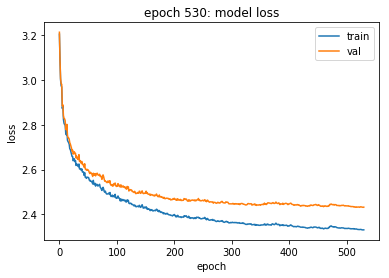

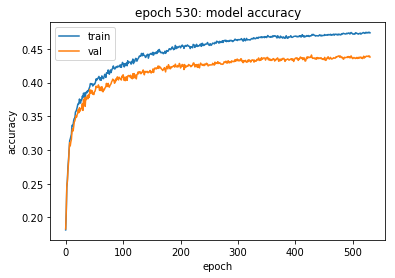



Epoch 531/2000 ...........
Loss train: 2.330510903367851 
Loss val: 2.4308961720572273 
Train accuracy :  0.4739 
Validation accuracy :  0.4404
Alpha:  0.27932889755132


Epoch 532/2000 ...........
Loss train: 2.330764613182049 
Loss val: 2.431814606071486 
Train accuracy :  0.47395 
Validation accuracy :  0.4404
Alpha:  0.2779322530635634


Epoch 533/2000 ...........
Loss train: 2.3312632389668044 
Loss val: 2.4323633147112074 
Train accuracy :  0.4742 
Validation accuracy :  0.4391
Alpha:  0.2765425917982456


Epoch 534/2000 ...........
Loss train: 2.3299588208624957 
Loss val: 2.431500443159754 
Train accuracy :  0.47405 
Validation accuracy :  0.4403
Alpha:  0.27515987883925436


Epoch 535/2000 ...........
Loss train: 2.3298996063873574 
Loss val: 2.432493600255403 
Train accuracy :  0.47455 
Validation accuracy :  0.4391
Alpha:  0.27378407944505806


Epoch 536/2000 ...........
Loss train: 2.3297274597652406 
Loss val: 2.4316870711655314 
Train accuracy :  0.47515 
Validation acc

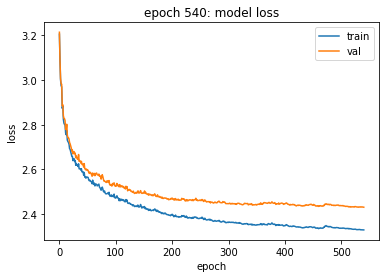

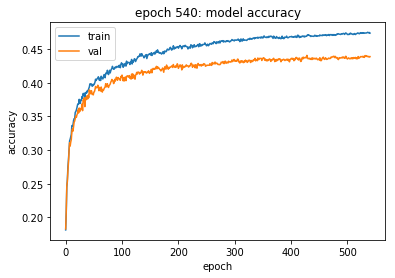



Epoch 541/2000 ...........
Loss train: 2.329626884409592 
Loss val: 2.431493163526324 
Train accuracy :  0.47465 
Validation accuracy :  0.4383
Alpha:  0.2656725441928961


Epoch 542/2000 ...........
Loss train: 2.3298418779246703 
Loss val: 2.432277932041728 
Train accuracy :  0.47485 
Validation accuracy :  0.4371
Alpha:  0.2643441814719316


Epoch 543/2000 ...........
Loss train: 2.33017383626934 
Loss val: 2.4328929326892403 
Train accuracy :  0.4746 
Validation accuracy :  0.4379
Alpha:  0.26302246056457196


Epoch 544/2000 ...........
Loss train: 2.3303279092821616 
Loss val: 2.4328783970745773 
Train accuracy :  0.4737 
Validation accuracy :  0.4385
Alpha:  0.2617073482617491


Epoch 545/2000 ...........
Loss train: 2.329736971683511 
Loss val: 2.431653129921017 
Train accuracy :  0.474025 
Validation accuracy :  0.4388
Alpha:  0.2603988115204403


Epoch 546/2000 ...........
Loss train: 2.329149930465216 
Loss val: 2.4306511271034417 
Train accuracy :  0.474275 
Validation acc

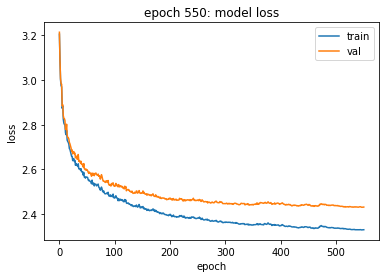

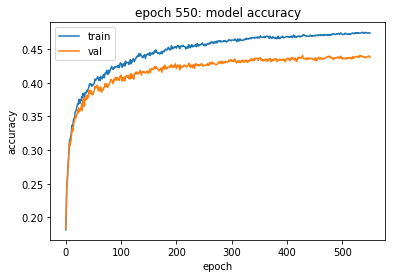



Epoch 551/2000 ...........
Loss train: 2.3291973397294514 
Loss val: 2.430623995323982 
Train accuracy :  0.475075 
Validation accuracy :  0.4382
Alpha:  0.2526838481684789


Epoch 552/2000 ...........
Loss train: 2.329385250819504 
Loss val: 2.430570970008388 
Train accuracy :  0.47495 
Validation accuracy :  0.4411
Alpha:  0.2514204289276365


Epoch 553/2000 ...........
Loss train: 2.329567891087319 
Loss val: 2.4309205468409303 
Train accuracy :  0.474525 
Validation accuracy :  0.439
Alpha:  0.2501633267829983


Epoch 554/2000 ...........
Loss train: 2.3301033542524263 
Loss val: 2.430989022762294 
Train accuracy :  0.474025 
Validation accuracy :  0.4393
Alpha:  0.2489125101490833


Epoch 555/2000 ...........
Loss train: 2.330191669117562 
Loss val: 2.4315959926944477 
Train accuracy :  0.4744 
Validation accuracy :  0.4383
Alpha:  0.24766794759833788


Epoch 556/2000 ...........
Loss train: 2.329304455709381 
Loss val: 2.430295237127487 
Train accuracy :  0.475 
Validation accu

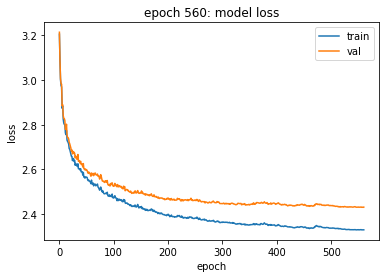

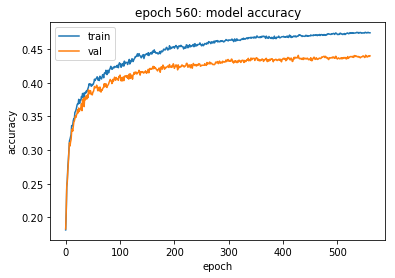



Epoch 561/2000 ...........
Loss train: 2.3294299526310085 
Loss val: 2.4306512852632243 
Train accuracy :  0.474 
Validation accuracy :  0.4392
Alpha:  0.24033016779811517


Epoch 562/2000 ...........
Loss train: 2.328768654799848 
Loss val: 2.430529656277382 
Train accuracy :  0.475 
Validation accuracy :  0.4385
Alpha:  0.2391285169591246


Epoch 563/2000 ...........
Loss train: 2.3283626885214384 
Loss val: 2.4302786933543614 
Train accuracy :  0.4749 
Validation accuracy :  0.4385
Alpha:  0.23793287437432897


Epoch 564/2000 ...........
Loss train: 2.3279357313575924 
Loss val: 2.4298638270065434 
Train accuracy :  0.47445 
Validation accuracy :  0.4398
Alpha:  0.23674321000245732


Epoch 565/2000 ...........
Loss train: 2.3285963835923065 
Loss val: 2.4304248004489377 
Train accuracy :  0.474625 
Validation accuracy :  0.4402
Alpha:  0.23555949395244502


Epoch 566/2000 ...........
Loss train: 2.32904464652703 
Loss val: 2.4306431175215364 
Train accuracy :  0.474225 
Validation

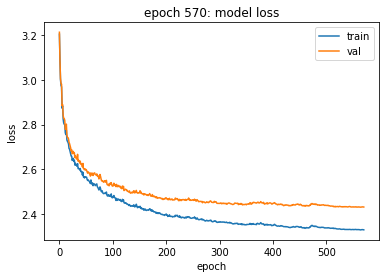

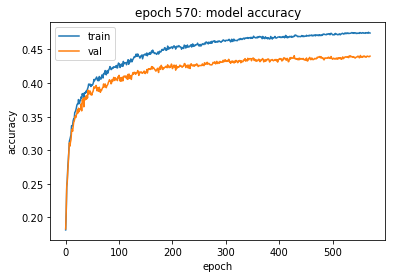



Epoch 571/2000 ...........
Loss train: 2.3278995845339 
Loss val: 2.4306297880541194 
Train accuracy :  0.4749 
Validation accuracy :  0.4399
Alpha:  0.22858045724932613


Epoch 572/2000 ...........
Loss train: 2.327934568376065 
Loss val: 2.430163258113756 
Train accuracy :  0.474325 
Validation accuracy :  0.4408
Alpha:  0.2274375549630795


Epoch 573/2000 ...........
Loss train: 2.3282848928049424 
Loss val: 2.431336295622137 
Train accuracy :  0.474625 
Validation accuracy :  0.4394
Alpha:  0.2263003671882641


Epoch 574/2000 ...........
Loss train: 2.3281068980530746 
Loss val: 2.4308589242924796 
Train accuracy :  0.4761 
Validation accuracy :  0.4399
Alpha:  0.22516886535232278


Epoch 575/2000 ...........
Loss train: 2.3281505116989205 
Loss val: 2.4296924851496557 
Train accuracy :  0.47615 
Validation accuracy :  0.4398
Alpha:  0.22404302102556117


Epoch 576/2000 ...........
Loss train: 2.3280194356094444 
Loss val: 2.429914122383563 
Train accuracy :  0.4762 
Validation a

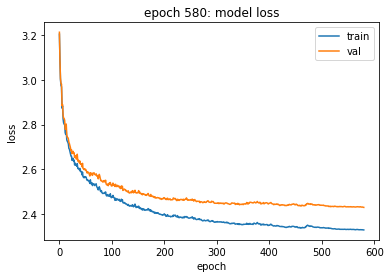

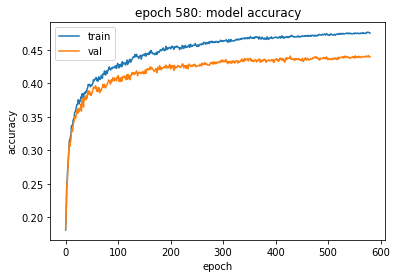



Epoch 581/2000 ...........
Loss train: 2.3272748825740526 
Loss val: 2.4286741573694135 
Train accuracy :  0.47505 
Validation accuracy :  0.4382
Alpha:  0.2174051885163324


Epoch 582/2000 ...........
Loss train: 2.32664261643626 
Loss val: 2.4282428147246535 
Train accuracy :  0.4757 
Validation accuracy :  0.4384
Alpha:  0.21631816257375072


Epoch 583/2000 ...........
Loss train: 2.326898121840282 
Loss val: 2.4289621933750896 
Train accuracy :  0.474675 
Validation accuracy :  0.4388
Alpha:  0.21523657176088196


Epoch 584/2000 ...........
Loss train: 2.3269079415899725 
Loss val: 2.4287775119928905 
Train accuracy :  0.474625 
Validation accuracy :  0.4391
Alpha:  0.21416038890207756


Epoch 585/2000 ...........
Loss train: 2.3267403089985357 
Loss val: 2.429136698143937 
Train accuracy :  0.47435 
Validation accuracy :  0.4389
Alpha:  0.21308958695756716


Epoch 586/2000 ...........
Loss train: 2.3260012482118673 
Loss val: 2.428463347612378 
Train accuracy :  0.47415 
Validat

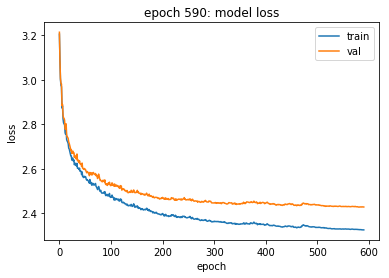

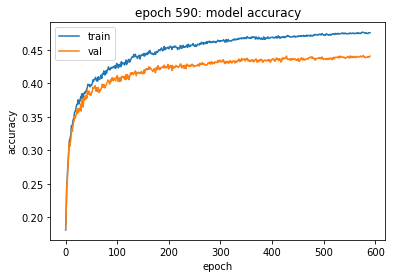



Epoch 591/2000 ...........
Loss train: 2.325317384397082 
Loss val: 2.4280762374235962 
Train accuracy :  0.475625 
Validation accuracy :  0.4391
Alpha:  0.20677627721370465


Epoch 592/2000 ...........
Loss train: 2.3250272903521423 
Loss val: 2.4275923434983175 
Train accuracy :  0.4753 
Validation accuracy :  0.4413
Alpha:  0.20574239582763612


Epoch 593/2000 ...........
Loss train: 2.3248546895113074 
Loss val: 2.4277927471732466 
Train accuracy :  0.476425 
Validation accuracy :  0.4395
Alpha:  0.20471368384849795


Epoch 594/2000 ...........
Loss train: 2.325183773390698 
Loss val: 2.427856623605587 
Train accuracy :  0.476 
Validation accuracy :  0.4395
Alpha:  0.20369011542925544


Epoch 595/2000 ...........
Loss train: 2.325261156874863 
Loss val: 2.4281688473334753 
Train accuracy :  0.476 
Validation accuracy :  0.4379
Alpha:  0.20267166485210916


Epoch 596/2000 ...........
Loss train: 2.324999449670831 
Loss val: 2.42766885345513 
Train accuracy :  0.4763 
Validation ac

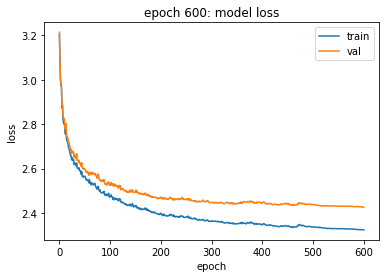

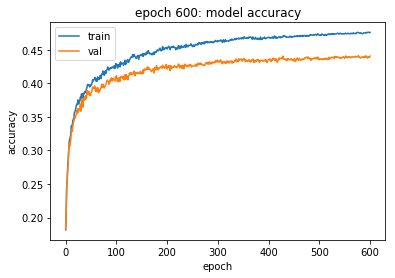



Epoch 601/2000 ...........
Loss train: 2.3241357977312362 
Loss val: 2.426310055170853 
Train accuracy :  0.475575 
Validation accuracy :  0.4406
Alpha:  0.2


Epoch 602/2000 ...........
Loss train: 2.32419982076668 
Loss val: 2.425823493300041 
Train accuracy :  0.476375 
Validation accuracy :  0.4404
Alpha:  0.2


Epoch 603/2000 ...........
Loss train: 2.3247347507211367 
Loss val: 2.426001595009178 
Train accuracy :  0.47585 
Validation accuracy :  0.4404
Alpha:  0.2


Epoch 604/2000 ...........
Loss train: 2.3248322571870297 
Loss val: 2.425993878019905 
Train accuracy :  0.476025 
Validation accuracy :  0.441
Alpha:  0.2


Epoch 605/2000 ...........
Loss train: 2.3247521301746708 
Loss val: 2.4260130912741817 
Train accuracy :  0.4756 
Validation accuracy :  0.4418
Alpha:  0.2


Epoch 606/2000 ...........
Loss train: 2.3246870961877457 
Loss val: 2.4261020216118845 
Train accuracy :  0.476475 
Validation accuracy :  0.441
Alpha:  0.2


Epoch 607/2000 ...........
Loss train: 2.32

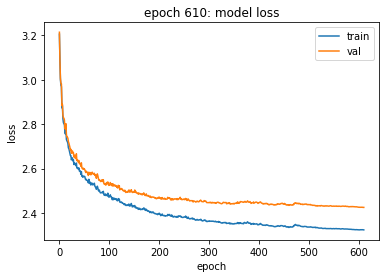

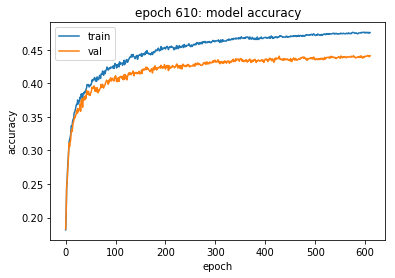



Epoch 611/2000 ...........
Loss train: 2.324194745705173 
Loss val: 2.4251909278013524 
Train accuracy :  0.4754 
Validation accuracy :  0.4415
Alpha:  0.2


Epoch 612/2000 ...........
Loss train: 2.3241732293132085 
Loss val: 2.4251486630283305 
Train accuracy :  0.474825 
Validation accuracy :  0.4416
Alpha:  0.2


Epoch 613/2000 ...........
Loss train: 2.3237844257062354 
Loss val: 2.424805377834948 
Train accuracy :  0.475425 
Validation accuracy :  0.4418
Alpha:  0.2


Epoch 614/2000 ...........
Loss train: 2.324079848631699 
Loss val: 2.4251212335428556 
Train accuracy :  0.47515 
Validation accuracy :  0.4414
Alpha:  0.2


Epoch 615/2000 ...........
Loss train: 2.3241138225819866 
Loss val: 2.4252814561863802 
Train accuracy :  0.475325 
Validation accuracy :  0.441
Alpha:  0.2


Epoch 616/2000 ...........
Loss train: 2.3243629102491203 
Loss val: 2.425500928885957 
Train accuracy :  0.475875 
Validation accuracy :  0.4405
Alpha:  0.2


Epoch 617/2000 ...........
Loss train: 2

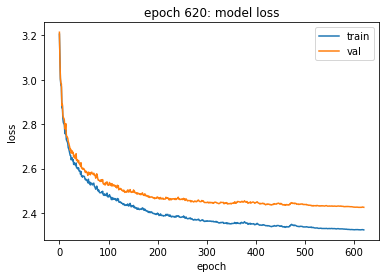

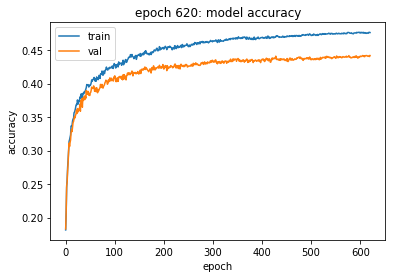



Epoch 621/2000 ...........
Loss train: 2.324042849359098 
Loss val: 2.4262354322958495 
Train accuracy :  0.4761 
Validation accuracy :  0.4396
Alpha:  0.2


Epoch 622/2000 ...........
Loss train: 2.323927498133362 
Loss val: 2.4262133618183848 
Train accuracy :  0.475325 
Validation accuracy :  0.4402
Alpha:  0.2


Epoch 623/2000 ...........
Loss train: 2.324014774331233 
Loss val: 2.426178574567856 
Train accuracy :  0.4765 
Validation accuracy :  0.4413
Alpha:  0.2


Epoch 624/2000 ...........
Loss train: 2.3242805228079217 
Loss val: 2.426420183538956 
Train accuracy :  0.4756 
Validation accuracy :  0.4396
Alpha:  0.2


Epoch 625/2000 ...........
Loss train: 2.3246493335607537 
Loss val: 2.426239029836559 
Train accuracy :  0.476 
Validation accuracy :  0.4417
Alpha:  0.2


Epoch 626/2000 ...........
Loss train: 2.3246338349262015 
Loss val: 2.425980089798768 
Train accuracy :  0.47595 
Validation accuracy :  0.4413
Alpha:  0.2


Epoch 627/2000 ...........
Loss train: 2.32430581

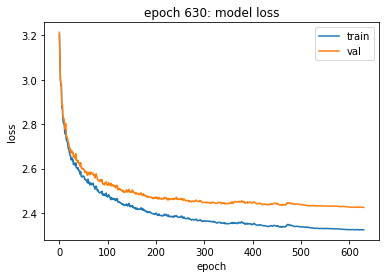

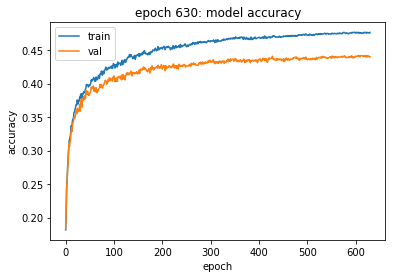



Epoch 631/2000 ...........
Loss train: 2.323207339648567 
Loss val: 2.424531815439639 
Train accuracy :  0.476325 
Validation accuracy :  0.4413
Alpha:  0.2


Epoch 632/2000 ...........
Loss train: 2.323431893471921 
Loss val: 2.4251659190031867 
Train accuracy :  0.4753 
Validation accuracy :  0.4409
Alpha:  0.2


Epoch 633/2000 ...........
Loss train: 2.322885674521401 
Loss val: 2.4246717479364674 
Train accuracy :  0.47575 
Validation accuracy :  0.4398
Alpha:  0.2


Epoch 634/2000 ...........
Loss train: 2.3225108781525705 
Loss val: 2.4236132994295323 
Train accuracy :  0.47605 
Validation accuracy :  0.4413
Alpha:  0.2


Epoch 635/2000 ...........
Loss train: 2.3223584380759594 
Loss val: 2.4239160559058486 
Train accuracy :  0.47625 
Validation accuracy :  0.4402
Alpha:  0.2


Epoch 636/2000 ...........
Loss train: 2.322607820471506 
Loss val: 2.4241736140272527 
Train accuracy :  0.4757 
Validation accuracy :  0.4416
Alpha:  0.2


Epoch 637/2000 ...........
Loss train: 2.323

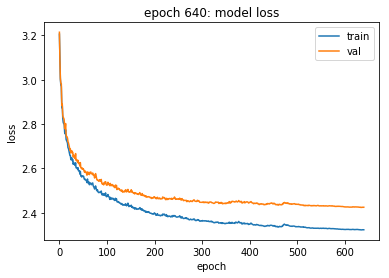

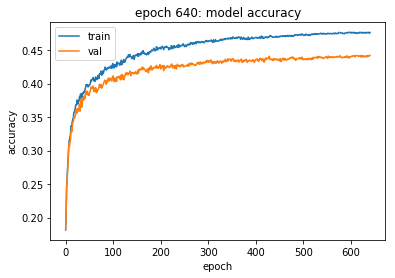



Epoch 641/2000 ...........
Loss train: 2.323367461913451 
Loss val: 2.425339884795871 
Train accuracy :  0.476075 
Validation accuracy :  0.4402
Alpha:  0.2


Epoch 642/2000 ...........
Loss train: 2.324040116655422 
Loss val: 2.4251512371174715 
Train accuracy :  0.476425 
Validation accuracy :  0.4425
Alpha:  0.2


Epoch 643/2000 ...........
Loss train: 2.324594700632979 
Loss val: 2.426256614602762 
Train accuracy :  0.4767 
Validation accuracy :  0.4412
Alpha:  0.2


Epoch 644/2000 ...........
Loss train: 2.324947660260054 
Loss val: 2.4273418592603972 
Train accuracy :  0.47615 
Validation accuracy :  0.4407
Alpha:  0.2


Epoch 645/2000 ...........
Loss train: 2.324586186577618 
Loss val: 2.4262637663308557 
Train accuracy :  0.475375 
Validation accuracy :  0.4419
Alpha:  0.2


Epoch 646/2000 ...........
Loss train: 2.324849758537606 
Loss val: 2.4266395984716596 
Train accuracy :  0.476025 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 647/2000 ...........
Loss train: 2.32

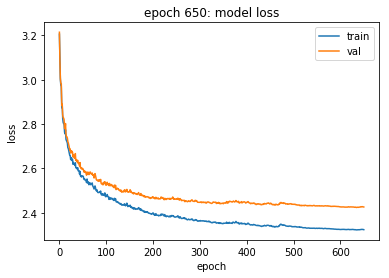

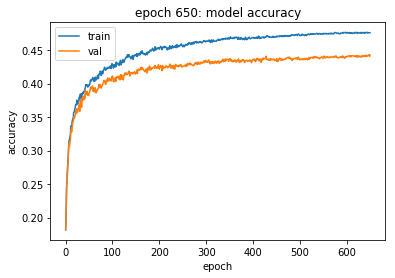



Epoch 651/2000 ...........
Loss train: 2.323222078297833 
Loss val: 2.425285930557339 
Train accuracy :  0.47675 
Validation accuracy :  0.4413
Alpha:  0.2


Epoch 652/2000 ...........
Loss train: 2.3226795461860057 
Loss val: 2.424892956248051 
Train accuracy :  0.476225 
Validation accuracy :  0.443
Alpha:  0.2


Epoch 653/2000 ...........
Loss train: 2.323144675663039 
Loss val: 2.4255412248765778 
Train accuracy :  0.47575 
Validation accuracy :  0.4429
Alpha:  0.2


Epoch 654/2000 ...........
Loss train: 2.323635637241336 
Loss val: 2.4267560808701614 
Train accuracy :  0.4758 
Validation accuracy :  0.4427
Alpha:  0.2


Epoch 655/2000 ...........
Loss train: 2.3234935466344364 
Loss val: 2.4270299376828843 
Train accuracy :  0.4757 
Validation accuracy :  0.4425
Alpha:  0.2


Epoch 656/2000 ...........
Loss train: 2.3240821836510928 
Loss val: 2.4271104661471927 
Train accuracy :  0.476 
Validation accuracy :  0.4428
Alpha:  0.2


Epoch 657/2000 ...........
Loss train: 2.323920

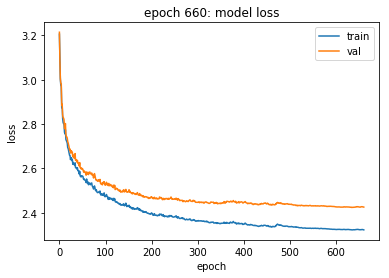

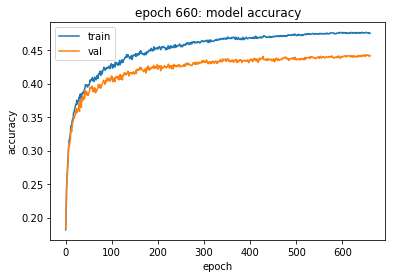



Epoch 661/2000 ...........
Loss train: 2.32310727226091 
Loss val: 2.4255950069045915 
Train accuracy :  0.47515 
Validation accuracy :  0.4415
Alpha:  0.2


Epoch 662/2000 ...........
Loss train: 2.322973009208845 
Loss val: 2.4260241524046386 
Train accuracy :  0.47545 
Validation accuracy :  0.4426
Alpha:  0.2


Epoch 663/2000 ...........
Loss train: 2.3220729601257086 
Loss val: 2.424441735810293 
Train accuracy :  0.475625 
Validation accuracy :  0.4423
Alpha:  0.2


Epoch 664/2000 ...........
Loss train: 2.3219156444886173 
Loss val: 2.4238204876690417 
Train accuracy :  0.476175 
Validation accuracy :  0.4427
Alpha:  0.2


Epoch 665/2000 ...........
Loss train: 2.322109426293442 
Loss val: 2.423972870439891 
Train accuracy :  0.476725 
Validation accuracy :  0.4425
Alpha:  0.2


Epoch 666/2000 ...........
Loss train: 2.3226425030961253 
Loss val: 2.424236054910773 
Train accuracy :  0.4766 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 667/2000 ...........
Loss train: 2.32

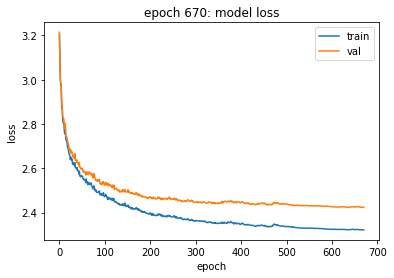

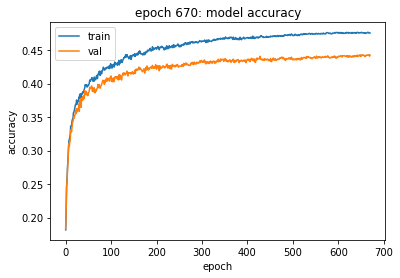



Epoch 671/2000 ...........
Loss train: 2.3215114865474353 
Loss val: 2.4232438763096407 
Train accuracy :  0.4764 
Validation accuracy :  0.4424
Alpha:  0.2


Epoch 672/2000 ...........
Loss train: 2.3215617637776433 
Loss val: 2.4241829617518733 
Train accuracy :  0.4761 
Validation accuracy :  0.4425
Alpha:  0.2


Epoch 673/2000 ...........
Loss train: 2.32156946408141 
Loss val: 2.424098899209573 
Train accuracy :  0.475975 
Validation accuracy :  0.442
Alpha:  0.2


Epoch 674/2000 ...........
Loss train: 2.3221088474094445 
Loss val: 2.4245195699965114 
Train accuracy :  0.4756 
Validation accuracy :  0.4424
Alpha:  0.2


Epoch 675/2000 ...........
Loss train: 2.3224046246578465 
Loss val: 2.4250044179341868 
Train accuracy :  0.47585 
Validation accuracy :  0.4424
Alpha:  0.2


Epoch 676/2000 ...........
Loss train: 2.322344787233109 
Loss val: 2.424848693542769 
Train accuracy :  0.476275 
Validation accuracy :  0.4406
Alpha:  0.2


Epoch 677/2000 ...........
Loss train: 2.3223

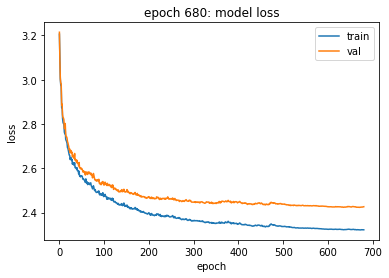

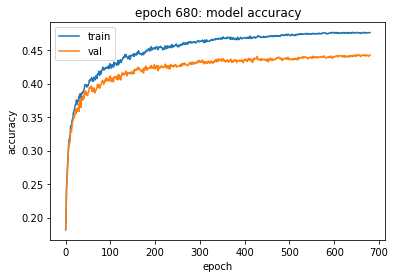



Epoch 681/2000 ...........
Loss train: 2.3218819686034746 
Loss val: 2.4258474241850516 
Train accuracy :  0.475925 
Validation accuracy :  0.4434
Alpha:  0.2


Epoch 682/2000 ...........
Loss train: 2.3214264002554654 
Loss val: 2.4254864069699 
Train accuracy :  0.476125 
Validation accuracy :  0.443
Alpha:  0.2


Epoch 683/2000 ...........
Loss train: 2.32119885750833 
Loss val: 2.42530068129821 
Train accuracy :  0.476175 
Validation accuracy :  0.442
Alpha:  0.2


Epoch 684/2000 ...........
Loss train: 2.3209709260460665 
Loss val: 2.424783409907247 
Train accuracy :  0.475875 
Validation accuracy :  0.4419
Alpha:  0.2


Epoch 685/2000 ...........
Loss train: 2.320167102466984 
Loss val: 2.424220354191632 
Train accuracy :  0.47695 
Validation accuracy :  0.4435
Alpha:  0.2


Epoch 686/2000 ...........
Loss train: 2.320167709434539 
Loss val: 2.424306024910391 
Train accuracy :  0.4764 
Validation accuracy :  0.4426
Alpha:  0.2


Epoch 687/2000 ...........
Loss train: 2.32019263

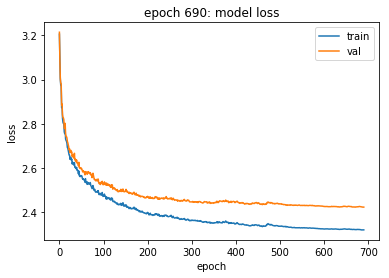

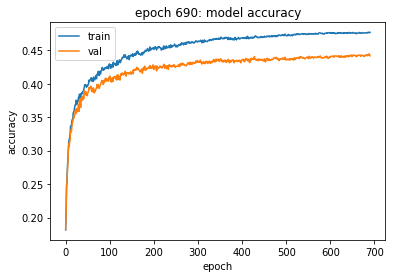



Epoch 691/2000 ...........
Loss train: 2.3199800149803904 
Loss val: 2.422571909633692 
Train accuracy :  0.47635 
Validation accuracy :  0.4432
Alpha:  0.2


Epoch 692/2000 ...........
Loss train: 2.3201319981377257 
Loss val: 2.4224813686797684 
Train accuracy :  0.476525 
Validation accuracy :  0.4412
Alpha:  0.2


Epoch 693/2000 ...........
Loss train: 2.3205621540728254 
Loss val: 2.422358465377319 
Train accuracy :  0.476975 
Validation accuracy :  0.4419
Alpha:  0.2


Epoch 694/2000 ...........
Loss train: 2.320242912024709 
Loss val: 2.4217373522381878 
Train accuracy :  0.476825 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 695/2000 ...........
Loss train: 2.3198657316123974 
Loss val: 2.4222222164574685 
Train accuracy :  0.4764 
Validation accuracy :  0.4415
Alpha:  0.2


Epoch 696/2000 ...........
Loss train: 2.3196716305359684 
Loss val: 2.4216518586615168 
Train accuracy :  0.4758 
Validation accuracy :  0.4423
Alpha:  0.2


Epoch 697/2000 ...........
Loss train: 2

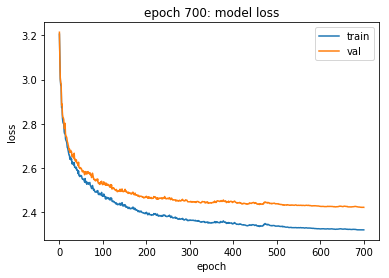

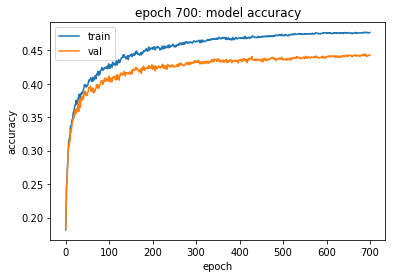



Epoch 701/2000 ...........
Loss train: 2.3199238391919783 
Loss val: 2.4215151889837396 
Train accuracy :  0.4769 
Validation accuracy :  0.4428
Alpha:  0.2


Epoch 702/2000 ...........
Loss train: 2.3206417129881403 
Loss val: 2.4213555660700585 
Train accuracy :  0.4757 
Validation accuracy :  0.441
Alpha:  0.2


Epoch 703/2000 ...........
Loss train: 2.3196725742857516 
Loss val: 2.4206729221799264 
Train accuracy :  0.476725 
Validation accuracy :  0.4429
Alpha:  0.2


Epoch 704/2000 ...........
Loss train: 2.3201738870393025 
Loss val: 2.4212684579630217 
Train accuracy :  0.4763 
Validation accuracy :  0.4411
Alpha:  0.2


Epoch 705/2000 ...........
Loss train: 2.3204513780479976 
Loss val: 2.421243080215321 
Train accuracy :  0.475625 
Validation accuracy :  0.441
Alpha:  0.2


Epoch 706/2000 ...........
Loss train: 2.3206918109796395 
Loss val: 2.4209939248375516 
Train accuracy :  0.475925 
Validation accuracy :  0.4411
Alpha:  0.2


Epoch 707/2000 ...........
Loss train: 2.

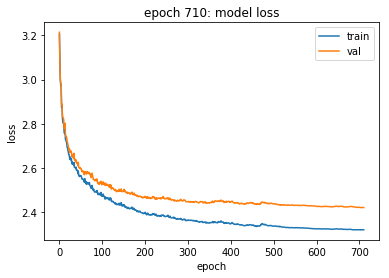

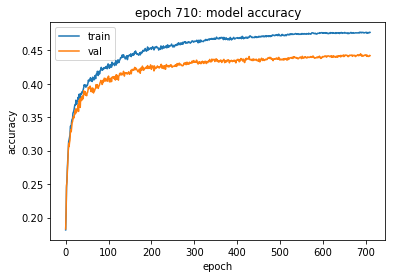



Epoch 711/2000 ...........
Loss train: 2.3201512872428416 
Loss val: 2.4215169325028785 
Train accuracy :  0.47595 
Validation accuracy :  0.4421
Alpha:  0.2


Epoch 712/2000 ...........
Loss train: 2.319523091771393 
Loss val: 2.4211769117620623 
Train accuracy :  0.476425 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 713/2000 ...........
Loss train: 2.319292479076789 
Loss val: 2.420804274908528 
Train accuracy :  0.476075 
Validation accuracy :  0.4427
Alpha:  0.2


Epoch 714/2000 ...........
Loss train: 2.3192620440072282 
Loss val: 2.421468184862454 
Train accuracy :  0.47545 
Validation accuracy :  0.4427
Alpha:  0.2


Epoch 715/2000 ...........
Loss train: 2.318928211574697 
Loss val: 2.421023530212221 
Train accuracy :  0.4768 
Validation accuracy :  0.4425
Alpha:  0.2


Epoch 716/2000 ...........
Loss train: 2.3186411366687705 
Loss val: 2.4203832692628757 
Train accuracy :  0.476475 
Validation accuracy :  0.4427
Alpha:  0.2


Epoch 717/2000 ...........
Loss train: 2.3

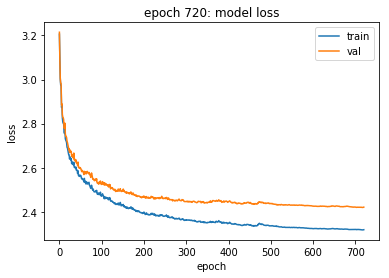

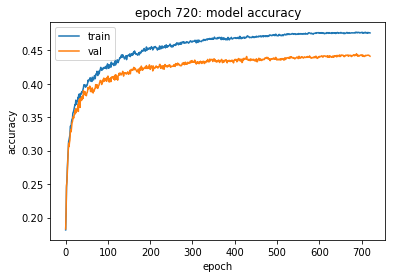



Epoch 721/2000 ...........
Loss train: 2.3194718662545424 
Loss val: 2.421877582969093 
Train accuracy :  0.47585 
Validation accuracy :  0.4415
Alpha:  0.2


Epoch 722/2000 ...........
Loss train: 2.3197610460582574 
Loss val: 2.4226611443205694 
Train accuracy :  0.476275 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 723/2000 ...........
Loss train: 2.3199700884430268 
Loss val: 2.4226531223108694 
Train accuracy :  0.475875 
Validation accuracy :  0.4419
Alpha:  0.2


Epoch 724/2000 ...........
Loss train: 2.3195422284954317 
Loss val: 2.4221445110447632 
Train accuracy :  0.476575 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 725/2000 ...........
Loss train: 2.3192803931632078 
Loss val: 2.4218396698253333 
Train accuracy :  0.4761 
Validation accuracy :  0.4412
Alpha:  0.2


Epoch 726/2000 ...........
Loss train: 2.31930520631391 
Loss val: 2.4214965115258846 
Train accuracy :  0.476175 
Validation accuracy :  0.4414
Alpha:  0.2


Epoch 727/2000 ...........
Loss train:

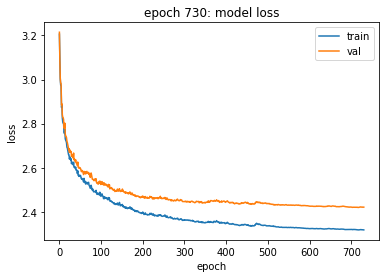

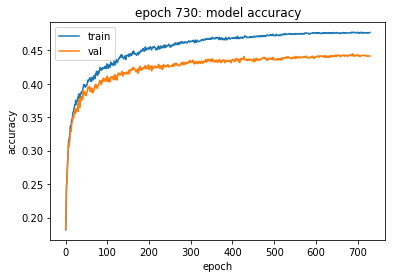



Epoch 731/2000 ...........
Loss train: 2.318548028536155 
Loss val: 2.4211932167517456 
Train accuracy :  0.477075 
Validation accuracy :  0.4423
Alpha:  0.2


Epoch 732/2000 ...........
Loss train: 2.31808763877433 
Loss val: 2.420401352784692 
Train accuracy :  0.476975 
Validation accuracy :  0.4412
Alpha:  0.2


Epoch 733/2000 ...........
Loss train: 2.318416149182976 
Loss val: 2.421372198372942 
Train accuracy :  0.477 
Validation accuracy :  0.4417
Alpha:  0.2


Epoch 734/2000 ...........
Loss train: 2.317905229318191 
Loss val: 2.420342394544069 
Train accuracy :  0.477325 
Validation accuracy :  0.4418
Alpha:  0.2


Epoch 735/2000 ...........
Loss train: 2.318113505202416 
Loss val: 2.420530783993327 
Train accuracy :  0.47625 
Validation accuracy :  0.4424
Alpha:  0.2


Epoch 736/2000 ...........
Loss train: 2.3179848426903185 
Loss val: 2.4209598312303306 
Train accuracy :  0.47755 
Validation accuracy :  0.4424
Alpha:  0.2


Epoch 737/2000 ...........
Loss train: 2.318674

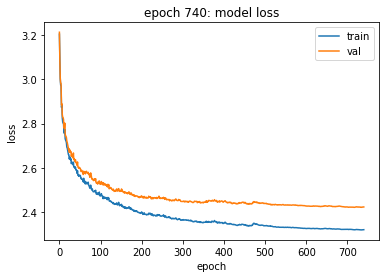

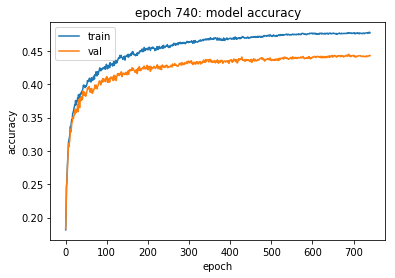



Epoch 741/2000 ...........
Loss train: 2.319014224012749 
Loss val: 2.4217811635963824 
Train accuracy :  0.476675 
Validation accuracy :  0.4432
Alpha:  0.2


Epoch 742/2000 ...........
Loss train: 2.318964288372671 
Loss val: 2.4220847806691452 
Train accuracy :  0.476775 
Validation accuracy :  0.4431
Alpha:  0.2


Epoch 743/2000 ...........
Loss train: 2.318814644553034 
Loss val: 2.4222613204132974 
Train accuracy :  0.477125 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 744/2000 ...........
Loss train: 2.318659833170347 
Loss val: 2.4221466492941253 
Train accuracy :  0.47675 
Validation accuracy :  0.4429
Alpha:  0.2


Epoch 745/2000 ...........
Loss train: 2.3188959497752397 
Loss val: 2.422269389452326 
Train accuracy :  0.477475 
Validation accuracy :  0.4442
Alpha:  0.2


Epoch 746/2000 ...........
Loss train: 2.3183385995679897 
Loss val: 2.420990843145267 
Train accuracy :  0.4777 
Validation accuracy :  0.4432
Alpha:  0.2


Epoch 747/2000 ...........
Loss train: 2.

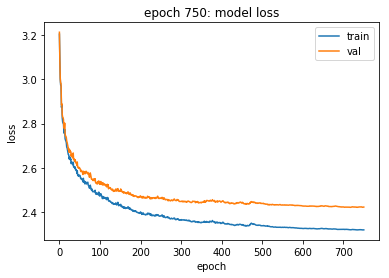

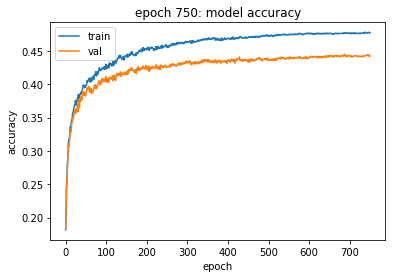



Epoch 751/2000 ...........
Loss train: 2.317922074031445 
Loss val: 2.4211102867965004 
Train accuracy :  0.477075 
Validation accuracy :  0.4413
Alpha:  0.2


Epoch 752/2000 ...........
Loss train: 2.3172046292298973 
Loss val: 2.4202464204589647 
Train accuracy :  0.477375 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 753/2000 ...........
Loss train: 2.3169797119193425 
Loss val: 2.4204287125760127 
Train accuracy :  0.4774 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 754/2000 ...........
Loss train: 2.317500171337045 
Loss val: 2.420936105440274 
Train accuracy :  0.47695 
Validation accuracy :  0.4434
Alpha:  0.2


Epoch 755/2000 ...........
Loss train: 2.316956643122533 
Loss val: 2.4195866556055083 
Train accuracy :  0.47675 
Validation accuracy :  0.443
Alpha:  0.2


Epoch 756/2000 ...........
Loss train: 2.317011056911919 
Loss val: 2.4195019066724353 
Train accuracy :  0.476975 
Validation accuracy :  0.4423
Alpha:  0.2


Epoch 757/2000 ...........
Loss train: 2.3

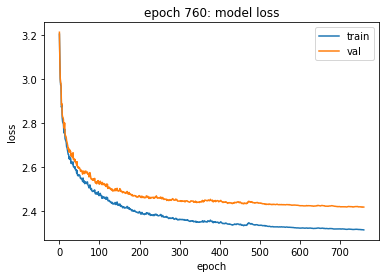

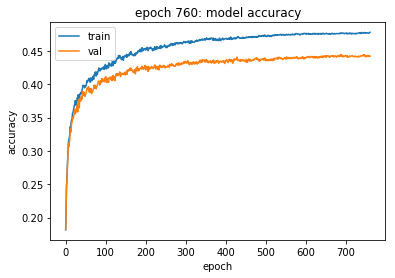



Epoch 761/2000 ...........
Loss train: 2.3163083992181193 
Loss val: 2.419812420032278 
Train accuracy :  0.478175 
Validation accuracy :  0.4442
Alpha:  0.2


Epoch 762/2000 ...........
Loss train: 2.3160685069074183 
Loss val: 2.419550188038228 
Train accuracy :  0.4781 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 763/2000 ...........
Loss train: 2.31636359025642 
Loss val: 2.4202694083920333 
Train accuracy :  0.478225 
Validation accuracy :  0.4435
Alpha:  0.2


Epoch 764/2000 ...........
Loss train: 2.316438933017111 
Loss val: 2.420206275146413 
Train accuracy :  0.477625 
Validation accuracy :  0.4435
Alpha:  0.2


Epoch 765/2000 ...........
Loss train: 2.3164032495360836 
Loss val: 2.4207531079739604 
Train accuracy :  0.477075 
Validation accuracy :  0.4434
Alpha:  0.2


Epoch 766/2000 ...........
Loss train: 2.3161635551177433 
Loss val: 2.420121630519194 
Train accuracy :  0.476925 
Validation accuracy :  0.4448
Alpha:  0.2


Epoch 767/2000 ...........
Loss train: 2.

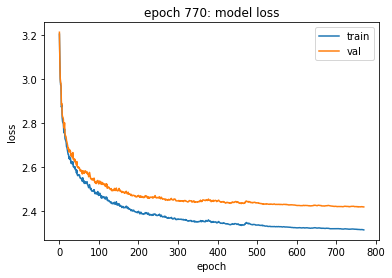

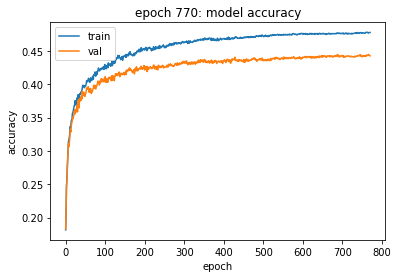



Epoch 771/2000 ...........
Loss train: 2.315329806341924 
Loss val: 2.41968934925013 
Train accuracy :  0.477 
Validation accuracy :  0.444
Alpha:  0.2


Epoch 772/2000 ...........
Loss train: 2.314747163769406 
Loss val: 2.4190310457535857 
Train accuracy :  0.477225 
Validation accuracy :  0.4426
Alpha:  0.2


Epoch 773/2000 ...........
Loss train: 2.3145956764703075 
Loss val: 2.4195103762214534 
Train accuracy :  0.4778 
Validation accuracy :  0.4432
Alpha:  0.2


Epoch 774/2000 ...........
Loss train: 2.3147374729282553 
Loss val: 2.4190539213192404 
Train accuracy :  0.477825 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 775/2000 ...........
Loss train: 2.314442525247596 
Loss val: 2.4189645990749113 
Train accuracy :  0.477625 
Validation accuracy :  0.4433
Alpha:  0.2


Epoch 776/2000 ...........
Loss train: 2.314413927133801 
Loss val: 2.4192072001277016 
Train accuracy :  0.47735 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 777/2000 ...........
Loss train: 2.3145

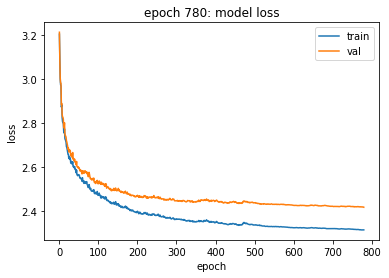

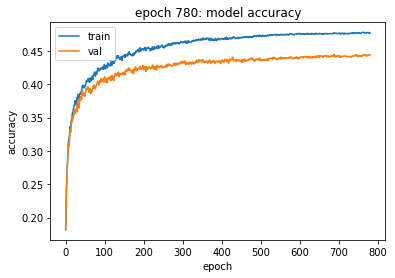



Epoch 781/2000 ...........
Loss train: 2.3151355863057095 
Loss val: 2.418409569134271 
Train accuracy :  0.4774 
Validation accuracy :  0.4432
Alpha:  0.2


Epoch 782/2000 ...........
Loss train: 2.314531451093145 
Loss val: 2.4182346767333573 
Train accuracy :  0.477375 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 783/2000 ...........
Loss train: 2.314750489356719 
Loss val: 2.418372308347227 
Train accuracy :  0.4773 
Validation accuracy :  0.445
Alpha:  0.2


Epoch 784/2000 ...........
Loss train: 2.314560247796129 
Loss val: 2.4184828787686534 
Train accuracy :  0.47705 
Validation accuracy :  0.4446
Alpha:  0.2


Epoch 785/2000 ...........
Loss train: 2.3148182082472175 
Loss val: 2.4185540477469316 
Train accuracy :  0.4771 
Validation accuracy :  0.4433
Alpha:  0.2


Epoch 786/2000 ...........
Loss train: 2.314978483077455 
Loss val: 2.418637687236642 
Train accuracy :  0.47695 
Validation accuracy :  0.4433
Alpha:  0.2


Epoch 787/2000 ...........
Loss train: 2.3142706

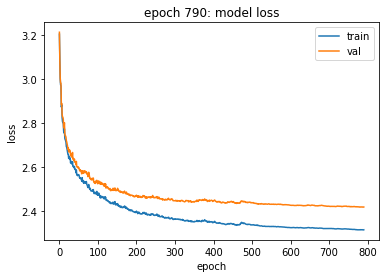

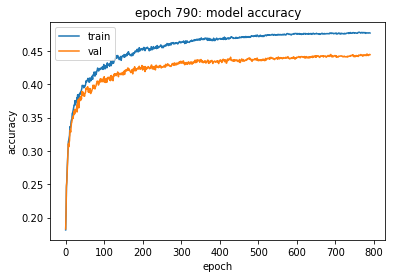



Epoch 791/2000 ...........
Loss train: 2.31402314957638 
Loss val: 2.418182456251337 
Train accuracy :  0.476575 
Validation accuracy :  0.4433
Alpha:  0.2


Epoch 792/2000 ...........
Loss train: 2.31446351395223 
Loss val: 2.41861984381565 
Train accuracy :  0.4768 
Validation accuracy :  0.4435
Alpha:  0.2


Epoch 793/2000 ...........
Loss train: 2.3142246499257837 
Loss val: 2.418875527396962 
Train accuracy :  0.47665 
Validation accuracy :  0.444
Alpha:  0.2


Epoch 794/2000 ...........
Loss train: 2.3138363673339923 
Loss val: 2.418883537601954 
Train accuracy :  0.47745 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 795/2000 ...........
Loss train: 2.3138116155167814 
Loss val: 2.4190748707963574 
Train accuracy :  0.477475 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 796/2000 ...........
Loss train: 2.313661865335939 
Loss val: 2.419589924929097 
Train accuracy :  0.477925 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 797/2000 ...........
Loss train: 2.3139104

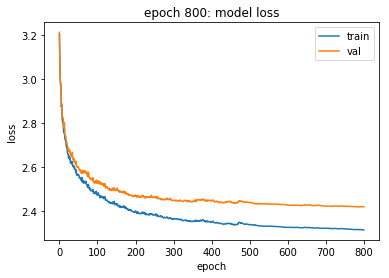

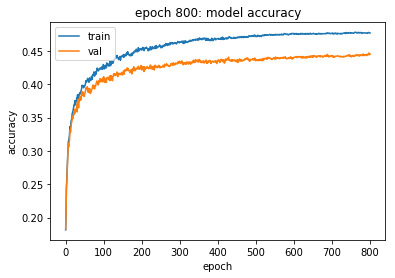



Epoch 801/2000 ...........
Loss train: 2.3129910433895255 
Loss val: 2.4174960456397483 
Train accuracy :  0.477725 
Validation accuracy :  0.4454
Alpha:  0.2


Epoch 802/2000 ...........
Loss train: 2.3128644781198417 
Loss val: 2.4175504035739066 
Train accuracy :  0.477275 
Validation accuracy :  0.4448
Alpha:  0.2


Epoch 803/2000 ...........
Loss train: 2.3126989023303586 
Loss val: 2.4172938435204476 
Train accuracy :  0.4788 
Validation accuracy :  0.4451
Alpha:  0.2


Epoch 804/2000 ...........
Loss train: 2.3131475093744824 
Loss val: 2.4175485408862505 
Train accuracy :  0.477925 
Validation accuracy :  0.4441
Alpha:  0.2


Epoch 805/2000 ...........
Loss train: 2.3131938282478584 
Loss val: 2.4176411920664496 
Train accuracy :  0.478 
Validation accuracy :  0.4444
Alpha:  0.2


Epoch 806/2000 ...........
Loss train: 2.3130548072859978 
Loss val: 2.4177021918423476 
Train accuracy :  0.4781 
Validation accuracy :  0.4451
Alpha:  0.2


Epoch 807/2000 ...........
Loss train: 

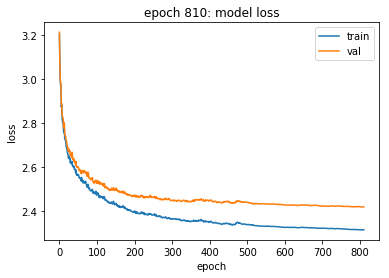

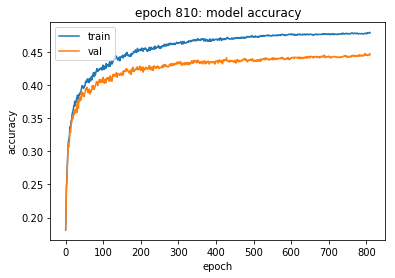



Epoch 811/2000 ...........
Loss train: 2.3136649537239804 
Loss val: 2.4177154098608455 
Train accuracy :  0.47815 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 812/2000 ...........
Loss train: 2.3144740987681374 
Loss val: 2.4179781565028664 
Train accuracy :  0.478525 
Validation accuracy :  0.4442
Alpha:  0.2


Epoch 813/2000 ...........
Loss train: 2.3143629205140375 
Loss val: 2.417899422473198 
Train accuracy :  0.478 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 814/2000 ...........
Loss train: 2.3148013897035336 
Loss val: 2.4184746773416146 
Train accuracy :  0.477875 
Validation accuracy :  0.4436
Alpha:  0.2


Epoch 815/2000 ...........
Loss train: 2.3150122436915157 
Loss val: 2.4190130119411597 
Train accuracy :  0.47725 
Validation accuracy :  0.4448
Alpha:  0.2


Epoch 816/2000 ...........
Loss train: 2.3145301876065876 
Loss val: 2.4186575483078965 
Train accuracy :  0.477475 
Validation accuracy :  0.4439
Alpha:  0.2


Epoch 817/2000 ...........
Loss train:

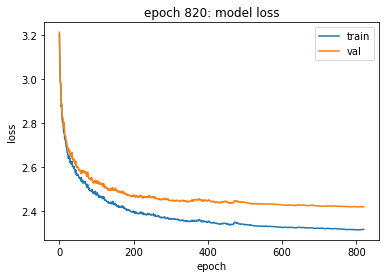

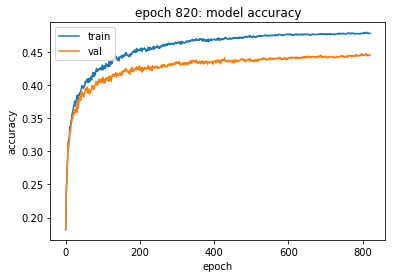



Epoch 821/2000 ...........
Loss train: 2.3142557656207248 
Loss val: 2.4179286724004827 
Train accuracy :  0.478125 
Validation accuracy :  0.4433
Alpha:  0.2


Epoch 822/2000 ...........
Loss train: 2.313908454713854 
Loss val: 2.41755210526968 
Train accuracy :  0.477925 
Validation accuracy :  0.445
Alpha:  0.2


Epoch 823/2000 ...........
Loss train: 2.313987434673929 
Loss val: 2.417863993813043 
Train accuracy :  0.47755 
Validation accuracy :  0.4446
Alpha:  0.2


Epoch 824/2000 ...........
Loss train: 2.3135188884359654 
Loss val: 2.4179402330018 
Train accuracy :  0.4773 
Validation accuracy :  0.4435
Alpha:  0.2


Epoch 825/2000 ...........
Loss train: 2.3131397259026447 
Loss val: 2.4174930128590355 
Train accuracy :  0.47815 
Validation accuracy :  0.4433
Alpha:  0.2


Epoch 826/2000 ...........
Loss train: 2.31300891402252 
Loss val: 2.417542667075303 
Train accuracy :  0.477825 
Validation accuracy :  0.444
Alpha:  0.2


Epoch 827/2000 ...........
Loss train: 2.31260187

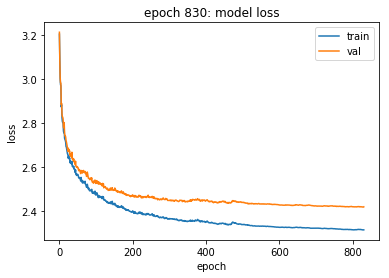

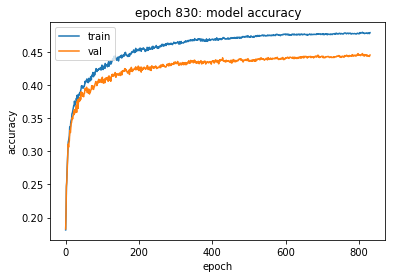



Epoch 831/2000 ...........
Loss train: 2.31252927391107 
Loss val: 2.417109477738628 
Train accuracy :  0.47855 
Validation accuracy :  0.4426
Alpha:  0.2


Epoch 832/2000 ...........
Loss train: 2.312649182383764 
Loss val: 2.4169652263870853 
Train accuracy :  0.478925 
Validation accuracy :  0.4429
Alpha:  0.2


Epoch 833/2000 ...........
Loss train: 2.31254055624701 
Loss val: 2.417104337012701 
Train accuracy :  0.47865 
Validation accuracy :  0.4436
Alpha:  0.2


Epoch 834/2000 ...........
Loss train: 2.312570448994904 
Loss val: 2.4169394769027264 
Train accuracy :  0.47875 
Validation accuracy :  0.4423
Alpha:  0.2


Epoch 835/2000 ...........
Loss train: 2.312761796732522 
Loss val: 2.4169728838030426 
Train accuracy :  0.478725 
Validation accuracy :  0.4427
Alpha:  0.2


Epoch 836/2000 ...........
Loss train: 2.31250204337637 
Loss val: 2.4168261235554653 
Train accuracy :  0.47925 
Validation accuracy :  0.4418
Alpha:  0.2


Epoch 837/2000 ...........
Loss train: 2.312510

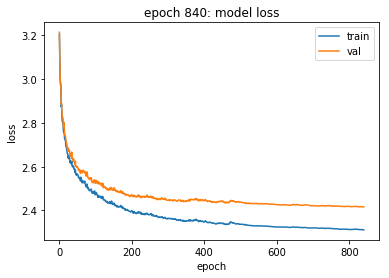

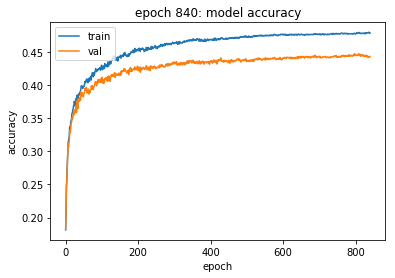



Epoch 841/2000 ...........
Loss train: 2.311134198252873 
Loss val: 2.4162684113824247 
Train accuracy :  0.478675 
Validation accuracy :  0.443
Alpha:  0.2


Epoch 842/2000 ...........
Loss train: 2.3107707644469473 
Loss val: 2.416469594363155 
Train accuracy :  0.4786 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 843/2000 ...........
Loss train: 2.3114246838293613 
Loss val: 2.417153222187877 
Train accuracy :  0.478175 
Validation accuracy :  0.4422
Alpha:  0.2


Epoch 844/2000 ...........
Loss train: 2.311139271247659 
Loss val: 2.417054900266988 
Train accuracy :  0.477825 
Validation accuracy :  0.4431
Alpha:  0.2


Epoch 845/2000 ...........
Loss train: 2.311099432816698 
Loss val: 2.416745514911389 
Train accuracy :  0.4778 
Validation accuracy :  0.4438
Alpha:  0.2


Epoch 846/2000 ...........
Loss train: 2.3109756153873526 
Loss val: 2.416931738356407 
Train accuracy :  0.478025 
Validation accuracy :  0.4449
Alpha:  0.2


Epoch 847/2000 ...........
Loss train: 2.3109

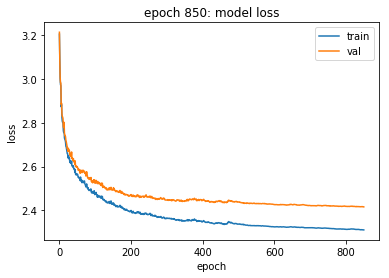

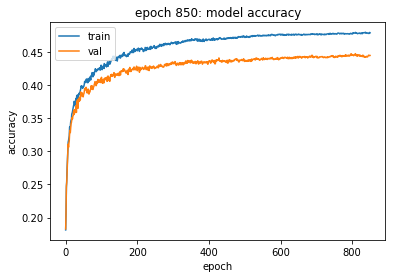



Epoch 851/2000 ...........
Loss train: 2.310193081963312 
Loss val: 2.416134490760932 
Train accuracy :  0.47885 
Validation accuracy :  0.4431
Alpha:  0.2


Epoch 852/2000 ...........
Loss train: 2.310169117559725 
Loss val: 2.416425025357989 
Train accuracy :  0.478175 
Validation accuracy :  0.4419
Alpha:  0.2


Epoch 853/2000 ...........
Loss train: 2.310227978133114 
Loss val: 2.4165681942940833 
Train accuracy :  0.4779 
Validation accuracy :  0.4417
Alpha:  0.2


Epoch 854/2000 ...........
Loss train: 2.3105018094665164 
Loss val: 2.416900898755792 
Train accuracy :  0.478225 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 855/2000 ...........
Loss train: 2.3104136865452203 
Loss val: 2.4166903222233334 
Train accuracy :  0.47855 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 856/2000 ...........
Loss train: 2.309921234044509 
Loss val: 2.4162548771976216 
Train accuracy :  0.47835 
Validation accuracy :  0.4428
Alpha:  0.2


Epoch 857/2000 ...........
Loss train: 2.310

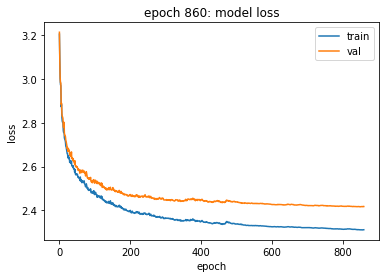

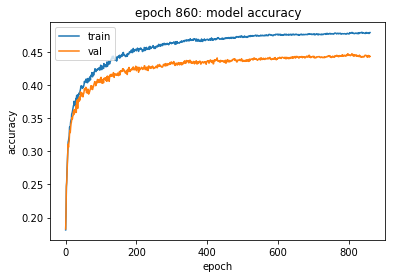



Epoch 861/2000 ...........
Loss train: 2.311159141279995 
Loss val: 2.4175291655807167 
Train accuracy :  0.478275 
Validation accuracy :  0.4438
Alpha:  0.2


Epoch 862/2000 ...........
Loss train: 2.3104856721928972 
Loss val: 2.4165641596080794 
Train accuracy :  0.4783 
Validation accuracy :  0.4448
Alpha:  0.2


Epoch 863/2000 ...........
Loss train: 2.310814163708649 
Loss val: 2.416953346988315 
Train accuracy :  0.47845 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 864/2000 ...........
Loss train: 2.310882646578486 
Loss val: 2.4180142501440915 
Train accuracy :  0.47725 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 865/2000 ...........
Loss train: 2.311117268205123 
Loss val: 2.417540924508407 
Train accuracy :  0.47775 
Validation accuracy :  0.4444
Alpha:  0.2


Epoch 866/2000 ...........
Loss train: 2.3111248914425637 
Loss val: 2.4173964765122347 
Train accuracy :  0.477525 
Validation accuracy :  0.4433
Alpha:  0.2


Epoch 867/2000 ...........
Loss train: 2.31

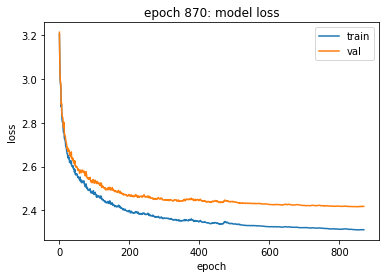

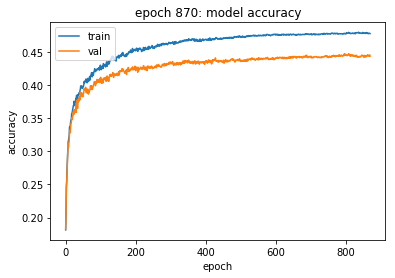



Epoch 871/2000 ...........
Loss train: 2.3109916952830534 
Loss val: 2.418291972938055 
Train accuracy :  0.477325 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 872/2000 ...........
Loss train: 2.310654344970687 
Loss val: 2.417812389115208 
Train accuracy :  0.477825 
Validation accuracy :  0.4455
Alpha:  0.2


Epoch 873/2000 ...........
Loss train: 2.31034327436728 
Loss val: 2.4169179871233677 
Train accuracy :  0.478075 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 874/2000 ...........
Loss train: 2.3102133967116267 
Loss val: 2.4163509274086135 
Train accuracy :  0.477775 
Validation accuracy :  0.4426
Alpha:  0.2


Epoch 875/2000 ...........
Loss train: 2.3107040909712984 
Loss val: 2.4168046812112958 
Train accuracy :  0.47715 
Validation accuracy :  0.4431
Alpha:  0.2


Epoch 876/2000 ...........
Loss train: 2.3105898059503702 
Loss val: 2.4163165020716706 
Train accuracy :  0.47715 
Validation accuracy :  0.4435
Alpha:  0.2


Epoch 877/2000 ...........
Loss train: 

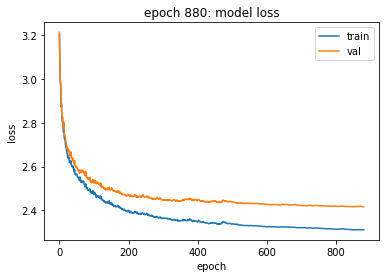

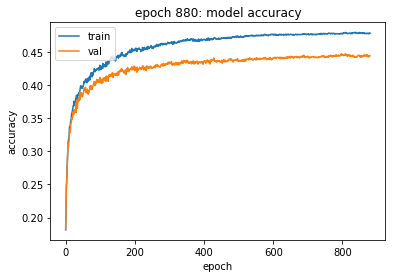



Epoch 881/2000 ...........
Loss train: 2.3110956393794484 
Loss val: 2.416591106404605 
Train accuracy :  0.477825 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 882/2000 ...........
Loss train: 2.310694415569902 
Loss val: 2.416877909881404 
Train accuracy :  0.477925 
Validation accuracy :  0.4435
Alpha:  0.2


Epoch 883/2000 ...........
Loss train: 2.3111840489499005 
Loss val: 2.4166738041614826 
Train accuracy :  0.4766 
Validation accuracy :  0.4414
Alpha:  0.2


Epoch 884/2000 ...........
Loss train: 2.31052878329614 
Loss val: 2.4163460589238905 
Train accuracy :  0.477375 
Validation accuracy :  0.4428
Alpha:  0.2


Epoch 885/2000 ...........
Loss train: 2.3107883794651416 
Loss val: 2.4165921000898702 
Train accuracy :  0.477925 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 886/2000 ...........
Loss train: 2.310463658000665 
Loss val: 2.4158657946420963 
Train accuracy :  0.4779 
Validation accuracy :  0.4425
Alpha:  0.2


Epoch 887/2000 ...........
Loss train: 2.3

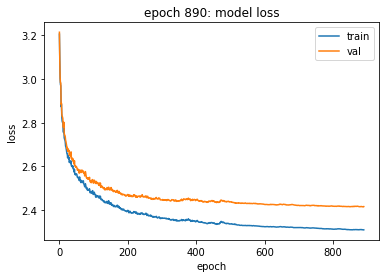

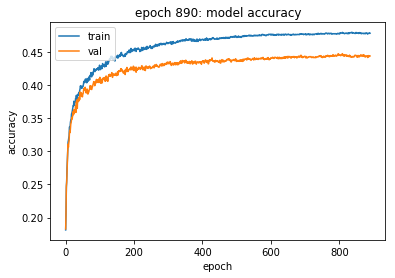



Epoch 891/2000 ...........
Loss train: 2.309812163002953 
Loss val: 2.4160186873440788 
Train accuracy :  0.47875 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 892/2000 ...........
Loss train: 2.3100296163379723 
Loss val: 2.416732363076849 
Train accuracy :  0.47815 
Validation accuracy :  0.4442
Alpha:  0.2


Epoch 893/2000 ...........
Loss train: 2.309914350858003 
Loss val: 2.4159693799635042 
Train accuracy :  0.478025 
Validation accuracy :  0.4432
Alpha:  0.2


Epoch 894/2000 ...........
Loss train: 2.30986411753856 
Loss val: 2.4157918335976616 
Train accuracy :  0.47855 
Validation accuracy :  0.4441
Alpha:  0.2


Epoch 895/2000 ...........
Loss train: 2.309575354662236 
Loss val: 2.415499488399041 
Train accuracy :  0.4774 
Validation accuracy :  0.4424
Alpha:  0.2


Epoch 896/2000 ...........
Loss train: 2.3094627311849707 
Loss val: 2.415932453112699 
Train accuracy :  0.4785 
Validation accuracy :  0.443
Alpha:  0.2


Epoch 897/2000 ...........
Loss train: 2.3092330

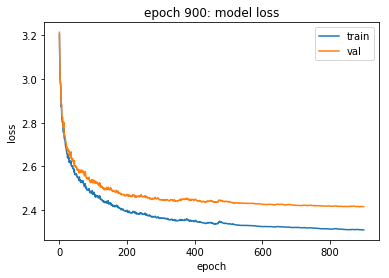

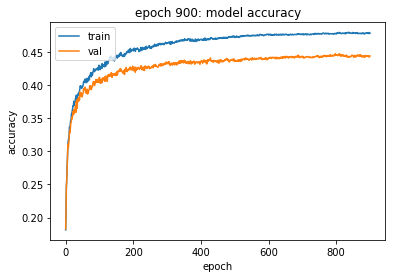



Epoch 901/2000 ...........
Loss train: 2.3092742649323736 
Loss val: 2.4160090803109133 
Train accuracy :  0.478275 
Validation accuracy :  0.4433
Alpha:  0.2


Epoch 902/2000 ...........
Loss train: 2.3089258596884563 
Loss val: 2.416405325672806 
Train accuracy :  0.4785 
Validation accuracy :  0.4429
Alpha:  0.2


Epoch 903/2000 ...........
Loss train: 2.3088774917211214 
Loss val: 2.4165225841865134 
Train accuracy :  0.477925 
Validation accuracy :  0.4441
Alpha:  0.2


Epoch 904/2000 ...........
Loss train: 2.3086422356407668 
Loss val: 2.4158994889283147 
Train accuracy :  0.478675 
Validation accuracy :  0.4442
Alpha:  0.2


Epoch 905/2000 ...........
Loss train: 2.3087720157685903 
Loss val: 2.4153424742998437 
Train accuracy :  0.478775 
Validation accuracy :  0.4442
Alpha:  0.2


Epoch 906/2000 ...........
Loss train: 2.3086312798591178 
Loss val: 2.416151160486859 
Train accuracy :  0.4782 
Validation accuracy :  0.4428
Alpha:  0.2


Epoch 907/2000 ...........
Loss train:

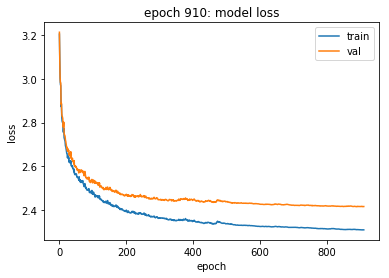

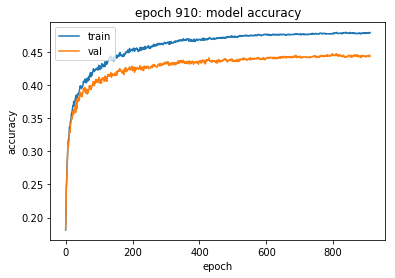



Epoch 911/2000 ...........
Loss train: 2.3085982710529214 
Loss val: 2.4153852175559947 
Train accuracy :  0.47795 
Validation accuracy :  0.4435
Alpha:  0.2


Epoch 912/2000 ...........
Loss train: 2.3083594239726657 
Loss val: 2.4151745445025643 
Train accuracy :  0.478875 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 913/2000 ...........
Loss train: 2.3088400288137882 
Loss val: 2.4163016096711365 
Train accuracy :  0.4778 
Validation accuracy :  0.4444
Alpha:  0.2


Epoch 914/2000 ...........
Loss train: 2.308318194670518 
Loss val: 2.415607643840819 
Train accuracy :  0.478525 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 915/2000 ...........
Loss train: 2.3089909014888077 
Loss val: 2.416345727620425 
Train accuracy :  0.478 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 916/2000 ...........
Loss train: 2.308654661567221 
Loss val: 2.4159878380191064 
Train accuracy :  0.478425 
Validation accuracy :  0.4446
Alpha:  0.2


Epoch 917/2000 ...........
Loss train: 2.3

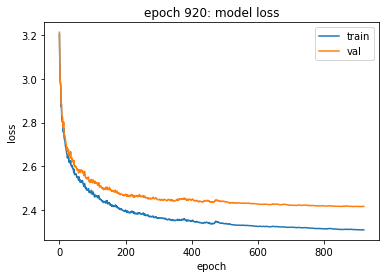

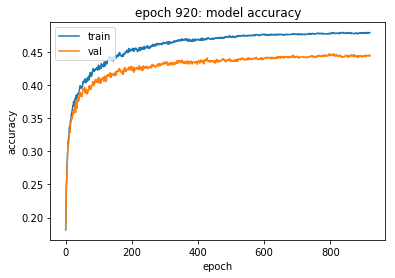



Epoch 921/2000 ...........
Loss train: 2.308810123481155 
Loss val: 2.4165569105026434 
Train accuracy :  0.478725 
Validation accuracy :  0.4424
Alpha:  0.2


Epoch 922/2000 ...........
Loss train: 2.308535913662419 
Loss val: 2.416474017796966 
Train accuracy :  0.47895 
Validation accuracy :  0.4434
Alpha:  0.2


Epoch 923/2000 ...........
Loss train: 2.308568220158555 
Loss val: 2.4169372821947865 
Train accuracy :  0.479025 
Validation accuracy :  0.4432
Alpha:  0.2


Epoch 924/2000 ...........
Loss train: 2.3086577987664634 
Loss val: 2.416722688359408 
Train accuracy :  0.47885 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 925/2000 ...........
Loss train: 2.308950168441564 
Loss val: 2.4167023440151207 
Train accuracy :  0.479075 
Validation accuracy :  0.4436
Alpha:  0.2


Epoch 926/2000 ...........
Loss train: 2.3083319041100836 
Loss val: 2.415979415616197 
Train accuracy :  0.47905 
Validation accuracy :  0.4431
Alpha:  0.2


Epoch 927/2000 ...........
Loss train: 2.3

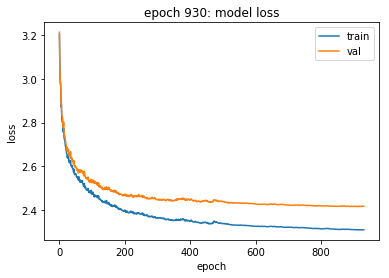

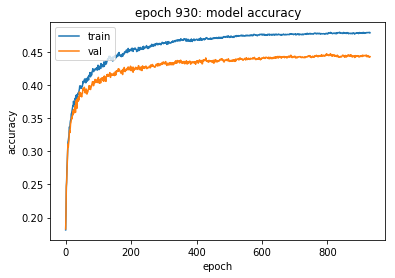



Epoch 931/2000 ...........
Loss train: 2.3086462614118983 
Loss val: 2.415503833456636 
Train accuracy :  0.478725 
Validation accuracy :  0.4434
Alpha:  0.2


Epoch 932/2000 ...........
Loss train: 2.3087624451143727 
Loss val: 2.4152012045569706 
Train accuracy :  0.4784 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 933/2000 ...........
Loss train: 2.308850644132055 
Loss val: 2.41563985310038 
Train accuracy :  0.478825 
Validation accuracy :  0.4442
Alpha:  0.2


Epoch 934/2000 ...........
Loss train: 2.3091556860593285 
Loss val: 2.416274026411451 
Train accuracy :  0.478225 
Validation accuracy :  0.4438
Alpha:  0.2


Epoch 935/2000 ...........
Loss train: 2.3091705190665364 
Loss val: 2.4163262695574144 
Train accuracy :  0.47885 
Validation accuracy :  0.4442
Alpha:  0.2


Epoch 936/2000 ...........
Loss train: 2.3090001771305277 
Loss val: 2.415831126586572 
Train accuracy :  0.478275 
Validation accuracy :  0.4438
Alpha:  0.2


Epoch 937/2000 ...........
Loss train: 2.

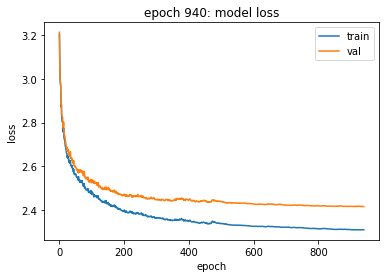

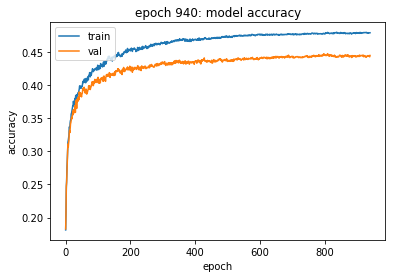



Epoch 941/2000 ...........
Loss train: 2.3082026226219923 
Loss val: 2.4146106114230865 
Train accuracy :  0.478425 
Validation accuracy :  0.444
Alpha:  0.2


Epoch 942/2000 ...........
Loss train: 2.3081905048881395 
Loss val: 2.414728848219716 
Train accuracy :  0.478425 
Validation accuracy :  0.444
Alpha:  0.2


Epoch 943/2000 ...........
Loss train: 2.3078169820595096 
Loss val: 2.4146534956132077 
Train accuracy :  0.47815 
Validation accuracy :  0.4438
Alpha:  0.2


Epoch 944/2000 ...........
Loss train: 2.307746134317024 
Loss val: 2.414488005750289 
Train accuracy :  0.478825 
Validation accuracy :  0.4446
Alpha:  0.2


Epoch 945/2000 ...........
Loss train: 2.307662271232128 
Loss val: 2.415310619220974 
Train accuracy :  0.47875 
Validation accuracy :  0.4448
Alpha:  0.2


Epoch 946/2000 ...........
Loss train: 2.30800680935134 
Loss val: 2.4161568193828638 
Train accuracy :  0.4787 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 947/2000 ...........
Loss train: 2.3077

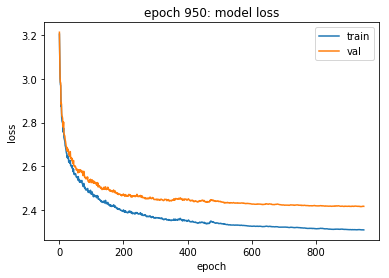

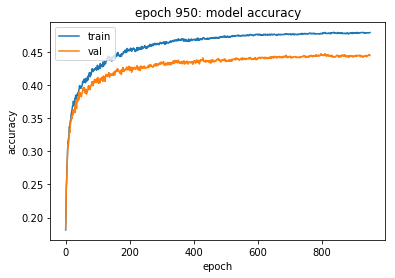



Epoch 951/2000 ...........
Loss train: 2.3077675080894204 
Loss val: 2.416005930967409 
Train accuracy :  0.478975 
Validation accuracy :  0.4447
Alpha:  0.2


Epoch 952/2000 ...........
Loss train: 2.307930654703516 
Loss val: 2.417014108318434 
Train accuracy :  0.47925 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 953/2000 ...........
Loss train: 2.3078917191875328 
Loss val: 2.4166550744006714 
Train accuracy :  0.478425 
Validation accuracy :  0.4451
Alpha:  0.2


Epoch 954/2000 ...........
Loss train: 2.3076713614361513 
Loss val: 2.416308891024132 
Train accuracy :  0.47875 
Validation accuracy :  0.4452
Alpha:  0.2


Epoch 955/2000 ...........
Loss train: 2.3074077402493476 
Loss val: 2.4161387273477044 
Train accuracy :  0.4785 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 956/2000 ...........
Loss train: 2.3076312002675152 
Loss val: 2.4158947588494066 
Train accuracy :  0.4784 
Validation accuracy :  0.4454
Alpha:  0.2


Epoch 957/2000 ...........
Loss train: 2.3

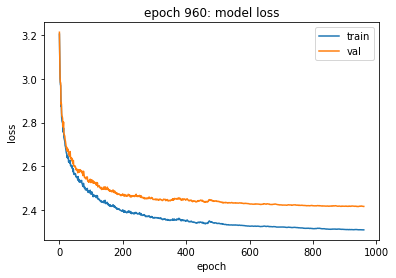

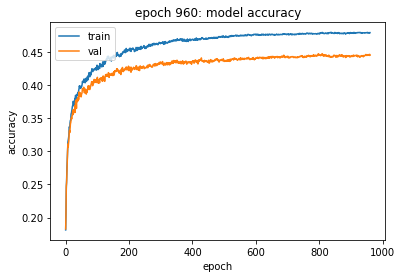



Epoch 961/2000 ...........
Loss train: 2.3075826510525768 
Loss val: 2.41508141388164 
Train accuracy :  0.479575 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 962/2000 ...........
Loss train: 2.307430866608239 
Loss val: 2.4141767746242984 
Train accuracy :  0.479275 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 963/2000 ...........
Loss train: 2.307081953367373 
Loss val: 2.4141826879133665 
Train accuracy :  0.479675 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 964/2000 ...........
Loss train: 2.3070498118624068 
Loss val: 2.4149727193872406 
Train accuracy :  0.479025 
Validation accuracy :  0.4473
Alpha:  0.2


Epoch 965/2000 ...........
Loss train: 2.307247665300808 
Loss val: 2.415496175728061 
Train accuracy :  0.478625 
Validation accuracy :  0.4455
Alpha:  0.2


Epoch 966/2000 ...........
Loss train: 2.307072620888751 
Loss val: 2.415711861608581 
Train accuracy :  0.47865 
Validation accuracy :  0.4447
Alpha:  0.2


Epoch 967/2000 ...........
Loss train: 2.

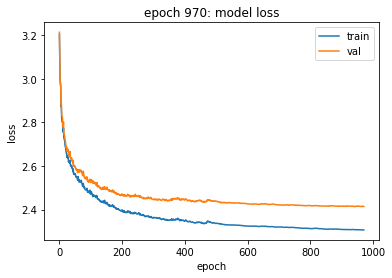

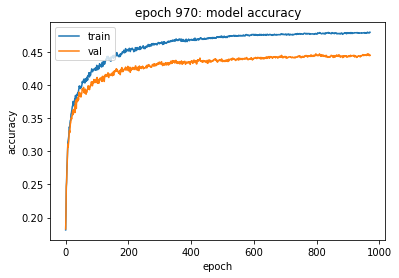



Epoch 971/2000 ...........
Loss train: 2.306960684898329 
Loss val: 2.4138786567635195 
Train accuracy :  0.479425 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 972/2000 ...........
Loss train: 2.3063857431463863 
Loss val: 2.413881591506577 
Train accuracy :  0.479925 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 973/2000 ...........
Loss train: 2.3062211152342824 
Loss val: 2.414403840574424 
Train accuracy :  0.4793 
Validation accuracy :  0.445
Alpha:  0.2


Epoch 974/2000 ...........
Loss train: 2.3057660154556303 
Loss val: 2.41445509937961 
Train accuracy :  0.479325 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 975/2000 ...........
Loss train: 2.3058119328901867 
Loss val: 2.414425318259664 
Train accuracy :  0.479575 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 976/2000 ...........
Loss train: 2.3059080115542634 
Loss val: 2.414898990719978 
Train accuracy :  0.480375 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 977/2000 ...........
Loss train: 2.3

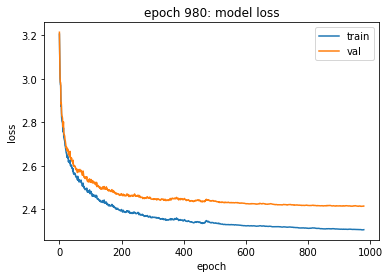

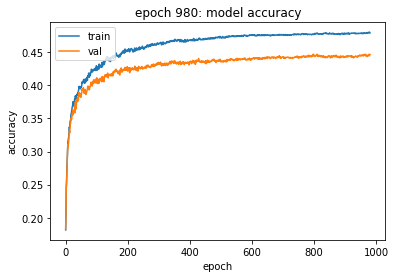



Epoch 981/2000 ...........
Loss train: 2.306208027120962 
Loss val: 2.414852931625146 
Train accuracy :  0.479775 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 982/2000 ...........
Loss train: 2.305854965807823 
Loss val: 2.4143273174767734 
Train accuracy :  0.480025 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 983/2000 ...........
Loss train: 2.305578879876531 
Loss val: 2.414240677998303 
Train accuracy :  0.480125 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 984/2000 ...........
Loss train: 2.306110999758718 
Loss val: 2.4151892389737872 
Train accuracy :  0.47955 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 985/2000 ...........
Loss train: 2.3063175792774797 
Loss val: 2.41548687857694 
Train accuracy :  0.47925 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 986/2000 ...........
Loss train: 2.305434776769833 
Loss val: 2.415243298736703 
Train accuracy :  0.4797 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 987/2000 ...........
Loss train: 2.30573

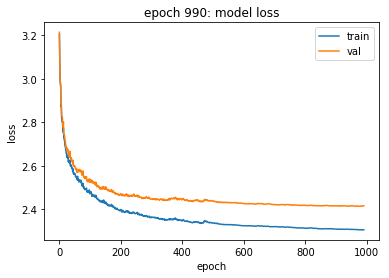

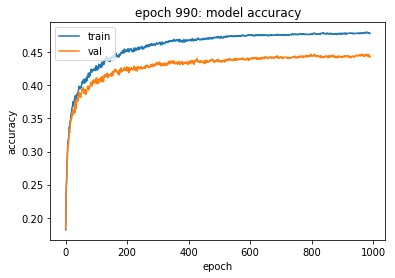



Epoch 991/2000 ...........
Loss train: 2.3069415170298524 
Loss val: 2.417189165898626 
Train accuracy :  0.478925 
Validation accuracy :  0.4439
Alpha:  0.2


Epoch 992/2000 ...........
Loss train: 2.306127626316849 
Loss val: 2.416510390618768 
Train accuracy :  0.478925 
Validation accuracy :  0.4448
Alpha:  0.2


Epoch 993/2000 ...........
Loss train: 2.3059845297794164 
Loss val: 2.416569372314876 
Train accuracy :  0.479275 
Validation accuracy :  0.445
Alpha:  0.2


Epoch 994/2000 ...........
Loss train: 2.3060374249816107 
Loss val: 2.4160801680372126 
Train accuracy :  0.479525 
Validation accuracy :  0.4451
Alpha:  0.2


Epoch 995/2000 ...........
Loss train: 2.306003815025185 
Loss val: 2.416267785818413 
Train accuracy :  0.479125 
Validation accuracy :  0.4451
Alpha:  0.2


Epoch 996/2000 ...........
Loss train: 2.306618388493831 
Loss val: 2.4173892974434397 
Train accuracy :  0.479575 
Validation accuracy :  0.4452
Alpha:  0.2


Epoch 997/2000 ...........
Loss train: 2

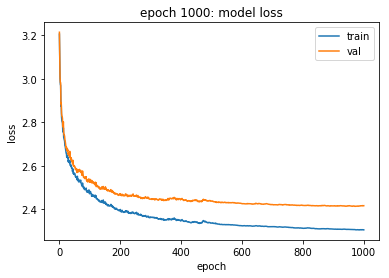

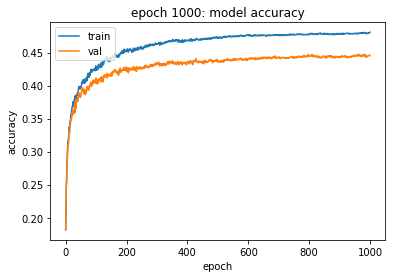



Epoch 1001/2000 ...........
Loss train: 2.305848972181945 
Loss val: 2.4166190237616556 
Train accuracy :  0.480075 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 1002/2000 ...........
Loss train: 2.3054294491649476 
Loss val: 2.4151797745395593 
Train accuracy :  0.4802 
Validation accuracy :  0.4477
Alpha:  0.2


Epoch 1003/2000 ...........
Loss train: 2.30518785226887 
Loss val: 2.415032294231731 
Train accuracy :  0.480025 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1004/2000 ...........
Loss train: 2.304774513827245 
Loss val: 2.414501950824946 
Train accuracy :  0.480025 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 1005/2000 ...........
Loss train: 2.305901461766645 
Loss val: 2.415182247609668 
Train accuracy :  0.4799 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 1006/2000 ...........
Loss train: 2.3055948017077337 
Loss val: 2.4149835249508387 
Train accuracy :  0.4802 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1007/2000 ...........
Loss train: 2

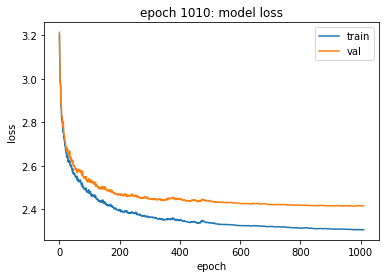

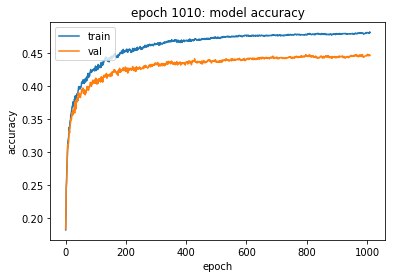



Epoch 1011/2000 ...........
Loss train: 2.3063629228001865 
Loss val: 2.4167448646826286 
Train accuracy :  0.480875 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 1012/2000 ...........
Loss train: 2.3060407551533486 
Loss val: 2.416384249958969 
Train accuracy :  0.4803 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 1013/2000 ...........
Loss train: 2.3053609157719914 
Loss val: 2.4158288274077617 
Train accuracy :  0.48005 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 1014/2000 ...........
Loss train: 2.3051385090055554 
Loss val: 2.4156007018822274 
Train accuracy :  0.4807 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 1015/2000 ...........
Loss train: 2.3051321224546233 
Loss val: 2.41621077451013 
Train accuracy :  0.48005 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 1016/2000 ...........
Loss train: 2.3052324273897824 
Loss val: 2.416264478707505 
Train accuracy :  0.480225 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 1017/2000 ...........
Loss tra

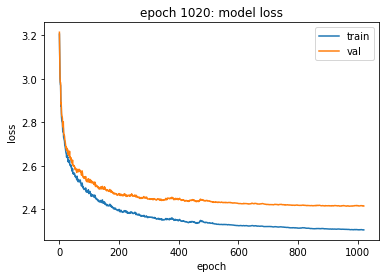

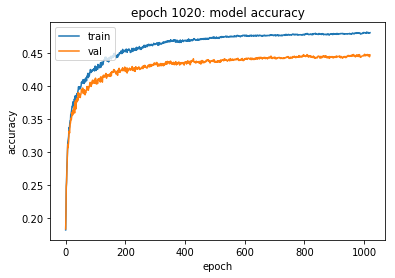



Epoch 1021/2000 ...........
Loss train: 2.3047999799382723 
Loss val: 2.4145757865078306 
Train accuracy :  0.48025 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1022/2000 ...........
Loss train: 2.304684608956131 
Loss val: 2.414697164708411 
Train accuracy :  0.480225 
Validation accuracy :  0.4451
Alpha:  0.2


Epoch 1023/2000 ...........
Loss train: 2.3044961931409724 
Loss val: 2.4147712881636645 
Train accuracy :  0.4803 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 1024/2000 ...........
Loss train: 2.3046022352185624 
Loss val: 2.4150081212954495 
Train accuracy :  0.480525 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 1025/2000 ...........
Loss train: 2.3050358058588123 
Loss val: 2.415651710649477 
Train accuracy :  0.48015 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1026/2000 ...........
Loss train: 2.3049603698035086 
Loss val: 2.415715590946239 
Train accuracy :  0.480475 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 1027/2000 ...........
Loss tra

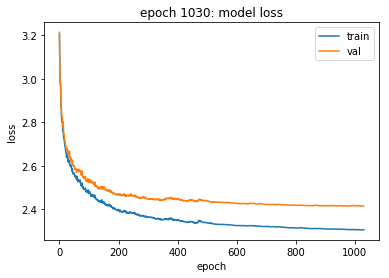

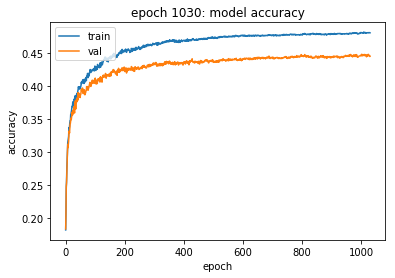



Epoch 1031/2000 ...........
Loss train: 2.3046332830076963 
Loss val: 2.4140783466808693 
Train accuracy :  0.479825 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 1032/2000 ...........
Loss train: 2.304516971050819 
Loss val: 2.4146027184518575 
Train accuracy :  0.4798 
Validation accuracy :  0.4437
Alpha:  0.2


Epoch 1033/2000 ...........
Loss train: 2.3047364406001036 
Loss val: 2.414690164038769 
Train accuracy :  0.48065 
Validation accuracy :  0.445
Alpha:  0.2


Epoch 1034/2000 ...........
Loss train: 2.304806010498191 
Loss val: 2.4147914780983784 
Train accuracy :  0.480325 
Validation accuracy :  0.4438
Alpha:  0.2


Epoch 1035/2000 ...........
Loss train: 2.3046767608360135 
Loss val: 2.414242015946522 
Train accuracy :  0.480325 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 1036/2000 ...........
Loss train: 2.3048761242412454 
Loss val: 2.4139140181694785 
Train accuracy :  0.48035 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 1037/2000 ...........
Loss tr

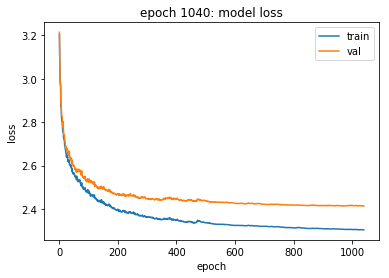

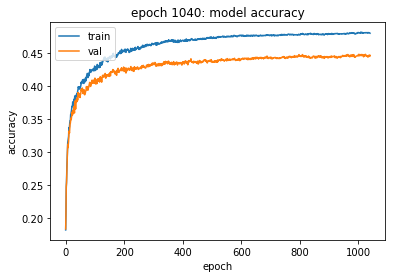



Epoch 1041/2000 ...........
Loss train: 2.304111114994828 
Loss val: 2.4145232731290163 
Train accuracy :  0.479875 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1042/2000 ...........
Loss train: 2.3039655395387983 
Loss val: 2.414293331483283 
Train accuracy :  0.48 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 1043/2000 ...........
Loss train: 2.30402812930158 
Loss val: 2.4142180077688553 
Train accuracy :  0.4806 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 1044/2000 ...........
Loss train: 2.3038765161450265 
Loss val: 2.4146495626737607 
Train accuracy :  0.479525 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 1045/2000 ...........
Loss train: 2.3037347357721503 
Loss val: 2.414179021907361 
Train accuracy :  0.48 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 1046/2000 ...........
Loss train: 2.3034252075747825 
Loss val: 2.4136457744685336 
Train accuracy :  0.4809 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1047/2000 ...........
Loss train: 2.3

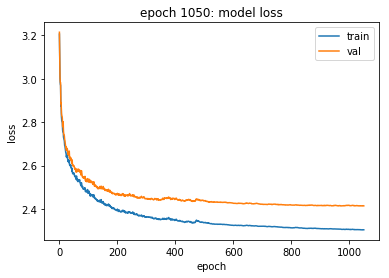

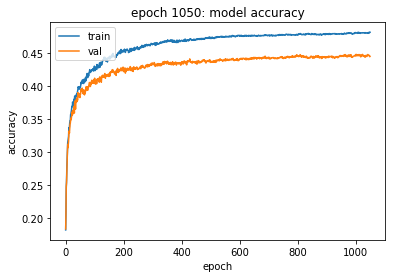



Epoch 1051/2000 ...........
Loss train: 2.3039647406451533 
Loss val: 2.413259386365868 
Train accuracy :  0.481425 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 1052/2000 ...........
Loss train: 2.3037912685785633 
Loss val: 2.413183412135963 
Train accuracy :  0.480325 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 1053/2000 ...........
Loss train: 2.3034467494803588 
Loss val: 2.4131420181803325 
Train accuracy :  0.4817 
Validation accuracy :  0.4444
Alpha:  0.2


Epoch 1054/2000 ...........
Loss train: 2.303117638872868 
Loss val: 2.413213268173011 
Train accuracy :  0.481725 
Validation accuracy :  0.4444
Alpha:  0.2


Epoch 1055/2000 ...........
Loss train: 2.3028974166098384 
Loss val: 2.4133958215985825 
Train accuracy :  0.4806 
Validation accuracy :  0.4454
Alpha:  0.2


Epoch 1056/2000 ...........
Loss train: 2.30268742170099 
Loss val: 2.4131751919045326 
Train accuracy :  0.481225 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 1057/2000 ...........
Loss tra

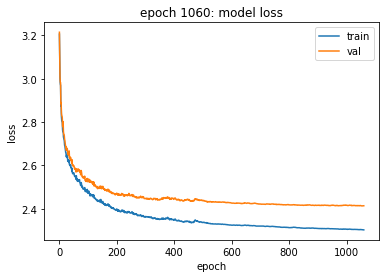

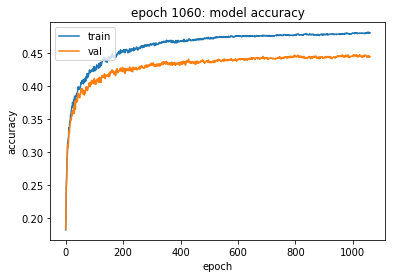



Epoch 1061/2000 ...........
Loss train: 2.3026623655176737 
Loss val: 2.4136951143302388 
Train accuracy :  0.481 
Validation accuracy :  0.4436
Alpha:  0.2


Epoch 1062/2000 ...........
Loss train: 2.30270511483084 
Loss val: 2.413148751188909 
Train accuracy :  0.48005 
Validation accuracy :  0.4447
Alpha:  0.2


Epoch 1063/2000 ...........
Loss train: 2.302459504950088 
Loss val: 2.4132012775988505 
Train accuracy :  0.48035 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 1064/2000 ...........
Loss train: 2.302374061075578 
Loss val: 2.4135484838564567 
Train accuracy :  0.480975 
Validation accuracy :  0.4455
Alpha:  0.2


Epoch 1065/2000 ...........
Loss train: 2.302268250670179 
Loss val: 2.413525689092395 
Train accuracy :  0.481275 
Validation accuracy :  0.4449
Alpha:  0.2


Epoch 1066/2000 ...........
Loss train: 2.302160159030297 
Loss val: 2.413738502418069 
Train accuracy :  0.480475 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 1067/2000 ...........
Loss train: 

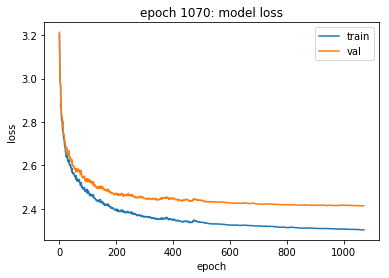

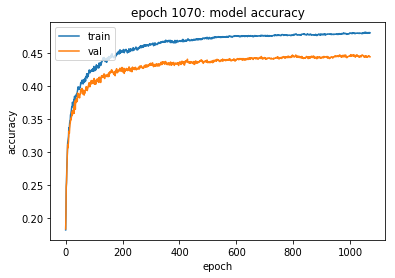



Epoch 1071/2000 ...........
Loss train: 2.3023658671606477 
Loss val: 2.414029997458874 
Train accuracy :  0.480475 
Validation accuracy :  0.4439
Alpha:  0.2


Epoch 1072/2000 ...........
Loss train: 2.302174432367922 
Loss val: 2.4128454026618935 
Train accuracy :  0.4809 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 1073/2000 ...........
Loss train: 2.302430918814851 
Loss val: 2.4132846873738294 
Train accuracy :  0.481025 
Validation accuracy :  0.4447
Alpha:  0.2


Epoch 1074/2000 ...........
Loss train: 2.3023813678868117 
Loss val: 2.413373588207249 
Train accuracy :  0.4808 
Validation accuracy :  0.4446
Alpha:  0.2


Epoch 1075/2000 ...........
Loss train: 2.3025539022357755 
Loss val: 2.4126116089635437 
Train accuracy :  0.48095 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 1076/2000 ...........
Loss train: 2.3021797241273427 
Loss val: 2.4122867309294436 
Train accuracy :  0.4811 
Validation accuracy :  0.4448
Alpha:  0.2


Epoch 1077/2000 ...........
Loss trai

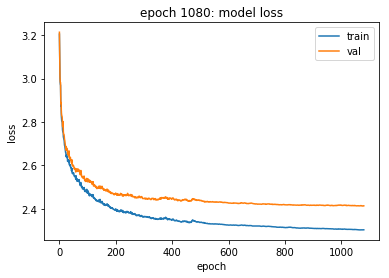

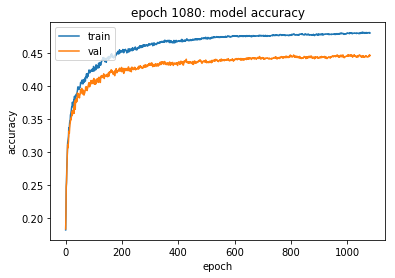



Epoch 1081/2000 ...........
Loss train: 2.3033664639962974 
Loss val: 2.413808179944583 
Train accuracy :  0.4808 
Validation accuracy :  0.4446
Alpha:  0.2


Epoch 1082/2000 ...........
Loss train: 2.3030307462181705 
Loss val: 2.4135522590555043 
Train accuracy :  0.480325 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 1083/2000 ...........
Loss train: 2.302844405550488 
Loss val: 2.413721250270633 
Train accuracy :  0.48065 
Validation accuracy :  0.4448
Alpha:  0.2


Epoch 1084/2000 ...........
Loss train: 2.30289581761407 
Loss val: 2.4141347451136315 
Train accuracy :  0.480675 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 1085/2000 ...........
Loss train: 2.3028706903012344 
Loss val: 2.4138274750819577 
Train accuracy :  0.48095 
Validation accuracy :  0.4447
Alpha:  0.2


Epoch 1086/2000 ...........
Loss train: 2.3029926944979024 
Loss val: 2.4138729510817334 
Train accuracy :  0.48005 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 1087/2000 ...........
Loss tra

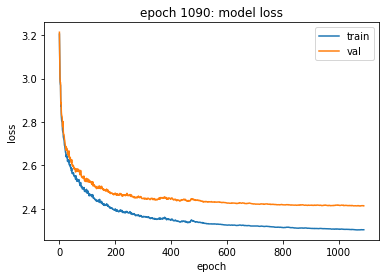

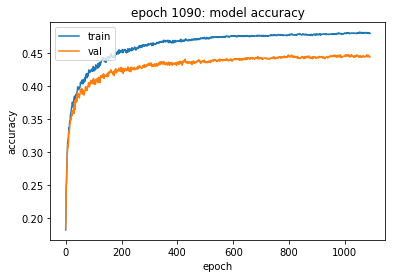



Epoch 1091/2000 ...........
Loss train: 2.3029215218840475 
Loss val: 2.41386856011198 
Train accuracy :  0.48065 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1092/2000 ...........
Loss train: 2.3026467213823163 
Loss val: 2.4137050449340265 
Train accuracy :  0.480875 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 1093/2000 ...........
Loss train: 2.3025032240351666 
Loss val: 2.413920219466564 
Train accuracy :  0.48035 
Validation accuracy :  0.4451
Alpha:  0.2


Epoch 1094/2000 ...........
Loss train: 2.3030766225050625 
Loss val: 2.414522645608989 
Train accuracy :  0.481075 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 1095/2000 ...........
Loss train: 2.303545064658798 
Loss val: 2.4151867260587885 
Train accuracy :  0.48045 
Validation accuracy :  0.4454
Alpha:  0.2


Epoch 1096/2000 ...........
Loss train: 2.3036202020557752 
Loss val: 2.4153415387222714 
Train accuracy :  0.4808 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 1097/2000 ...........
Loss trai

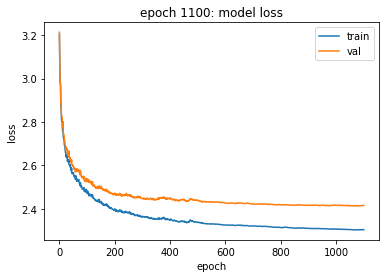

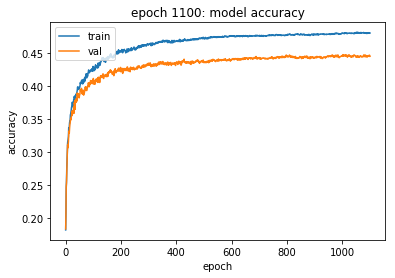



Epoch 1101/2000 ...........
Loss train: 2.3029545730845236 
Loss val: 2.4149372387888666 
Train accuracy :  0.480025 
Validation accuracy :  0.4452
Alpha:  0.2


Epoch 1102/2000 ...........
Loss train: 2.3029798381925284 
Loss val: 2.4159207895265733 
Train accuracy :  0.48085 
Validation accuracy :  0.4444
Alpha:  0.2


Epoch 1103/2000 ...........
Loss train: 2.303318470461961 
Loss val: 2.4162631776101517 
Train accuracy :  0.480825 
Validation accuracy :  0.4454
Alpha:  0.2


Epoch 1104/2000 ...........
Loss train: 2.3033300566955432 
Loss val: 2.4160501226422166 
Train accuracy :  0.48085 
Validation accuracy :  0.4439
Alpha:  0.2


Epoch 1105/2000 ...........
Loss train: 2.303212329850252 
Loss val: 2.4158288773730088 
Train accuracy :  0.48095 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 1106/2000 ...........
Loss train: 2.303015661997312 
Loss val: 2.415597775597346 
Train accuracy :  0.481575 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 1107/2000 ...........
Loss 

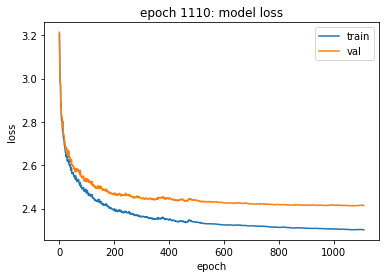

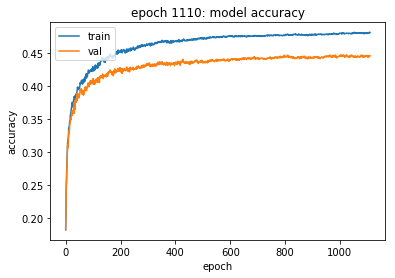



Epoch 1111/2000 ...........
Loss train: 2.3019300573599644 
Loss val: 2.4151136596261567 
Train accuracy :  0.481475 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 1112/2000 ...........
Loss train: 2.3019044822913073 
Loss val: 2.414714412876782 
Train accuracy :  0.481375 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 1113/2000 ...........
Loss train: 2.301956328142417 
Loss val: 2.4150337659227152 
Train accuracy :  0.4814 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 1114/2000 ...........
Loss train: 2.3020649141803338 
Loss val: 2.4150612086328342 
Train accuracy :  0.481175 
Validation accuracy :  0.4453
Alpha:  0.2


Epoch 1115/2000 ...........
Loss train: 2.3016604183841545 
Loss val: 2.4141919789587925 
Train accuracy :  0.4811 
Validation accuracy :  0.4452
Alpha:  0.2


Epoch 1116/2000 ...........
Loss train: 2.3018159777057234 
Loss val: 2.41459597314635 
Train accuracy :  0.4818 
Validation accuracy :  0.4446
Alpha:  0.2


Epoch 1117/2000 ...........
Loss tra

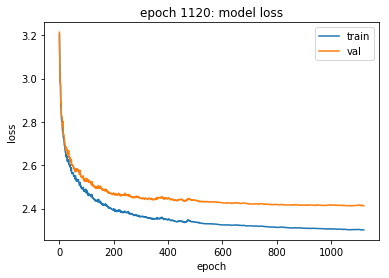

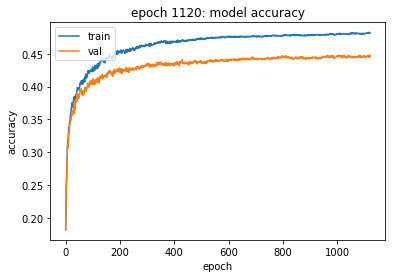



Epoch 1121/2000 ...........
Loss train: 2.30122645999232 
Loss val: 2.412888784723545 
Train accuracy :  0.48205 
Validation accuracy :  0.4444
Alpha:  0.2


Epoch 1122/2000 ...........
Loss train: 2.300987972856033 
Loss val: 2.4126349395959967 
Train accuracy :  0.481775 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 1123/2000 ...........
Loss train: 2.3018365145162627 
Loss val: 2.413337168563081 
Train accuracy :  0.48155 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 1124/2000 ...........
Loss train: 2.301893151739339 
Loss val: 2.4135982883432927 
Train accuracy :  0.481225 
Validation accuracy :  0.4454
Alpha:  0.2


Epoch 1125/2000 ...........
Loss train: 2.30233083067844 
Loss val: 2.4144057306478195 
Train accuracy :  0.481575 
Validation accuracy :  0.4443
Alpha:  0.2


Epoch 1126/2000 ...........
Loss train: 2.301874725255475 
Loss val: 2.4137358958790367 
Train accuracy :  0.4812 
Validation accuracy :  0.444
Alpha:  0.2


Epoch 1127/2000 ...........
Loss train: 

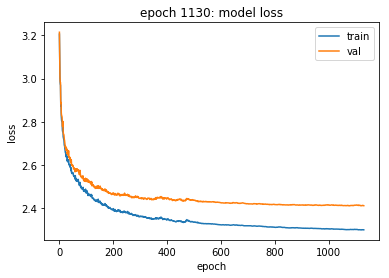

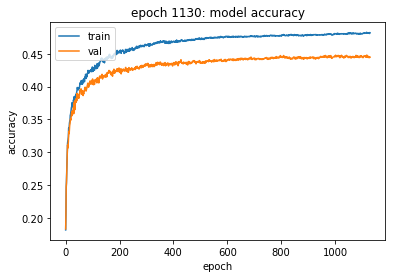



Epoch 1131/2000 ...........
Loss train: 2.3019129109266023 
Loss val: 2.413696969245895 
Train accuracy :  0.480675 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 1132/2000 ...........
Loss train: 2.3015750106010815 
Loss val: 2.4142325041181194 
Train accuracy :  0.48145 
Validation accuracy :  0.4447
Alpha:  0.2


Epoch 1133/2000 ...........
Loss train: 2.3013534652962067 
Loss val: 2.4138708643757125 
Train accuracy :  0.481925 
Validation accuracy :  0.4445
Alpha:  0.2


Epoch 1134/2000 ...........
Loss train: 2.301314709443848 
Loss val: 2.413336755322249 
Train accuracy :  0.482025 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 1135/2000 ...........
Loss train: 2.3011264203825164 
Loss val: 2.4130659128717533 
Train accuracy :  0.48135 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 1136/2000 ...........
Loss train: 2.301190698341682 
Loss val: 2.4125688109549004 
Train accuracy :  0.481475 
Validation accuracy :  0.4452
Alpha:  0.2


Epoch 1137/2000 ...........
Loss

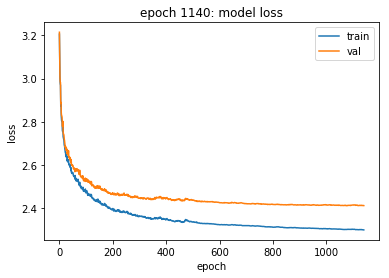

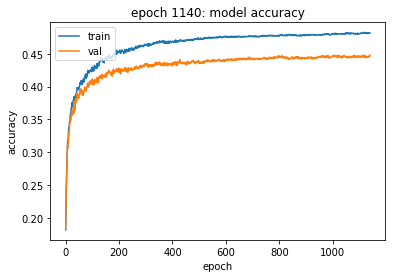



Epoch 1141/2000 ...........
Loss train: 2.30068836472289 
Loss val: 2.4135017829692433 
Train accuracy :  0.48175 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 1142/2000 ...........
Loss train: 2.3002266048446964 
Loss val: 2.412717813574823 
Train accuracy :  0.4818 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 1143/2000 ...........
Loss train: 2.3001832826948774 
Loss val: 2.412450364588251 
Train accuracy :  0.4817 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 1144/2000 ...........
Loss train: 2.300048713758788 
Loss val: 2.4131684573554244 
Train accuracy :  0.481425 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1145/2000 ...........
Loss train: 2.300259784494553 
Loss val: 2.413007401676806 
Train accuracy :  0.481125 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 1146/2000 ...........
Loss train: 2.3004578765797685 
Loss val: 2.41294383726068 
Train accuracy :  0.48145 
Validation accuracy :  0.4454
Alpha:  0.2


Epoch 1147/2000 ...........
Loss train: 2.

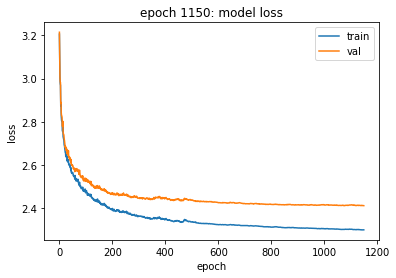

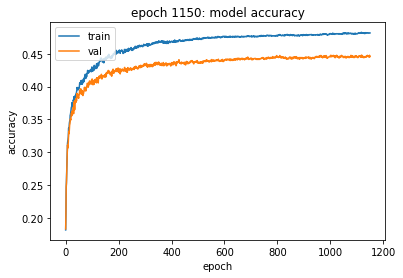



Epoch 1151/2000 ...........
Loss train: 2.299891893655442 
Loss val: 2.4120248649666767 
Train accuracy :  0.48185 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1152/2000 ...........
Loss train: 2.2998056009773973 
Loss val: 2.4124842254376295 
Train accuracy :  0.4814 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 1153/2000 ...........
Loss train: 2.299830589247287 
Loss val: 2.4133161428798977 
Train accuracy :  0.48195 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 1154/2000 ...........
Loss train: 2.2999104571306956 
Loss val: 2.4136753333623266 
Train accuracy :  0.481825 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 1155/2000 ...........
Loss train: 2.2997937797209045 
Loss val: 2.41280406033342 
Train accuracy :  0.4823 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1156/2000 ...........
Loss train: 2.2995788920051297 
Loss val: 2.4124883661836622 
Train accuracy :  0.482225 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1157/2000 ...........
Loss train

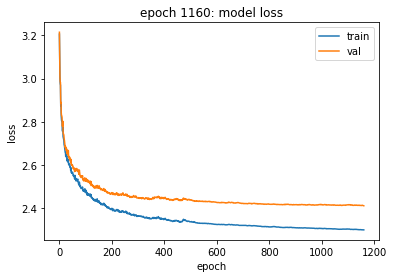

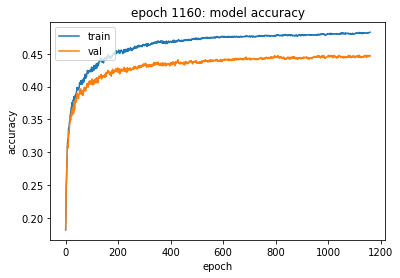



Epoch 1161/2000 ...........
Loss train: 2.2993513702413 
Loss val: 2.411437308324163 
Train accuracy :  0.4823 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 1162/2000 ...........
Loss train: 2.2995900455857647 
Loss val: 2.4117357331292135 
Train accuracy :  0.482675 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 1163/2000 ...........
Loss train: 2.2995387437906296 
Loss val: 2.411420541662034 
Train accuracy :  0.482125 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1164/2000 ...........
Loss train: 2.2994948876555 
Loss val: 2.411172845028187 
Train accuracy :  0.482075 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1165/2000 ...........
Loss train: 2.2992356692798857 
Loss val: 2.4112308956547035 
Train accuracy :  0.48255 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 1166/2000 ...........
Loss train: 2.2993352835770446 
Loss val: 2.411488224788661 
Train accuracy :  0.48215 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 1167/2000 ...........
Loss train: 

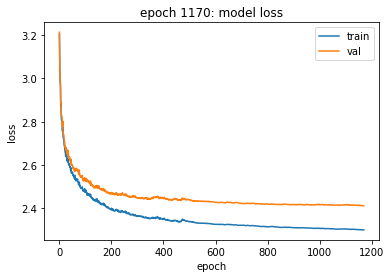

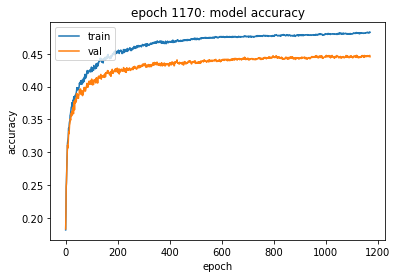



Epoch 1171/2000 ...........
Loss train: 2.2987305574461794 
Loss val: 2.4099766048087163 
Train accuracy :  0.483125 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1172/2000 ...........
Loss train: 2.298448105964226 
Loss val: 2.409415563750618 
Train accuracy :  0.482875 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 1173/2000 ...........
Loss train: 2.2987125691372876 
Loss val: 2.409537882751078 
Train accuracy :  0.482025 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 1174/2000 ...........
Loss train: 2.298875937655261 
Loss val: 2.4099399698366755 
Train accuracy :  0.482175 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 1175/2000 ...........
Loss train: 2.298744900763259 
Loss val: 2.410338160853833 
Train accuracy :  0.482825 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 1176/2000 ...........
Loss train: 2.2989580167534336 
Loss val: 2.411183353666071 
Train accuracy :  0.48245 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 1177/2000 ...........
Loss tr

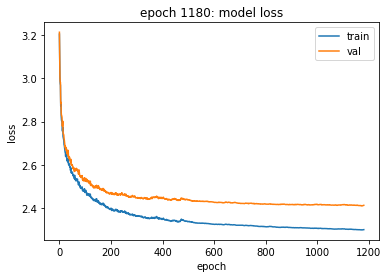

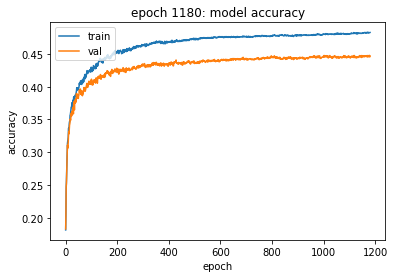



Epoch 1181/2000 ...........
Loss train: 2.2998969907458284 
Loss val: 2.4123650385575925 
Train accuracy :  0.482925 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1182/2000 ...........
Loss train: 2.29934200888558 
Loss val: 2.4122413904167894 
Train accuracy :  0.48335 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1183/2000 ...........
Loss train: 2.299232378548769 
Loss val: 2.411975609716987 
Train accuracy :  0.48285 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1184/2000 ...........
Loss train: 2.2998431546927613 
Loss val: 2.4126689669492283 
Train accuracy :  0.4829 
Validation accuracy :  0.4448
Alpha:  0.2


Epoch 1185/2000 ...........
Loss train: 2.2999204188981235 
Loss val: 2.4122873107744756 
Train accuracy :  0.483325 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 1186/2000 ...........
Loss train: 2.299454322678526 
Loss val: 2.4113273870469305 
Train accuracy :  0.483275 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 1187/2000 ...........
Loss tr

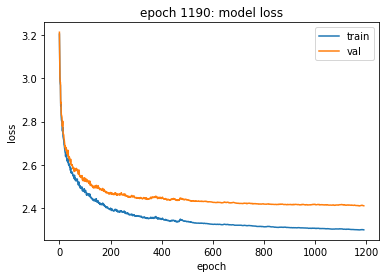

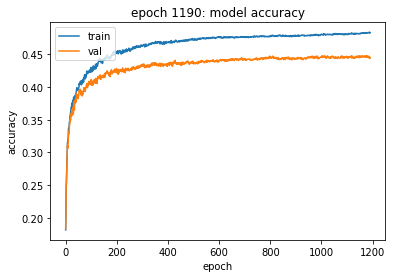



Epoch 1191/2000 ...........
Loss train: 2.2984787870194703 
Loss val: 2.40988074440738 
Train accuracy :  0.48335 
Validation accuracy :  0.4452
Alpha:  0.2


Epoch 1192/2000 ...........
Loss train: 2.299064646104192 
Loss val: 2.4107950617723946 
Train accuracy :  0.4829 
Validation accuracy :  0.4444
Alpha:  0.2


Epoch 1193/2000 ...........
Loss train: 2.299362514405424 
Loss val: 2.411232976726899 
Train accuracy :  0.4834 
Validation accuracy :  0.4452
Alpha:  0.2


Epoch 1194/2000 ...........
Loss train: 2.29931044438452 
Loss val: 2.4110400968755044 
Train accuracy :  0.48275 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 1195/2000 ...........
Loss train: 2.2991643398951243 
Loss val: 2.4108740135681193 
Train accuracy :  0.482575 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1196/2000 ...........
Loss train: 2.2991655162854925 
Loss val: 2.411137443359459 
Train accuracy :  0.48265 
Validation accuracy :  0.4455
Alpha:  0.2


Epoch 1197/2000 ...........
Loss train: 2.

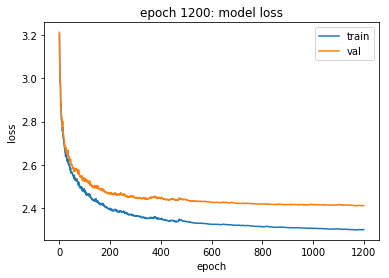

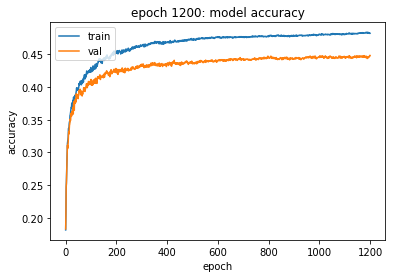



Epoch 1201/2000 ...........
Loss train: 2.300731035441569 
Loss val: 2.4109216904446513 
Train accuracy :  0.482325 
Validation accuracy :  0.4486
Alpha:  0.2


Epoch 1202/2000 ...........
Loss train: 2.3003293064876384 
Loss val: 2.4113553000733328 
Train accuracy :  0.482775 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 1203/2000 ...........
Loss train: 2.300682074835035 
Loss val: 2.4112318652385243 
Train accuracy :  0.482175 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1204/2000 ...........
Loss train: 2.3004861735573994 
Loss val: 2.412169143296728 
Train accuracy :  0.482475 
Validation accuracy :  0.4483
Alpha:  0.2


Epoch 1205/2000 ...........
Loss train: 2.3008851802897072 
Loss val: 2.4129366407107917 
Train accuracy :  0.48175 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 1206/2000 ...........
Loss train: 2.300986100952303 
Loss val: 2.412833141712252 
Train accuracy :  0.482975 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 1207/2000 ...........
Loss

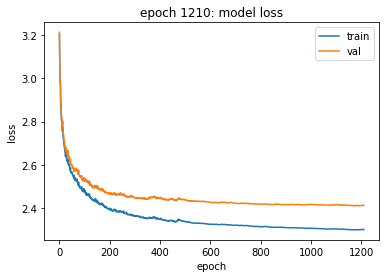

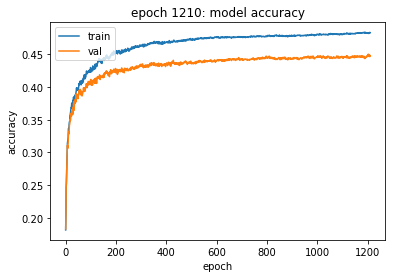



Epoch 1211/2000 ...........
Loss train: 2.299952235871725 
Loss val: 2.4125570399023784 
Train accuracy :  0.48375 
Validation accuracy :  0.4483
Alpha:  0.2


Epoch 1212/2000 ...........
Loss train: 2.300594018133263 
Loss val: 2.413290414925896 
Train accuracy :  0.483425 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1213/2000 ...........
Loss train: 2.3006078354656236 
Loss val: 2.4133290848857323 
Train accuracy :  0.483475 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 1214/2000 ...........
Loss train: 2.30020416097967 
Loss val: 2.4130170995618934 
Train accuracy :  0.483825 
Validation accuracy :  0.4473
Alpha:  0.2


Epoch 1215/2000 ...........
Loss train: 2.30009972659223 
Loss val: 2.412825249612843 
Train accuracy :  0.484825 
Validation accuracy :  0.4488
Alpha:  0.2


Epoch 1216/2000 ...........
Loss train: 2.300310849447801 
Loss val: 2.4119621616062026 
Train accuracy :  0.483975 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 1217/2000 ...........
Loss trai

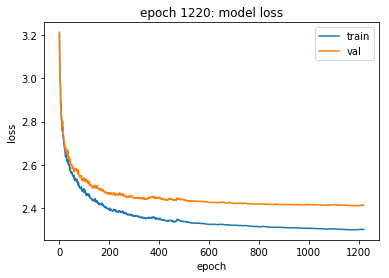

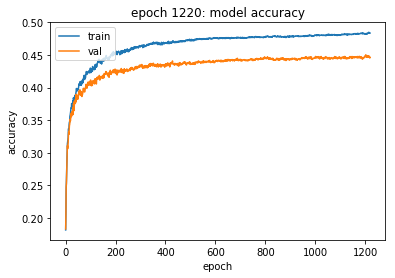



Epoch 1221/2000 ...........
Loss train: 2.301254050047788 
Loss val: 2.413881880820349 
Train accuracy :  0.4832 
Validation accuracy :  0.4452
Alpha:  0.2


Epoch 1222/2000 ...........
Loss train: 2.30141271599314 
Loss val: 2.4139343265424924 
Train accuracy :  0.483525 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1223/2000 ...........
Loss train: 2.3012237223739045 
Loss val: 2.4137896726497354 
Train accuracy :  0.4836 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 1224/2000 ...........
Loss train: 2.300726738323348 
Loss val: 2.4130386125152468 
Train accuracy :  0.482775 
Validation accuracy :  0.445
Alpha:  0.2


Epoch 1225/2000 ...........
Loss train: 2.300441567097102 
Loss val: 2.4127428813442204 
Train accuracy :  0.484 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 1226/2000 ...........
Loss train: 2.3002057107369334 
Loss val: 2.4124891661552548 
Train accuracy :  0.48305 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 1227/2000 ...........
Loss train: 2

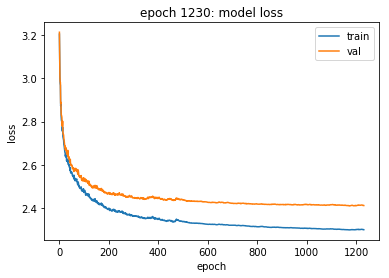

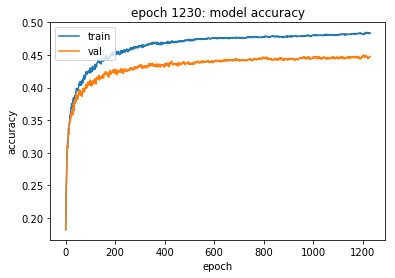



Epoch 1231/2000 ...........
Loss train: 2.2994771947858075 
Loss val: 2.411373550752423 
Train accuracy :  0.483475 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 1232/2000 ...........
Loss train: 2.300298752025795 
Loss val: 2.4122370714107086 
Train accuracy :  0.483325 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 1233/2000 ...........
Loss train: 2.3005992041152257 
Loss val: 2.4123521980246254 
Train accuracy :  0.483775 
Validation accuracy :  0.4459
Alpha:  0.2


Epoch 1234/2000 ...........
Loss train: 2.3003483706634738 
Loss val: 2.4125774185776723 
Train accuracy :  0.48425 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1235/2000 ...........
Loss train: 2.2995196603011356 
Loss val: 2.411623454804728 
Train accuracy :  0.484325 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 1236/2000 ...........
Loss train: 2.2994765500913568 
Loss val: 2.4114649029155206 
Train accuracy :  0.48395 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 1237/2000 ...........
Los

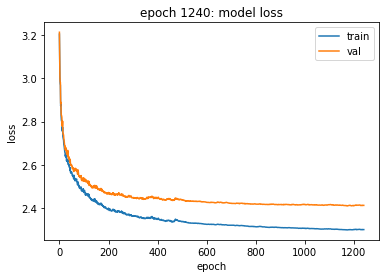

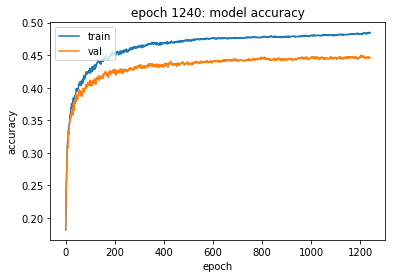



Epoch 1241/2000 ...........
Loss train: 2.3001635521813943 
Loss val: 2.4124083021051157 
Train accuracy :  0.48305 
Validation accuracy :  0.4481
Alpha:  0.2


Epoch 1242/2000 ...........
Loss train: 2.299513288496779 
Loss val: 2.4116954803645045 
Train accuracy :  0.483375 
Validation accuracy :  0.4486
Alpha:  0.2


Epoch 1243/2000 ...........
Loss train: 2.2993460943679116 
Loss val: 2.4123072339416765 
Train accuracy :  0.4838 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 1244/2000 ...........
Loss train: 2.2995338520544113 
Loss val: 2.4124500684368035 
Train accuracy :  0.483775 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 1245/2000 ...........
Loss train: 2.299154671116777 
Loss val: 2.4121131600511196 
Train accuracy :  0.484525 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 1246/2000 ...........
Loss train: 2.298628453918445 
Loss val: 2.4123185004769114 
Train accuracy :  0.4833 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 1247/2000 ...........
Loss t

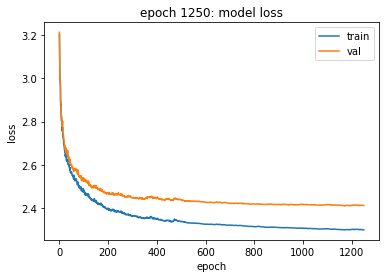

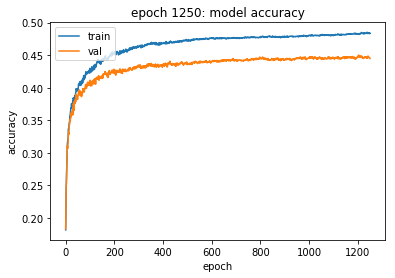



Epoch 1251/2000 ...........
Loss train: 2.2979872939267474 
Loss val: 2.4114013131271856 
Train accuracy :  0.4835 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 1252/2000 ...........
Loss train: 2.2981864264622147 
Loss val: 2.41216224166881 
Train accuracy :  0.48385 
Validation accuracy :  0.448
Alpha:  0.2


Epoch 1253/2000 ...........
Loss train: 2.2986959654434265 
Loss val: 2.4127193384675834 
Train accuracy :  0.483175 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 1254/2000 ...........
Loss train: 2.2992477930324644 
Loss val: 2.4127041793885846 
Train accuracy :  0.483975 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 1255/2000 ...........
Loss train: 2.2990522901638757 
Loss val: 2.4124258611819673 
Train accuracy :  0.48395 
Validation accuracy :  0.4456
Alpha:  0.2


Epoch 1256/2000 ...........
Loss train: 2.2987501280232645 
Loss val: 2.4124743176715966 
Train accuracy :  0.48415 
Validation accuracy :  0.445
Alpha:  0.2


Epoch 1257/2000 ...........
Loss tra

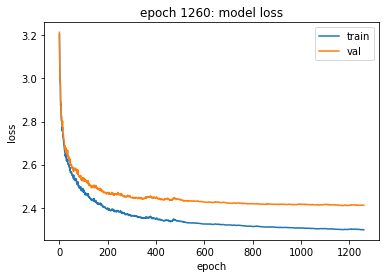

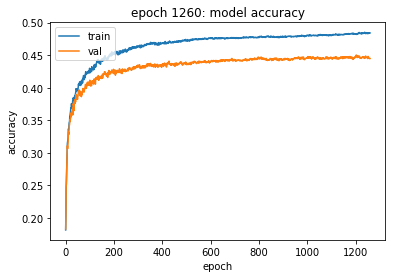



Epoch 1261/2000 ...........
Loss train: 2.2977678624928832 
Loss val: 2.4112606258270617 
Train accuracy :  0.4845 
Validation accuracy :  0.4455
Alpha:  0.2


Epoch 1262/2000 ...........
Loss train: 2.2974739176309114 
Loss val: 2.410941632208758 
Train accuracy :  0.4842 
Validation accuracy :  0.4457
Alpha:  0.2


Epoch 1263/2000 ...........
Loss train: 2.297152359967649 
Loss val: 2.4102941341388653 
Train accuracy :  0.483675 
Validation accuracy :  0.445
Alpha:  0.2


Epoch 1264/2000 ...........
Loss train: 2.2975246714257906 
Loss val: 2.4107887832421993 
Train accuracy :  0.483925 
Validation accuracy :  0.445
Alpha:  0.2


Epoch 1265/2000 ...........
Loss train: 2.2968722103635404 
Loss val: 2.4102536270024313 
Train accuracy :  0.4852 
Validation accuracy :  0.4439
Alpha:  0.2


Epoch 1266/2000 ...........
Loss train: 2.2967086846259877 
Loss val: 2.4105333354974237 
Train accuracy :  0.48445 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1267/2000 ...........
Loss trai

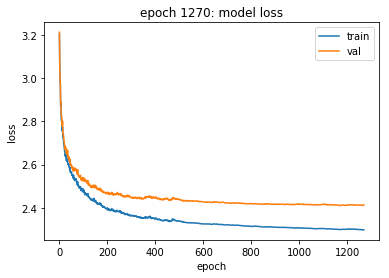

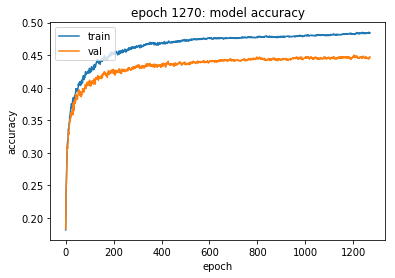



Epoch 1271/2000 ...........
Loss train: 2.296890052727019 
Loss val: 2.4109430568463033 
Train accuracy :  0.484675 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 1272/2000 ...........
Loss train: 2.297086091447557 
Loss val: 2.411185573624596 
Train accuracy :  0.483925 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 1273/2000 ...........
Loss train: 2.2966003565029895 
Loss val: 2.410429200768017 
Train accuracy :  0.484475 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 1274/2000 ...........
Loss train: 2.296662048861758 
Loss val: 2.4115682013395 
Train accuracy :  0.483275 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 1275/2000 ...........
Loss train: 2.2966847211128867 
Loss val: 2.4105953161295077 
Train accuracy :  0.484725 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 1276/2000 ...........
Loss train: 2.2967190746548174 
Loss val: 2.4107113366930677 
Train accuracy :  0.485225 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1277/2000 ...........
Loss t

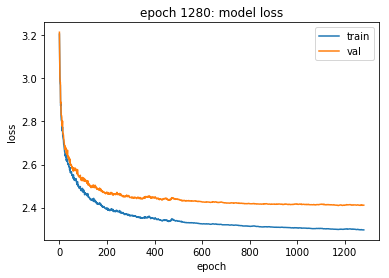

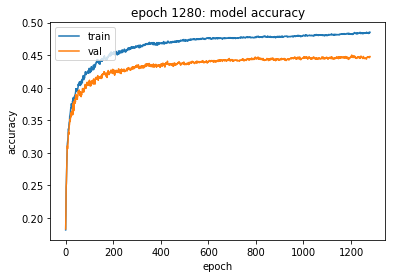



Epoch 1281/2000 ...........
Loss train: 2.296070867176054 
Loss val: 2.41080839688588 
Train accuracy :  0.4851 
Validation accuracy :  0.4464
Alpha:  0.2


Epoch 1282/2000 ...........
Loss train: 2.2962537371878096 
Loss val: 2.4107120196851106 
Train accuracy :  0.48425 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 1283/2000 ...........
Loss train: 2.2965550760235742 
Loss val: 2.4111662948088997 
Train accuracy :  0.484475 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 1284/2000 ...........
Loss train: 2.2964175182418645 
Loss val: 2.4108546014942047 
Train accuracy :  0.4849 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1285/2000 ...........
Loss train: 2.296218484894982 
Loss val: 2.4101756649128574 
Train accuracy :  0.4848 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 1286/2000 ...........
Loss train: 2.295916677029936 
Loss val: 2.4102439297534612 
Train accuracy :  0.485275 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 1287/2000 ...........
Loss train:

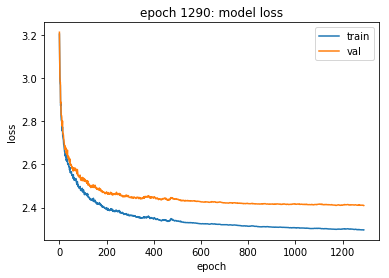

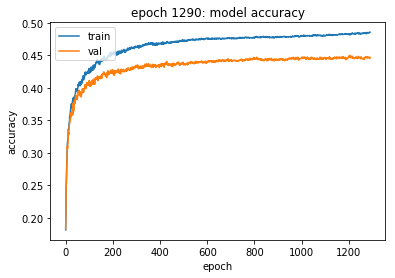



Epoch 1291/2000 ...........
Loss train: 2.295944358915768 
Loss val: 2.4099339790742382 
Train accuracy :  0.485475 
Validation accuracy :  0.4465
Alpha:  0.2


Epoch 1292/2000 ...........
Loss train: 2.295581889573572 
Loss val: 2.4100941287604196 
Train accuracy :  0.485925 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 1293/2000 ...........
Loss train: 2.295282686337862 
Loss val: 2.4099206168638263 
Train accuracy :  0.48575 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 1294/2000 ...........
Loss train: 2.2959543808060165 
Loss val: 2.411368042779246 
Train accuracy :  0.484425 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 1295/2000 ...........
Loss train: 2.2965400613986273 
Loss val: 2.411998461614652 
Train accuracy :  0.484375 
Validation accuracy :  0.446
Alpha:  0.2


Epoch 1296/2000 ...........
Loss train: 2.296860024344528 
Loss val: 2.412076678406789 
Train accuracy :  0.48415 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 1297/2000 ...........
Loss tra

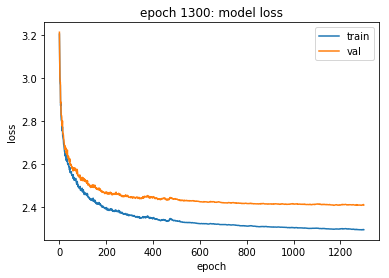

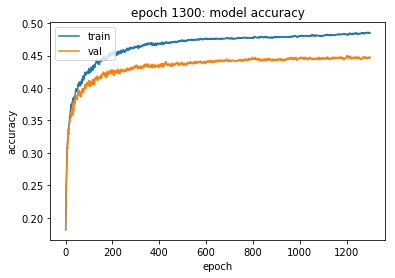



Epoch 1301/2000 ...........
Loss train: 2.296007261162298 
Loss val: 2.41132337447103 
Train accuracy :  0.486525 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 1302/2000 ...........
Loss train: 2.2952194788677716 
Loss val: 2.410990804055321 
Train accuracy :  0.48495 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 1303/2000 ...........
Loss train: 2.2950608965872905 
Loss val: 2.410968978465652 
Train accuracy :  0.485275 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 1304/2000 ...........
Loss train: 2.2942381267470964 
Loss val: 2.4096006857338836 
Train accuracy :  0.48535 
Validation accuracy :  0.4487
Alpha:  0.2


Epoch 1305/2000 ...........
Loss train: 2.294461677263395 
Loss val: 2.4093539798286745 
Train accuracy :  0.4853 
Validation accuracy :  0.448
Alpha:  0.2


Epoch 1306/2000 ...........
Loss train: 2.2941492967984014 
Loss val: 2.409139764865503 
Train accuracy :  0.484925 
Validation accuracy :  0.448
Alpha:  0.2


Epoch 1307/2000 ...........
Loss train:

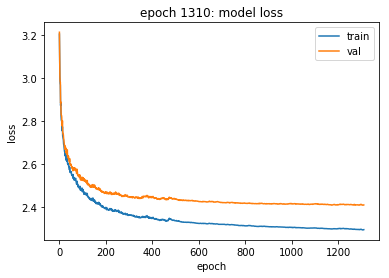

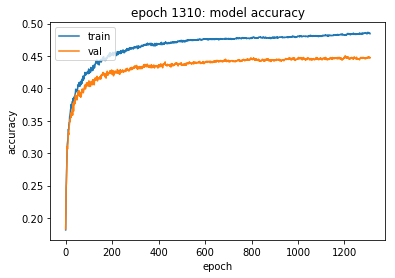



Epoch 1311/2000 ...........
Loss train: 2.2957138666125423 
Loss val: 2.4101921316039077 
Train accuracy :  0.485425 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 1312/2000 ...........
Loss train: 2.2958929563052743 
Loss val: 2.4109591360562153 
Train accuracy :  0.48435 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1313/2000 ...........
Loss train: 2.2954960929220185 
Loss val: 2.410477659026147 
Train accuracy :  0.484725 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 1314/2000 ...........
Loss train: 2.2958042150748748 
Loss val: 2.410805607501971 
Train accuracy :  0.485775 
Validation accuracy :  0.4458
Alpha:  0.2


Epoch 1315/2000 ...........
Loss train: 2.2950203052415925 
Loss val: 2.4102092328790126 
Train accuracy :  0.48535 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 1316/2000 ...........
Loss train: 2.295255150680545 
Loss val: 2.4104410481550147 
Train accuracy :  0.48495 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1317/2000 ...........
Loss 

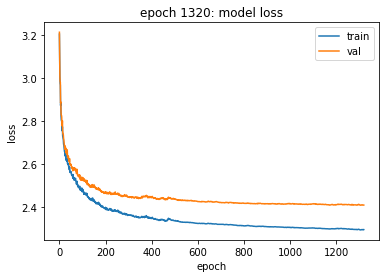

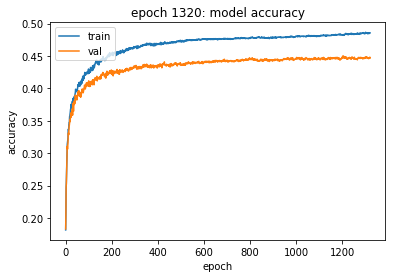



Epoch 1321/2000 ...........
Loss train: 2.295463078818802 
Loss val: 2.4099938273600126 
Train accuracy :  0.48495 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 1322/2000 ...........
Loss train: 2.2955649372844356 
Loss val: 2.4100421304181494 
Train accuracy :  0.4854 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 1323/2000 ...........
Loss train: 2.295062553563 
Loss val: 2.4090964329208906 
Train accuracy :  0.4851 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1324/2000 ...........
Loss train: 2.2950527873013047 
Loss val: 2.409636636523635 
Train accuracy :  0.485575 
Validation accuracy :  0.4477
Alpha:  0.2


Epoch 1325/2000 ...........
Loss train: 2.2951392298334934 
Loss val: 2.4102209809327397 
Train accuracy :  0.4857 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 1326/2000 ...........
Loss train: 2.2949997856423114 
Loss val: 2.4102872811210947 
Train accuracy :  0.484825 
Validation accuracy :  0.4466
Alpha:  0.2


Epoch 1327/2000 ...........
Loss train:

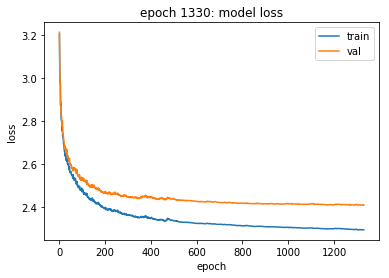

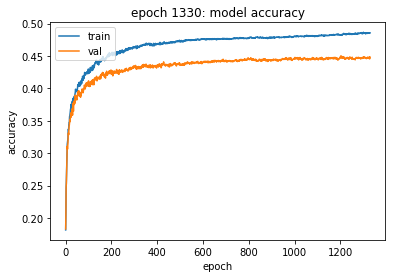



Epoch 1331/2000 ...........
Loss train: 2.2940455856022797 
Loss val: 2.4095898409011047 
Train accuracy :  0.485175 
Validation accuracy :  0.4461
Alpha:  0.2


Epoch 1332/2000 ...........
Loss train: 2.2940244262300578 
Loss val: 2.4097164385833008 
Train accuracy :  0.48585 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 1333/2000 ...........
Loss train: 2.294208975191984 
Loss val: 2.410254009588131 
Train accuracy :  0.48575 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 1334/2000 ...........
Loss train: 2.294207376760884 
Loss val: 2.410305589030455 
Train accuracy :  0.484875 
Validation accuracy :  0.4455
Alpha:  0.2


Epoch 1335/2000 ...........
Loss train: 2.2947372549618636 
Loss val: 2.4115401632577416 
Train accuracy :  0.4854 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 1336/2000 ...........
Loss train: 2.294441220200431 
Loss val: 2.4108073715697014 
Train accuracy :  0.486125 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 1337/2000 ...........
Loss tra

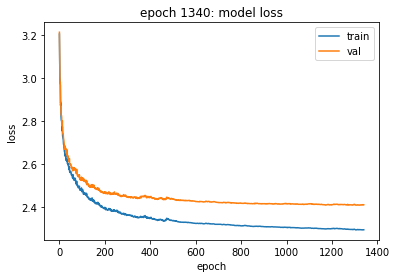

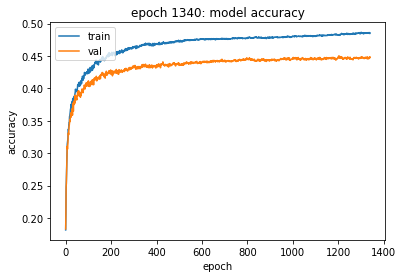



Epoch 1341/2000 ...........
Loss train: 2.2945675148058404 
Loss val: 2.4112689311272693 
Train accuracy :  0.484475 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 1342/2000 ...........
Loss train: 2.2945859853501482 
Loss val: 2.410900221960125 
Train accuracy :  0.48545 
Validation accuracy :  0.4484
Alpha:  0.2


Epoch 1343/2000 ...........
Loss train: 2.2942668167789173 
Loss val: 2.411271410421842 
Train accuracy :  0.485075 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 1344/2000 ...........
Loss train: 2.2946472948475525 
Loss val: 2.410894722401178 
Train accuracy :  0.484725 
Validation accuracy :  0.4483
Alpha:  0.2


Epoch 1345/2000 ...........
Loss train: 2.294960642923591 
Loss val: 2.4106012136208994 
Train accuracy :  0.485425 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 1346/2000 ...........
Loss train: 2.294937580960721 
Loss val: 2.411075513548864 
Train accuracy :  0.485375 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 1347/2000 ...........
Loss 

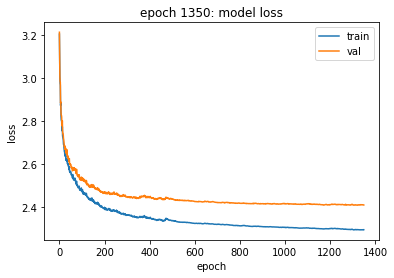

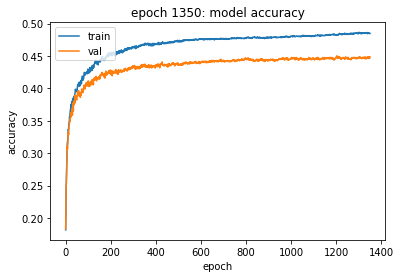



Epoch 1351/2000 ...........
Loss train: 2.2942101428355275 
Loss val: 2.409159104042264 
Train accuracy :  0.486125 
Validation accuracy :  0.4479
Alpha:  0.2


Epoch 1352/2000 ...........
Loss train: 2.294051367890687 
Loss val: 2.409016547848759 
Train accuracy :  0.485225 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 1353/2000 ...........
Loss train: 2.2939150907901333 
Loss val: 2.4091764373288984 
Train accuracy :  0.485525 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 1354/2000 ...........
Loss train: 2.293752697087335 
Loss val: 2.408788983974012 
Train accuracy :  0.4856 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 1355/2000 ...........
Loss train: 2.2933835842064885 
Loss val: 2.4090414918765215 
Train accuracy :  0.485875 
Validation accuracy :  0.4476
Alpha:  0.2


Epoch 1356/2000 ...........
Loss train: 2.2932587525710977 
Loss val: 2.4091778298892885 
Train accuracy :  0.485525 
Validation accuracy :  0.4488
Alpha:  0.2


Epoch 1357/2000 ...........
Loss 

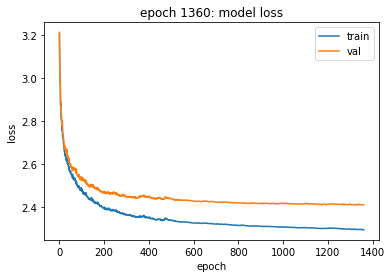

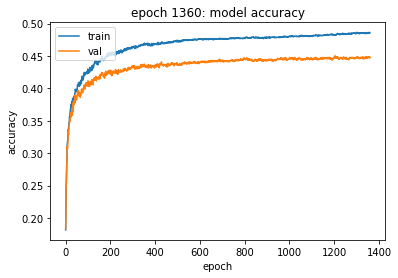



Epoch 1361/2000 ...........
Loss train: 2.2932729620928645 
Loss val: 2.409721414829637 
Train accuracy :  0.485825 
Validation accuracy :  0.4475
Alpha:  0.2


Epoch 1362/2000 ...........
Loss train: 2.293919683055217 
Loss val: 2.410411621469531 
Train accuracy :  0.485725 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 1363/2000 ...........
Loss train: 2.2944341877739873 
Loss val: 2.4111360179808212 
Train accuracy :  0.485175 
Validation accuracy :  0.4469
Alpha:  0.2


Epoch 1364/2000 ...........
Loss train: 2.2943839797141017 
Loss val: 2.410589317873528 
Train accuracy :  0.484925 
Validation accuracy :  0.4462
Alpha:  0.2


Epoch 1365/2000 ...........
Loss train: 2.293457739855024 
Loss val: 2.410140790443154 
Train accuracy :  0.4854 
Validation accuracy :  0.4474
Alpha:  0.2


Epoch 1366/2000 ...........
Loss train: 2.292540138613145 
Loss val: 2.409094887820514 
Train accuracy :  0.48565 
Validation accuracy :  0.4478
Alpha:  0.2


Epoch 1367/2000 ...........
Loss trai

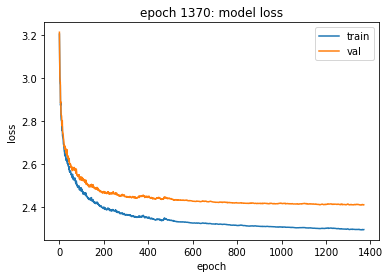

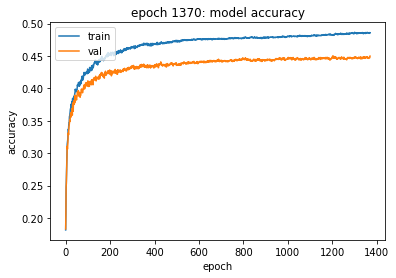



Epoch 1371/2000 ...........
Loss train: 2.2941396991279235 
Loss val: 2.4099951037014953 
Train accuracy :  0.484525 
Validation accuracy :  0.4493
Alpha:  0.2


Epoch 1372/2000 ...........
Loss train: 2.293992879691689 
Loss val: 2.4095362825920392 
Train accuracy :  0.484975 
Validation accuracy :  0.4486
Alpha:  0.2


Epoch 1373/2000 ...........
Loss train: 2.2943557350187263 
Loss val: 2.410018803879182 
Train accuracy :  0.48495 
Validation accuracy :  0.4471
Alpha:  0.2


Epoch 1374/2000 ...........
Loss train: 2.2941913207703997 
Loss val: 2.409899925215993 
Train accuracy :  0.485175 
Validation accuracy :  0.4485
Alpha:  0.2


Epoch 1375/2000 ...........
Loss train: 2.2935125371028917 
Loss val: 2.4085087714696347 
Train accuracy :  0.485675 
Validation accuracy :  0.449
Alpha:  0.2


Epoch 1376/2000 ...........
Loss train: 2.2940990285659772 
Loss val: 2.408921430750304 
Train accuracy :  0.48575 
Validation accuracy :  0.4491
Alpha:  0.2


Epoch 1377/2000 ...........
Loss 

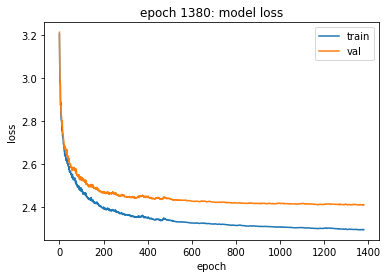

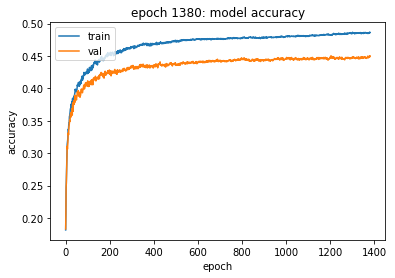



Epoch 1381/2000 ...........
Loss train: 2.293589201607398 
Loss val: 2.4094007879262365 
Train accuracy :  0.485725 
Validation accuracy :  0.4496
Alpha:  0.2


Epoch 1382/2000 ...........
Loss train: 2.293716010569616 
Loss val: 2.4093203608810803 
Train accuracy :  0.485675 
Validation accuracy :  0.4507
Alpha:  0.2


Epoch 1383/2000 ...........
Loss train: 2.293284577460621 
Loss val: 2.4087987420278307 
Train accuracy :  0.48585 
Validation accuracy :  0.4508
Alpha:  0.2


Epoch 1384/2000 ...........
Loss train: 2.293157099778519 
Loss val: 2.4090327265568283 
Train accuracy :  0.48625 
Validation accuracy :  0.4506
Alpha:  0.2


Epoch 1385/2000 ...........
Loss train: 2.292520509290231 
Loss val: 2.4081997880030435 
Train accuracy :  0.4866 
Validation accuracy :  0.451
Alpha:  0.2


Epoch 1386/2000 ...........
Loss train: 2.2918068180341047 
Loss val: 2.4071329344721666 
Train accuracy :  0.48765 
Validation accuracy :  0.4513
Alpha:  0.2


Epoch 1387/2000 ...........
Loss trai

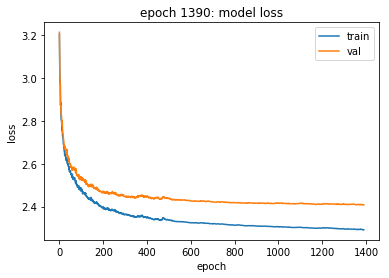

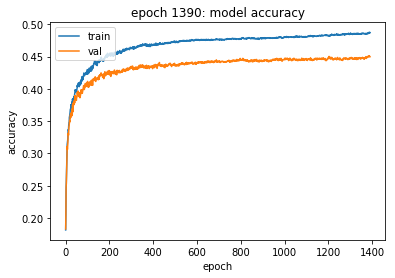



Epoch 1391/2000 ...........
Loss train: 2.291671125726945 
Loss val: 2.408537418016402 
Train accuracy :  0.486625 
Validation accuracy :  0.449
Alpha:  0.2


Epoch 1392/2000 ...........
Loss train: 2.2916474063741705 
Loss val: 2.408311240339679 
Train accuracy :  0.486925 
Validation accuracy :  0.4494
Alpha:  0.2


Epoch 1393/2000 ...........
Loss train: 2.2913929863216627 
Loss val: 2.4082331554328857 
Train accuracy :  0.48685 
Validation accuracy :  0.4494
Alpha:  0.2


Epoch 1394/2000 ...........
Loss train: 2.2919588687284085 
Loss val: 2.4086291814550562 
Train accuracy :  0.486975 
Validation accuracy :  0.45
Alpha:  0.2


Epoch 1395/2000 ...........
Loss train: 2.292260644335865 
Loss val: 2.4082366853591766 
Train accuracy :  0.486775 
Validation accuracy :  0.4511
Alpha:  0.2


Epoch 1396/2000 ...........
Loss train: 2.2919970086257977 
Loss val: 2.408213254610217 
Train accuracy :  0.486425 
Validation accuracy :  0.4497
Alpha:  0.2


Epoch 1397/2000 ...........
Loss tr

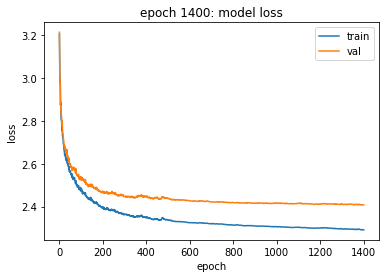

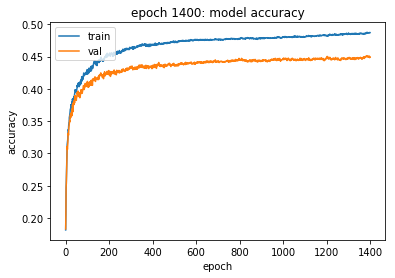



Epoch 1401/2000 ...........
Loss train: 2.290741352344389 
Loss val: 2.4070551567713356 
Train accuracy :  0.4873 
Validation accuracy :  0.45
Alpha:  0.2


Epoch 1402/2000 ...........
Loss train: 2.290687597488002 
Loss val: 2.406741223019097 
Train accuracy :  0.487075 
Validation accuracy :  0.449
Alpha:  0.2


Epoch 1403/2000 ...........
Loss train: 2.2910233720957316 
Loss val: 2.407514630908115 
Train accuracy :  0.48635 
Validation accuracy :  0.4487
Alpha:  0.2


Epoch 1404/2000 ...........
Loss train: 2.2909373454713378 
Loss val: 2.407616896989388 
Train accuracy :  0.4861 
Validation accuracy :  0.4487
Alpha:  0.2


Epoch 1405/2000 ...........
Loss train: 2.2906822166160454 
Loss val: 2.4067786499052 
Train accuracy :  0.487175 
Validation accuracy :  0.4494
Alpha:  0.2


Epoch 1406/2000 ...........
Loss train: 2.2905816542202153 
Loss val: 2.406467044984908 
Train accuracy :  0.486925 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1407/2000 ...........
Loss train: 2.2

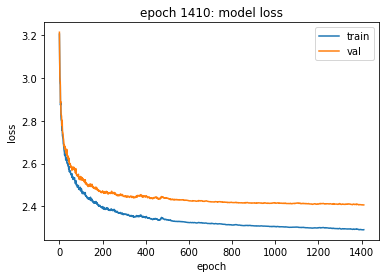

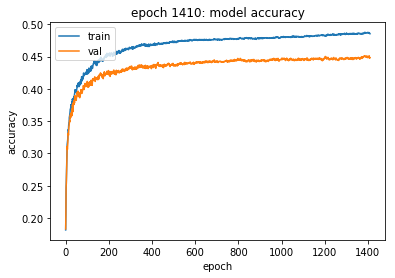



Epoch 1411/2000 ...........
Loss train: 2.2900122662434343 
Loss val: 2.406230876029443 
Train accuracy :  0.486 
Validation accuracy :  0.4491
Alpha:  0.2


Epoch 1412/2000 ...........
Loss train: 2.2892635049525256 
Loss val: 2.405463994049821 
Train accuracy :  0.486675 
Validation accuracy :  0.4495
Alpha:  0.2


Epoch 1413/2000 ...........
Loss train: 2.2894202271269104 
Loss val: 2.405617678163002 
Train accuracy :  0.486 
Validation accuracy :  0.4484
Alpha:  0.2


Epoch 1414/2000 ...........
Loss train: 2.289226236812079 
Loss val: 2.4049574720319757 
Train accuracy :  0.4868 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1415/2000 ...........
Loss train: 2.289347714195424 
Loss val: 2.405664730017881 
Train accuracy :  0.4857 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1416/2000 ...........
Loss train: 2.2891887520334566 
Loss val: 2.4054871884529967 
Train accuracy :  0.4873 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1417/2000 ...........
Loss train: 2.28

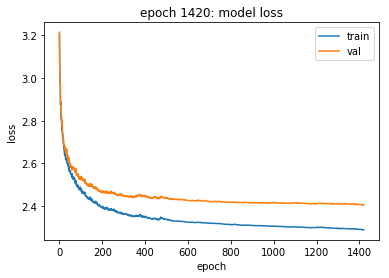

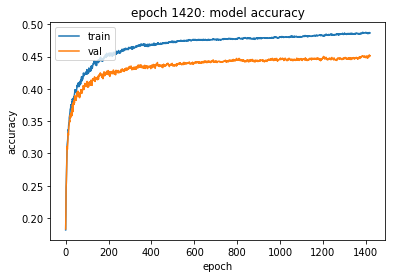



Epoch 1421/2000 ...........
Loss train: 2.2885618752683 
Loss val: 2.40548796528745 
Train accuracy :  0.4862 
Validation accuracy :  0.4507
Alpha:  0.2


Epoch 1422/2000 ...........
Loss train: 2.2885057178326944 
Loss val: 2.406085006588607 
Train accuracy :  0.4869 
Validation accuracy :  0.45
Alpha:  0.2


Epoch 1423/2000 ...........
Loss train: 2.288811012635177 
Loss val: 2.4066910037208245 
Train accuracy :  0.48665 
Validation accuracy :  0.4499
Alpha:  0.2


Epoch 1424/2000 ...........
Loss train: 2.288348755599816 
Loss val: 2.405566373636633 
Train accuracy :  0.4871 
Validation accuracy :  0.4501
Alpha:  0.2


Epoch 1425/2000 ...........
Loss train: 2.2883214170247927 
Loss val: 2.405509920940214 
Train accuracy :  0.4868 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1426/2000 ...........
Loss train: 2.2880971007384114 
Loss val: 2.404637776532947 
Train accuracy :  0.4869 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1427/2000 ...........
Loss train: 2.28780192

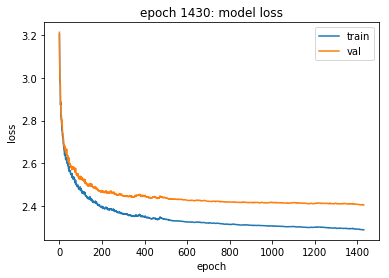

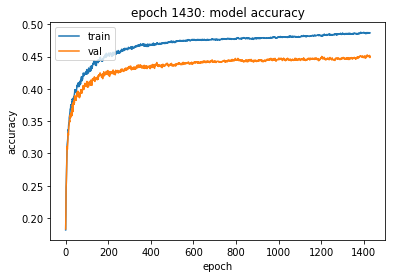



Epoch 1431/2000 ...........
Loss train: 2.2875435529430335 
Loss val: 2.403761397723652 
Train accuracy :  0.48665 
Validation accuracy :  0.4495
Alpha:  0.2


Epoch 1432/2000 ...........
Loss train: 2.288044934297198 
Loss val: 2.403938849258592 
Train accuracy :  0.486275 
Validation accuracy :  0.4485
Alpha:  0.2


Epoch 1433/2000 ...........
Loss train: 2.2874104013192844 
Loss val: 2.403749366295818 
Train accuracy :  0.4864 
Validation accuracy :  0.4497
Alpha:  0.2


Epoch 1434/2000 ...........
Loss train: 2.2876371454150237 
Loss val: 2.403616531771212 
Train accuracy :  0.4869 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1435/2000 ...........
Loss train: 2.2872530341307975 
Loss val: 2.403468934933683 
Train accuracy :  0.486075 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1436/2000 ...........
Loss train: 2.2876445136471264 
Loss val: 2.40433107658415 
Train accuracy :  0.485625 
Validation accuracy :  0.4497
Alpha:  0.2


Epoch 1437/2000 ...........
Loss train:

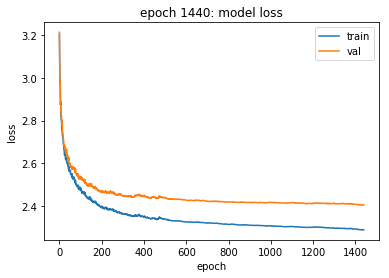

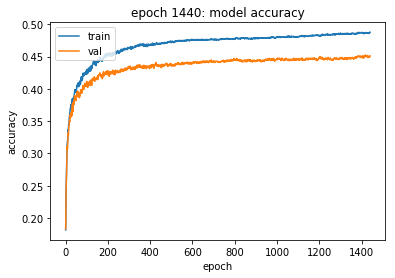



Epoch 1441/2000 ...........
Loss train: 2.28752292815167 
Loss val: 2.4047947524406164 
Train accuracy :  0.48685 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1442/2000 ...........
Loss train: 2.2875317961108865 
Loss val: 2.4053463596127105 
Train accuracy :  0.487325 
Validation accuracy :  0.4508
Alpha:  0.2


Epoch 1443/2000 ...........
Loss train: 2.2880673805968077 
Loss val: 2.4052360949804954 
Train accuracy :  0.48715 
Validation accuracy :  0.4509
Alpha:  0.2


Epoch 1444/2000 ...........
Loss train: 2.287862368646381 
Loss val: 2.4046756490010024 
Train accuracy :  0.4871 
Validation accuracy :  0.4495
Alpha:  0.2


Epoch 1445/2000 ...........
Loss train: 2.2876870128515026 
Loss val: 2.4049299356667406 
Train accuracy :  0.487 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1446/2000 ...........
Loss train: 2.287750175804618 
Loss val: 2.4049150566765247 
Train accuracy :  0.486725 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1447/2000 ...........
Loss trai

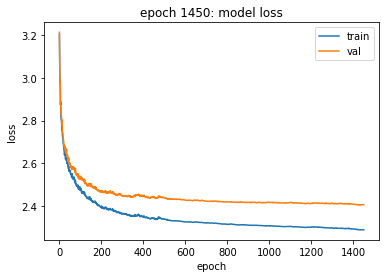

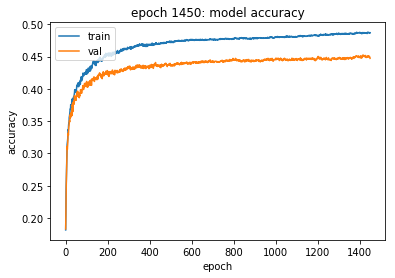



Epoch 1451/2000 ...........
Loss train: 2.28722412730153 
Loss val: 2.405334839513541 
Train accuracy :  0.486525 
Validation accuracy :  0.448
Alpha:  0.2


Epoch 1452/2000 ...........
Loss train: 2.286857605502761 
Loss val: 2.404565048179913 
Train accuracy :  0.48725 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1453/2000 ...........
Loss train: 2.2870702993893652 
Loss val: 2.405225383863587 
Train accuracy :  0.48785 
Validation accuracy :  0.4496
Alpha:  0.2


Epoch 1454/2000 ...........
Loss train: 2.287021897438051 
Loss val: 2.4048553988569585 
Train accuracy :  0.48695 
Validation accuracy :  0.4501
Alpha:  0.2


Epoch 1455/2000 ...........
Loss train: 2.2876100457038837 
Loss val: 2.4052412746002214 
Train accuracy :  0.487175 
Validation accuracy :  0.4493
Alpha:  0.2


Epoch 1456/2000 ...........
Loss train: 2.2872451995077085 
Loss val: 2.405489416093346 
Train accuracy :  0.4867 
Validation accuracy :  0.4519
Alpha:  0.2


Epoch 1457/2000 ...........
Loss train: 

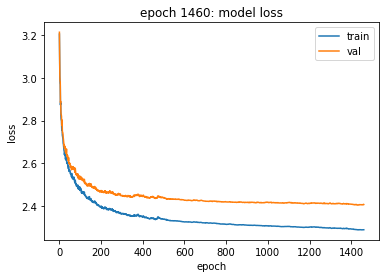

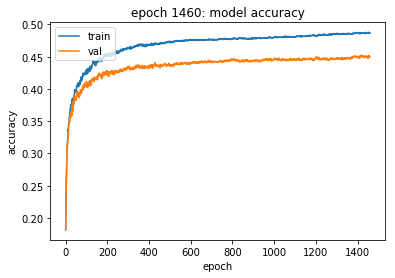



Epoch 1461/2000 ...........
Loss train: 2.287255682807269 
Loss val: 2.4054445847681216 
Train accuracy :  0.48655 
Validation accuracy :  0.4498
Alpha:  0.2


Epoch 1462/2000 ...........
Loss train: 2.2872649081657257 
Loss val: 2.4057583184976474 
Train accuracy :  0.486675 
Validation accuracy :  0.4489
Alpha:  0.2


Epoch 1463/2000 ...........
Loss train: 2.2869046976027434 
Loss val: 2.405189033006491 
Train accuracy :  0.487525 
Validation accuracy :  0.4494
Alpha:  0.2


Epoch 1464/2000 ...........
Loss train: 2.287199175474483 
Loss val: 2.4052295935099823 
Train accuracy :  0.48675 
Validation accuracy :  0.4496
Alpha:  0.2


Epoch 1465/2000 ...........
Loss train: 2.286968864012776 
Loss val: 2.4052194225409522 
Train accuracy :  0.486375 
Validation accuracy :  0.4468
Alpha:  0.2


Epoch 1466/2000 ...........
Loss train: 2.287446174296133 
Loss val: 2.405608242545832 
Train accuracy :  0.4872 
Validation accuracy :  0.4481
Alpha:  0.2


Epoch 1467/2000 ...........
Loss tra

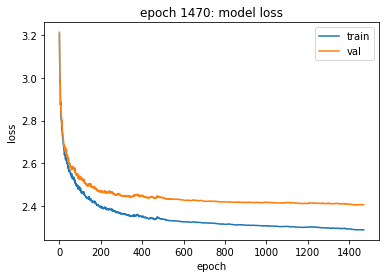

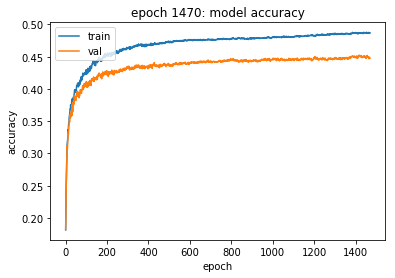



Epoch 1471/2000 ...........
Loss train: 2.2873100779277538 
Loss val: 2.4056896818962823 
Train accuracy :  0.486975 
Validation accuracy :  0.4467
Alpha:  0.2


Epoch 1472/2000 ...........
Loss train: 2.286682658228777 
Loss val: 2.405173440819819 
Train accuracy :  0.48765 
Validation accuracy :  0.4481
Alpha:  0.2


Epoch 1473/2000 ...........
Loss train: 2.286833654372188 
Loss val: 2.4054661993050535 
Train accuracy :  0.487825 
Validation accuracy :  0.4488
Alpha:  0.2


Epoch 1474/2000 ...........
Loss train: 2.286877297012356 
Loss val: 2.4050356176638057 
Train accuracy :  0.488175 
Validation accuracy :  0.4495
Alpha:  0.2


Epoch 1475/2000 ...........
Loss train: 2.286661578439712 
Loss val: 2.405369822207621 
Train accuracy :  0.48775 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 1476/2000 ...........
Loss train: 2.286715634946072 
Loss val: 2.4051370040137803 
Train accuracy :  0.48765 
Validation accuracy :  0.4463
Alpha:  0.2


Epoch 1477/2000 ...........
Loss tra

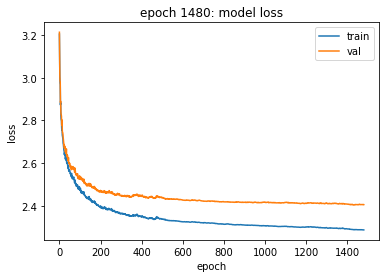

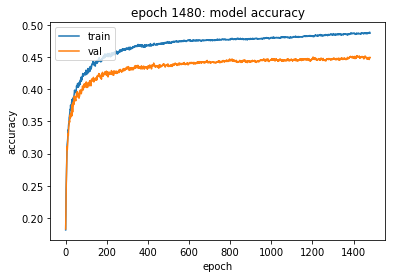



Epoch 1481/2000 ...........
Loss train: 2.285838799067969 
Loss val: 2.40450761353237 
Train accuracy :  0.488025 
Validation accuracy :  0.449
Alpha:  0.2


Epoch 1482/2000 ...........
Loss train: 2.2862285617365123 
Loss val: 2.4044128629561734 
Train accuracy :  0.4883 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1483/2000 ...........
Loss train: 2.2860284171256042 
Loss val: 2.4050152083406786 
Train accuracy :  0.487875 
Validation accuracy :  0.4484
Alpha:  0.2


Epoch 1484/2000 ...........
Loss train: 2.285266077437947 
Loss val: 2.4043514354445725 
Train accuracy :  0.487375 
Validation accuracy :  0.4495
Alpha:  0.2


Epoch 1485/2000 ...........
Loss train: 2.2852847927946973 
Loss val: 2.4049418110628658 
Train accuracy :  0.487825 
Validation accuracy :  0.4498
Alpha:  0.2


Epoch 1486/2000 ...........
Loss train: 2.284989168587972 
Loss val: 2.4047021104859474 
Train accuracy :  0.488175 
Validation accuracy :  0.45
Alpha:  0.2


Epoch 1487/2000 ...........
Loss tra

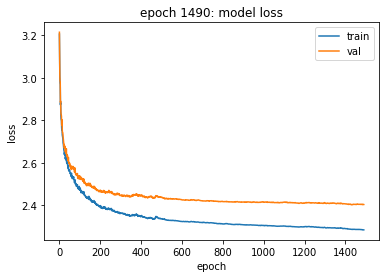

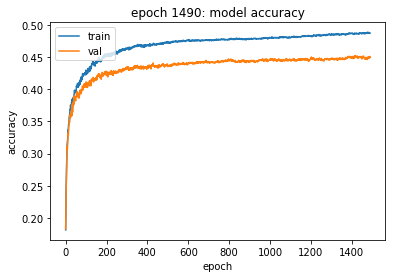



Epoch 1491/2000 ...........
Loss train: 2.2851766531805335 
Loss val: 2.404593568316931 
Train accuracy :  0.488175 
Validation accuracy :  0.4499
Alpha:  0.2


Epoch 1492/2000 ...........
Loss train: 2.2845578158785567 
Loss val: 2.403966174077331 
Train accuracy :  0.4894 
Validation accuracy :  0.4491
Alpha:  0.2


Epoch 1493/2000 ...........
Loss train: 2.2846578472170824 
Loss val: 2.4043733965210308 
Train accuracy :  0.48795 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1494/2000 ...........
Loss train: 2.284740757822541 
Loss val: 2.4042959856791315 
Train accuracy :  0.488725 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1495/2000 ...........
Loss train: 2.2844658476765174 
Loss val: 2.4044707427470864 
Train accuracy :  0.488575 
Validation accuracy :  0.4508
Alpha:  0.2


Epoch 1496/2000 ...........
Loss train: 2.284401440158395 
Loss val: 2.4039979774727764 
Train accuracy :  0.488675 
Validation accuracy :  0.4506
Alpha:  0.2


Epoch 1497/2000 ...........
Loss 

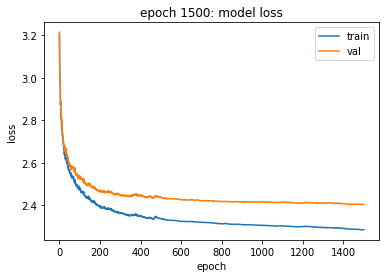

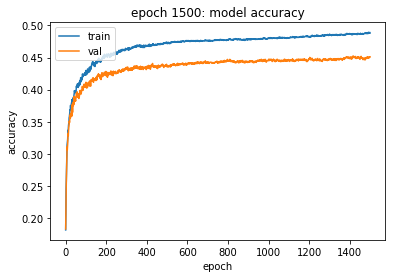



Epoch 1501/2000 ...........
Loss train: 2.284176429348965 
Loss val: 2.4034598144184964 
Train accuracy :  0.4881 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1502/2000 ...........
Loss train: 2.283721451761901 
Loss val: 2.4040216635652194 
Train accuracy :  0.487775 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1503/2000 ...........
Loss train: 2.2840968030940343 
Loss val: 2.4039919328030486 
Train accuracy :  0.488325 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1504/2000 ...........
Loss train: 2.284223801691071 
Loss val: 2.4042551897629263 
Train accuracy :  0.48795 
Validation accuracy :  0.4508
Alpha:  0.2


Epoch 1505/2000 ...........
Loss train: 2.284305511734276 
Loss val: 2.4046593136116754 
Train accuracy :  0.487675 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1506/2000 ...........
Loss train: 2.2841568882673533 
Loss val: 2.4041804753461022 
Train accuracy :  0.489075 
Validation accuracy :  0.451
Alpha:  0.2


Epoch 1507/2000 ...........
Loss t

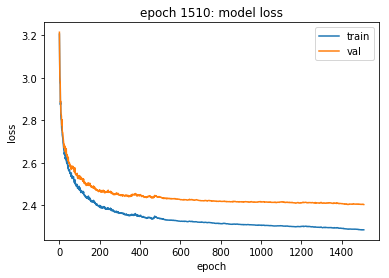

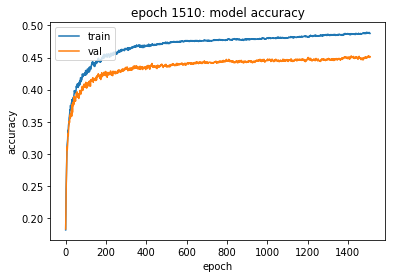



Epoch 1511/2000 ...........
Loss train: 2.2840162714624634 
Loss val: 2.403326182035048 
Train accuracy :  0.4894 
Validation accuracy :  0.4491
Alpha:  0.2


Epoch 1512/2000 ...........
Loss train: 2.283667012468507 
Loss val: 2.40240307846671 
Train accuracy :  0.488325 
Validation accuracy :  0.4508
Alpha:  0.2


Epoch 1513/2000 ...........
Loss train: 2.2839021675245537 
Loss val: 2.4032813010941902 
Train accuracy :  0.488325 
Validation accuracy :  0.4497
Alpha:  0.2


Epoch 1514/2000 ...........
Loss train: 2.2834003694918725 
Loss val: 2.4026121720872133 
Train accuracy :  0.487675 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1515/2000 ...........
Loss train: 2.2835564672603144 
Loss val: 2.4025972734603 
Train accuracy :  0.4881 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1516/2000 ...........
Loss train: 2.2833551025836756 
Loss val: 2.401929800319136 
Train accuracy :  0.4884 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1517/2000 ...........
Loss train: 

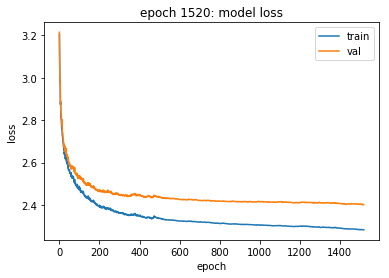

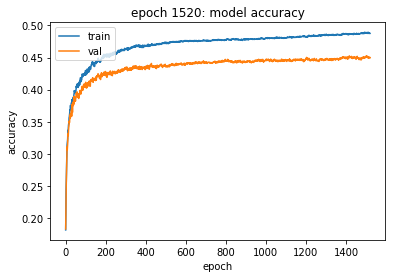



Epoch 1521/2000 ...........
Loss train: 2.2835981820638533 
Loss val: 2.4014504960595295 
Train accuracy :  0.4881 
Validation accuracy :  0.4488
Alpha:  0.2


Epoch 1522/2000 ...........
Loss train: 2.2838442436856266 
Loss val: 2.4011618913247057 
Train accuracy :  0.487875 
Validation accuracy :  0.4498
Alpha:  0.2


Epoch 1523/2000 ...........
Loss train: 2.2842632048388856 
Loss val: 2.4014404247151715 
Train accuracy :  0.487925 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1524/2000 ...........
Loss train: 2.283906099545525 
Loss val: 2.401472045243127 
Train accuracy :  0.4882 
Validation accuracy :  0.4496
Alpha:  0.2


Epoch 1525/2000 ...........
Loss train: 2.2838276395814963 
Loss val: 2.401475248471073 
Train accuracy :  0.488025 
Validation accuracy :  0.4491
Alpha:  0.2


Epoch 1526/2000 ...........
Loss train: 2.284402977461101 
Loss val: 2.4015089714176243 
Train accuracy :  0.488225 
Validation accuracy :  0.4482
Alpha:  0.2


Epoch 1527/2000 ...........
Loss t

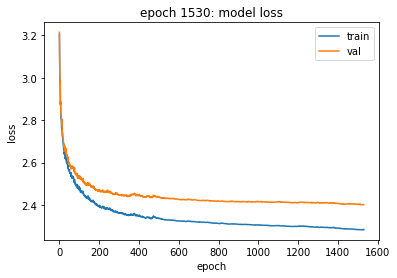

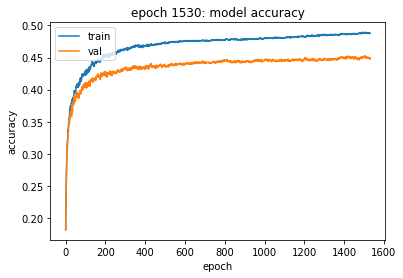



Epoch 1531/2000 ...........
Loss train: 2.2841339429380065 
Loss val: 2.4022163465496758 
Train accuracy :  0.488025 
Validation accuracy :  0.4493
Alpha:  0.2


Epoch 1532/2000 ...........
Loss train: 2.2842029667818946 
Loss val: 2.4022489271628418 
Train accuracy :  0.48735 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1533/2000 ...........
Loss train: 2.284551299366002 
Loss val: 2.4025488577580947 
Train accuracy :  0.487475 
Validation accuracy :  0.452
Alpha:  0.2


Epoch 1534/2000 ...........
Loss train: 2.2851185850562974 
Loss val: 2.4030438816889927 
Train accuracy :  0.487175 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1535/2000 ...........
Loss train: 2.2848201637658767 
Loss val: 2.403163195399511 
Train accuracy :  0.4883 
Validation accuracy :  0.4507
Alpha:  0.2


Epoch 1536/2000 ...........
Loss train: 2.284895469200413 
Loss val: 2.4038666869457206 
Train accuracy :  0.487625 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1537/2000 ...........
Loss 

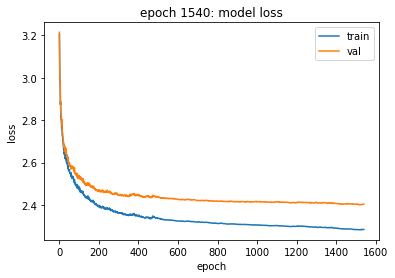

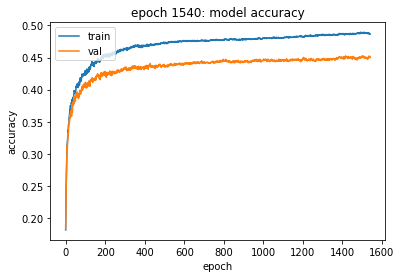



Epoch 1541/2000 ...........
Loss train: 2.2851894549938114 
Loss val: 2.4038345189654526 
Train accuracy :  0.48735 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1542/2000 ...........
Loss train: 2.28507623640312 
Loss val: 2.4038465023930407 
Train accuracy :  0.485875 
Validation accuracy :  0.4506
Alpha:  0.2


Epoch 1543/2000 ...........
Loss train: 2.285061519797609 
Loss val: 2.4041659360446834 
Train accuracy :  0.487275 
Validation accuracy :  0.4498
Alpha:  0.2


Epoch 1544/2000 ...........
Loss train: 2.2847040553826594 
Loss val: 2.403640389880795 
Train accuracy :  0.48675 
Validation accuracy :  0.4493
Alpha:  0.2


Epoch 1545/2000 ...........
Loss train: 2.284842331231527 
Loss val: 2.4033700217523752 
Train accuracy :  0.486925 
Validation accuracy :  0.4497
Alpha:  0.2


Epoch 1546/2000 ...........
Loss train: 2.2844977302166845 
Loss val: 2.4028685388604836 
Train accuracy :  0.487075 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1547/2000 ...........
Loss 

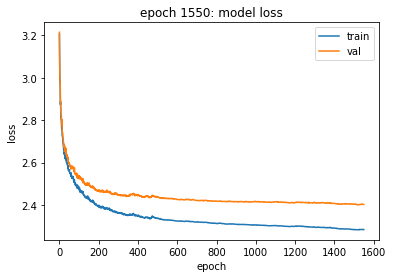

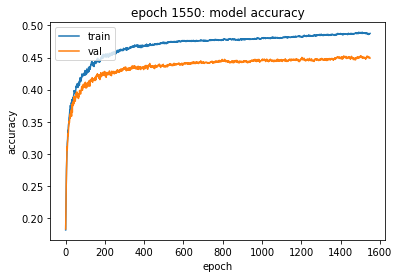



Epoch 1551/2000 ...........
Loss train: 2.284299683380436 
Loss val: 2.4030533700082555 
Train accuracy :  0.486525 
Validation accuracy :  0.4497
Alpha:  0.2


Epoch 1552/2000 ...........
Loss train: 2.2846990817495576 
Loss val: 2.4039617830634135 
Train accuracy :  0.4875 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1553/2000 ...........
Loss train: 2.2846448600404723 
Loss val: 2.404094750345432 
Train accuracy :  0.48695 
Validation accuracy :  0.449
Alpha:  0.2


Epoch 1554/2000 ...........
Loss train: 2.2846772623906038 
Loss val: 2.4037889867948077 
Train accuracy :  0.48735 
Validation accuracy :  0.4488
Alpha:  0.2


Epoch 1555/2000 ...........
Loss train: 2.284475087394868 
Loss val: 2.403742117881592 
Train accuracy :  0.48705 
Validation accuracy :  0.4508
Alpha:  0.2


Epoch 1556/2000 ...........
Loss train: 2.284991473890252 
Loss val: 2.404368116218574 
Train accuracy :  0.4875 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1557/2000 ...........
Loss train: 

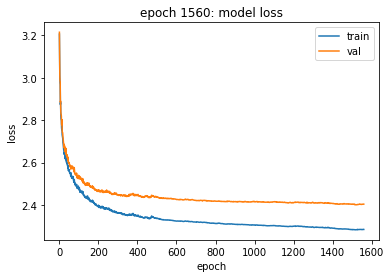

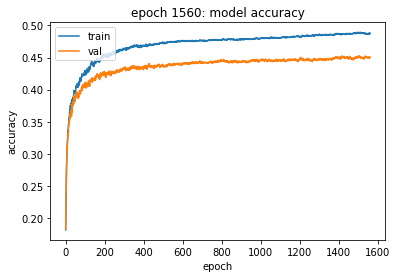



Epoch 1561/2000 ...........
Loss train: 2.2843680702351006 
Loss val: 2.4031276833351214 
Train accuracy :  0.487675 
Validation accuracy :  0.4496
Alpha:  0.2


Epoch 1562/2000 ...........
Loss train: 2.284394939293408 
Loss val: 2.4034743459419095 
Train accuracy :  0.486625 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1563/2000 ...........
Loss train: 2.284191972774418 
Loss val: 2.403898242879481 
Train accuracy :  0.4877 
Validation accuracy :  0.451
Alpha:  0.2


Epoch 1564/2000 ...........
Loss train: 2.2844510681895125 
Loss val: 2.4040699201880207 
Train accuracy :  0.487825 
Validation accuracy :  0.4498
Alpha:  0.2


Epoch 1565/2000 ...........
Loss train: 2.283641578956593 
Loss val: 2.4026915364997325 
Train accuracy :  0.4886 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1566/2000 ...........
Loss train: 2.283698134720055 
Loss val: 2.4028394073255663 
Train accuracy :  0.488575 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1567/2000 ...........
Loss tra

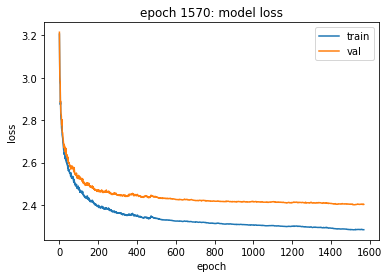

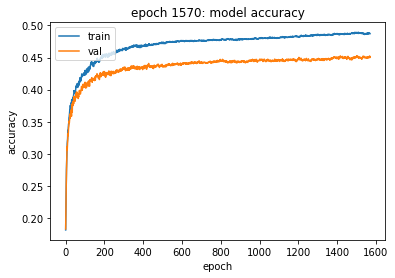



Epoch 1571/2000 ...........
Loss train: 2.283664282276243 
Loss val: 2.403388182557458 
Train accuracy :  0.486875 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1572/2000 ...........
Loss train: 2.2839337186187456 
Loss val: 2.403568881882472 
Train accuracy :  0.487725 
Validation accuracy :  0.4509
Alpha:  0.2


Epoch 1573/2000 ...........
Loss train: 2.283690966711423 
Loss val: 2.4034051458200274 
Train accuracy :  0.48835 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1574/2000 ...........
Loss train: 2.2830939774334826 
Loss val: 2.4032464396535684 
Train accuracy :  0.488575 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1575/2000 ...........
Loss train: 2.28313512980892 
Loss val: 2.4029820770017905 
Train accuracy :  0.48805 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1576/2000 ...........
Loss train: 2.283257239522367 
Loss val: 2.4031485864995257 
Train accuracy :  0.488225 
Validation accuracy :  0.4516
Alpha:  0.2


Epoch 1577/2000 ...........
Loss tr

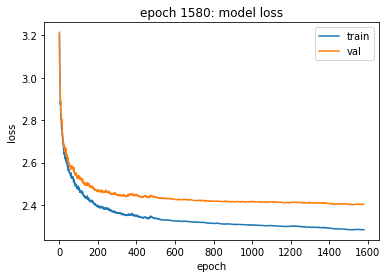

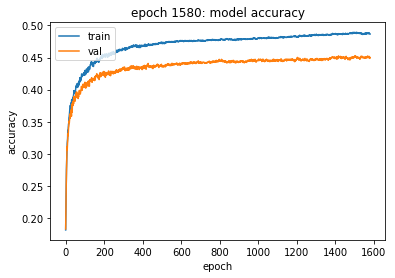



Epoch 1581/2000 ...........
Loss train: 2.2831729831413186 
Loss val: 2.4041022247788733 
Train accuracy :  0.4873 
Validation accuracy :  0.4518
Alpha:  0.2


Epoch 1582/2000 ...........
Loss train: 2.2832174768864117 
Loss val: 2.40406763639642 
Train accuracy :  0.488325 
Validation accuracy :  0.453
Alpha:  0.2


Epoch 1583/2000 ...........
Loss train: 2.282821262074308 
Loss val: 2.403233265199302 
Train accuracy :  0.487875 
Validation accuracy :  0.4511
Alpha:  0.2


Epoch 1584/2000 ...........
Loss train: 2.282569827141846 
Loss val: 2.4023164039504263 
Train accuracy :  0.487875 
Validation accuracy :  0.4516
Alpha:  0.2


Epoch 1585/2000 ...........
Loss train: 2.282280518301546 
Loss val: 2.4017918076722586 
Train accuracy :  0.4882 
Validation accuracy :  0.4507
Alpha:  0.2


Epoch 1586/2000 ...........
Loss train: 2.281766077236634 
Loss val: 2.4015127767015048 
Train accuracy :  0.488625 
Validation accuracy :  0.4507
Alpha:  0.2


Epoch 1587/2000 ...........
Loss train

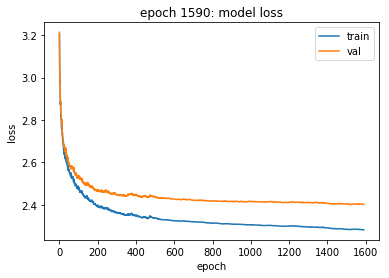

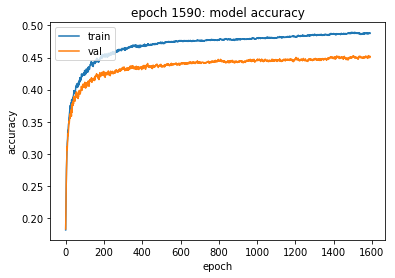



Epoch 1591/2000 ...........
Loss train: 2.2822474632893854 
Loss val: 2.4022798452447 
Train accuracy :  0.487625 
Validation accuracy :  0.4516
Alpha:  0.2


Epoch 1592/2000 ...........
Loss train: 2.2824034692096014 
Loss val: 2.4021236411899825 
Train accuracy :  0.487425 
Validation accuracy :  0.4507
Alpha:  0.2


Epoch 1593/2000 ...........
Loss train: 2.2821622866346116 
Loss val: 2.401703098876891 
Train accuracy :  0.488275 
Validation accuracy :  0.4499
Alpha:  0.2


Epoch 1594/2000 ...........
Loss train: 2.282335736912077 
Loss val: 2.401207974190142 
Train accuracy :  0.4882 
Validation accuracy :  0.4491
Alpha:  0.2


Epoch 1595/2000 ...........
Loss train: 2.2821471204867763 
Loss val: 2.400757241455088 
Train accuracy :  0.488175 
Validation accuracy :  0.451
Alpha:  0.2


Epoch 1596/2000 ...........
Loss train: 2.2827144299499533 
Loss val: 2.4015925032668157 
Train accuracy :  0.487925 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1597/2000 ...........
Loss tra

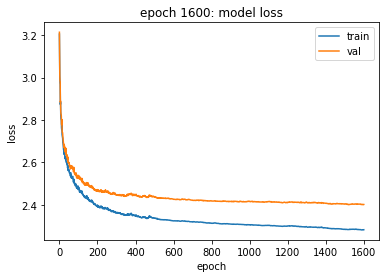

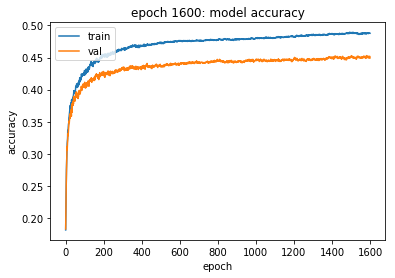



Epoch 1601/2000 ...........
Loss train: 2.28199428414999 
Loss val: 2.4009592331314473 
Train accuracy :  0.48855 
Validation accuracy :  0.4514
Alpha:  0.2


Epoch 1602/2000 ...........
Loss train: 2.2819767603474435 
Loss val: 2.40106974348111 
Train accuracy :  0.4876 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1603/2000 ...........
Loss train: 2.281684402018416 
Loss val: 2.4005399244644203 
Train accuracy :  0.488325 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1604/2000 ...........
Loss train: 2.2817359347362514 
Loss val: 2.400698254315819 
Train accuracy :  0.488875 
Validation accuracy :  0.4514
Alpha:  0.2


Epoch 1605/2000 ...........
Loss train: 2.2823729366189545 
Loss val: 2.4012500291947867 
Train accuracy :  0.488 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1606/2000 ...........
Loss train: 2.282257457320739 
Loss val: 2.4017218155835867 
Train accuracy :  0.4885 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1607/2000 ...........
Loss train: 2

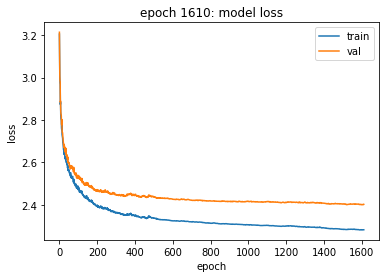

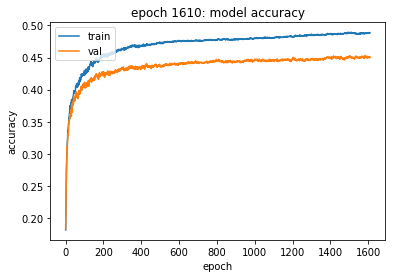



Epoch 1611/2000 ...........
Loss train: 2.2818330508502127 
Loss val: 2.401492263600444 
Train accuracy :  0.4886 
Validation accuracy :  0.4529
Alpha:  0.2


Epoch 1612/2000 ...........
Loss train: 2.2821549741100653 
Loss val: 2.4019184079031124 
Train accuracy :  0.488725 
Validation accuracy :  0.4524
Alpha:  0.2


Epoch 1613/2000 ...........
Loss train: 2.2823521407436647 
Loss val: 2.4030842366169045 
Train accuracy :  0.4885 
Validation accuracy :  0.4517
Alpha:  0.2


Epoch 1614/2000 ...........
Loss train: 2.2827082808271744 
Loss val: 2.402731398181826 
Train accuracy :  0.488775 
Validation accuracy :  0.4527
Alpha:  0.2


Epoch 1615/2000 ...........
Loss train: 2.28278052342232 
Loss val: 2.403135981149014 
Train accuracy :  0.4889 
Validation accuracy :  0.4525
Alpha:  0.2


Epoch 1616/2000 ...........
Loss train: 2.282890117931643 
Loss val: 2.4037457478546322 
Train accuracy :  0.489325 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1617/2000 ...........
Loss train

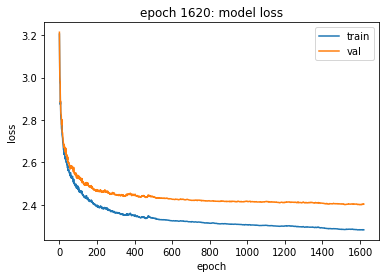

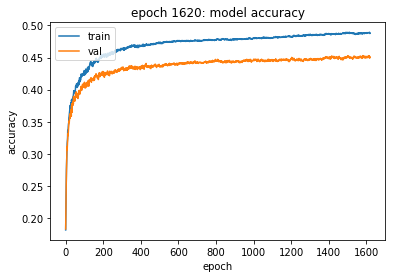



Epoch 1621/2000 ...........
Loss train: 2.28170212044306 
Loss val: 2.4028921450977707 
Train accuracy :  0.488875 
Validation accuracy :  0.4516
Alpha:  0.2


Epoch 1622/2000 ...........
Loss train: 2.2819799498101276 
Loss val: 2.4033742707923724 
Train accuracy :  0.488825 
Validation accuracy :  0.4519
Alpha:  0.2


Epoch 1623/2000 ...........
Loss train: 2.281860574734062 
Loss val: 2.403131842978484 
Train accuracy :  0.488325 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1624/2000 ...........
Loss train: 2.281759955013692 
Loss val: 2.4034766658301145 
Train accuracy :  0.488475 
Validation accuracy :  0.4523
Alpha:  0.2


Epoch 1625/2000 ...........
Loss train: 2.281325709803421 
Loss val: 2.4033001762045267 
Train accuracy :  0.48835 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1626/2000 ...........
Loss train: 2.280957479437159 
Loss val: 2.4034043115173156 
Train accuracy :  0.488125 
Validation accuracy :  0.4494
Alpha:  0.2


Epoch 1627/2000 ...........
Loss t

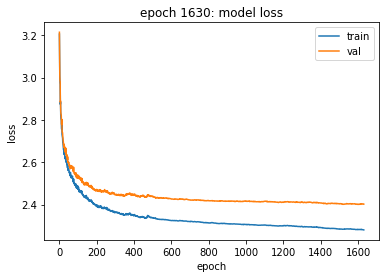

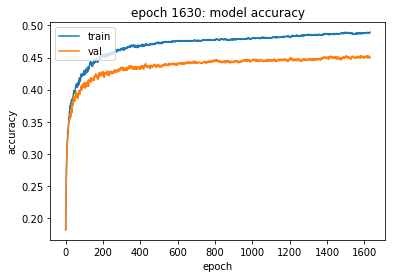



Epoch 1631/2000 ...........
Loss train: 2.2798597609354694 
Loss val: 2.4016447653899227 
Train accuracy :  0.4893 
Validation accuracy :  0.4499
Alpha:  0.2


Epoch 1632/2000 ...........
Loss train: 2.2800255839545858 
Loss val: 2.4020122286347 
Train accuracy :  0.4887 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1633/2000 ...........
Loss train: 2.2799678619569637 
Loss val: 2.401599505151659 
Train accuracy :  0.488875 
Validation accuracy :  0.4507
Alpha:  0.2


Epoch 1634/2000 ...........
Loss train: 2.2795716778285424 
Loss val: 2.4010079871303076 
Train accuracy :  0.4894 
Validation accuracy :  0.4493
Alpha:  0.2


Epoch 1635/2000 ...........
Loss train: 2.279990062944041 
Loss val: 2.4014157465942496 
Train accuracy :  0.488625 
Validation accuracy :  0.451
Alpha:  0.2


Epoch 1636/2000 ...........
Loss train: 2.280088950470834 
Loss val: 2.4020217627089764 
Train accuracy :  0.488525 
Validation accuracy :  0.4516
Alpha:  0.2


Epoch 1637/2000 ...........
Loss train:

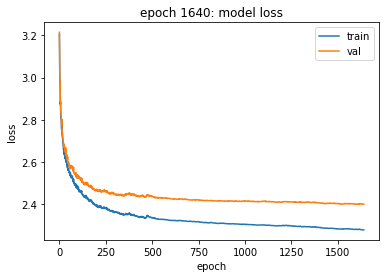

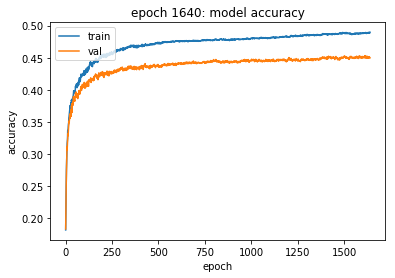



Epoch 1641/2000 ...........
Loss train: 2.279850597865719 
Loss val: 2.4026452933495848 
Train accuracy :  0.488675 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1642/2000 ...........
Loss train: 2.279906132232998 
Loss val: 2.402217048901609 
Train accuracy :  0.488375 
Validation accuracy :  0.449
Alpha:  0.2


Epoch 1643/2000 ...........
Loss train: 2.2804229737497193 
Loss val: 2.4028844073374516 
Train accuracy :  0.48795 
Validation accuracy :  0.4493
Alpha:  0.2


Epoch 1644/2000 ...........
Loss train: 2.280409732783457 
Loss val: 2.4023890188178485 
Train accuracy :  0.489475 
Validation accuracy :  0.4482
Alpha:  0.2


Epoch 1645/2000 ...........
Loss train: 2.280641905941069 
Loss val: 2.4022844814263955 
Train accuracy :  0.489075 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 1646/2000 ...........
Loss train: 2.2803042625994743 
Loss val: 2.4020923652651067 
Train accuracy :  0.488875 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 1647/2000 ...........
Loss t

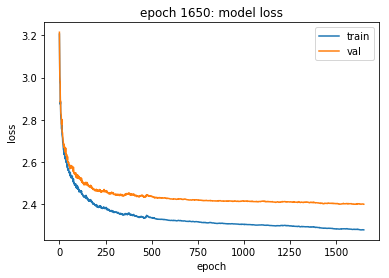

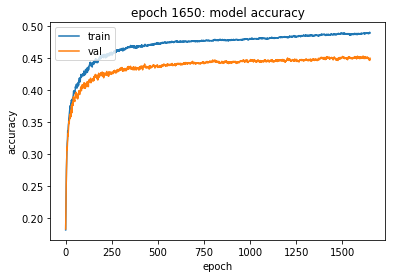



Epoch 1651/2000 ...........
Loss train: 2.2801859719322093 
Loss val: 2.4013998119998794 
Train accuracy :  0.490125 
Validation accuracy :  0.4483
Alpha:  0.2


Epoch 1652/2000 ...........
Loss train: 2.2798998404842927 
Loss val: 2.40135269358593 
Train accuracy :  0.4899 
Validation accuracy :  0.4478
Alpha:  0.2


Epoch 1653/2000 ...........
Loss train: 2.280230546801161 
Loss val: 2.401710189168634 
Train accuracy :  0.48905 
Validation accuracy :  0.4472
Alpha:  0.2


Epoch 1654/2000 ...........
Loss train: 2.279559208549982 
Loss val: 2.4011959445092192 
Train accuracy :  0.490275 
Validation accuracy :  0.4478
Alpha:  0.2


Epoch 1655/2000 ...........
Loss train: 2.2797715375123633 
Loss val: 2.4012246716700774 
Train accuracy :  0.48955 
Validation accuracy :  0.447
Alpha:  0.2


Epoch 1656/2000 ...........
Loss train: 2.2798954962758144 
Loss val: 2.4017124340660962 
Train accuracy :  0.48935 
Validation accuracy :  0.4484
Alpha:  0.2


Epoch 1657/2000 ...........
Loss trai

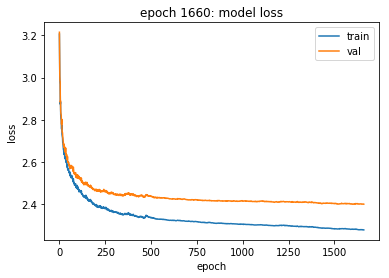

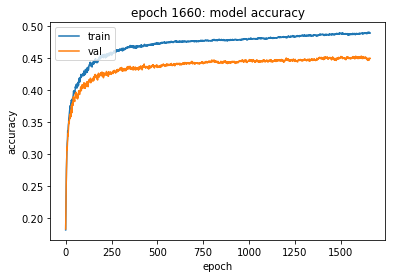



Epoch 1661/2000 ...........
Loss train: 2.278375559662139 
Loss val: 2.399993195497672 
Train accuracy :  0.49015 
Validation accuracy :  0.4495
Alpha:  0.2


Epoch 1662/2000 ...........
Loss train: 2.2781151867845724 
Loss val: 2.3997362975156533 
Train accuracy :  0.48995 
Validation accuracy :  0.45
Alpha:  0.2


Epoch 1663/2000 ...........
Loss train: 2.2779842451760803 
Loss val: 2.3999334251406923 
Train accuracy :  0.49055 
Validation accuracy :  0.4507
Alpha:  0.2


Epoch 1664/2000 ...........
Loss train: 2.2778167356512267 
Loss val: 2.4000579750707884 
Train accuracy :  0.48995 
Validation accuracy :  0.4499
Alpha:  0.2


Epoch 1665/2000 ...........
Loss train: 2.2777133175452264 
Loss val: 2.4005000021368623 
Train accuracy :  0.490625 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1666/2000 ...........
Loss train: 2.2775673313821256 
Loss val: 2.4008107179168263 
Train accuracy :  0.490075 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1667/2000 ...........
Loss t

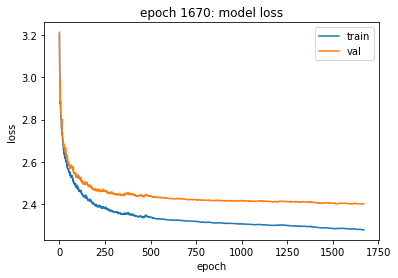

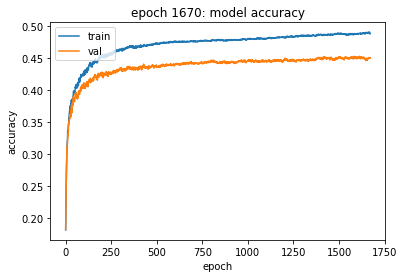



Epoch 1671/2000 ...........
Loss train: 2.278431647920308 
Loss val: 2.401477565063554 
Train accuracy :  0.4897 
Validation accuracy :  0.4513
Alpha:  0.2


Epoch 1672/2000 ...........
Loss train: 2.2785131737990394 
Loss val: 2.4016174196932343 
Train accuracy :  0.490175 
Validation accuracy :  0.4492
Alpha:  0.2


Epoch 1673/2000 ...........
Loss train: 2.2780273245749183 
Loss val: 2.400517813301822 
Train accuracy :  0.488625 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1674/2000 ...........
Loss train: 2.2781919468143688 
Loss val: 2.4005193926791115 
Train accuracy :  0.48975 
Validation accuracy :  0.4511
Alpha:  0.2


Epoch 1675/2000 ...........
Loss train: 2.2783872841703645 
Loss val: 2.401255141945658 
Train accuracy :  0.48965 
Validation accuracy :  0.4499
Alpha:  0.2


Epoch 1676/2000 ...........
Loss train: 2.2785549149749986 
Loss val: 2.401269913751276 
Train accuracy :  0.4889 
Validation accuracy :  0.4509
Alpha:  0.2


Epoch 1677/2000 ...........
Loss trai

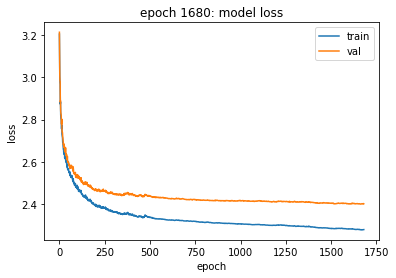

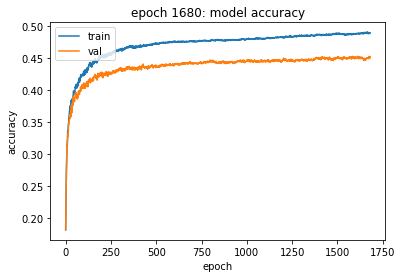



Epoch 1681/2000 ...........
Loss train: 2.2786513282964576 
Loss val: 2.401104876572143 
Train accuracy :  0.489275 
Validation accuracy :  0.4519
Alpha:  0.2


Epoch 1682/2000 ...........
Loss train: 2.278758008379291 
Loss val: 2.4007684862731375 
Train accuracy :  0.4893 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1683/2000 ...........
Loss train: 2.278154711458105 
Loss val: 2.3998341562564462 
Train accuracy :  0.48915 
Validation accuracy :  0.4513
Alpha:  0.2


Epoch 1684/2000 ...........
Loss train: 2.2782901928048696 
Loss val: 2.3998903689230895 
Train accuracy :  0.4895 
Validation accuracy :  0.4513
Alpha:  0.2


Epoch 1685/2000 ...........
Loss train: 2.278438275499107 
Loss val: 2.399943377706095 
Train accuracy :  0.488575 
Validation accuracy :  0.452
Alpha:  0.2


Epoch 1686/2000 ...........
Loss train: 2.278178234460086 
Loss val: 2.399598605487197 
Train accuracy :  0.48935 
Validation accuracy :  0.4514
Alpha:  0.2


Epoch 1687/2000 ...........
Loss train: 

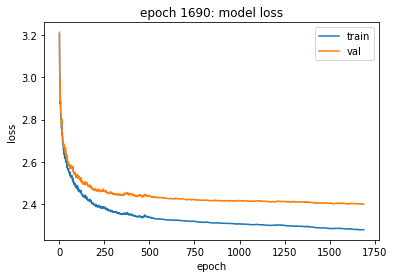

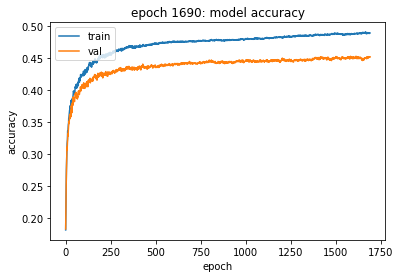



Epoch 1691/2000 ...........
Loss train: 2.2785893752196165 
Loss val: 2.399791035710606 
Train accuracy :  0.4893 
Validation accuracy :  0.4542
Alpha:  0.2


Epoch 1692/2000 ...........
Loss train: 2.2785225403349543 
Loss val: 2.3999002160621212 
Train accuracy :  0.4894 
Validation accuracy :  0.4541
Alpha:  0.2


Epoch 1693/2000 ...........
Loss train: 2.277685581376298 
Loss val: 2.399810770466756 
Train accuracy :  0.489975 
Validation accuracy :  0.4524
Alpha:  0.2


Epoch 1694/2000 ...........
Loss train: 2.2778700318756977 
Loss val: 2.3996775963509265 
Train accuracy :  0.4896 
Validation accuracy :  0.4524
Alpha:  0.2


Epoch 1695/2000 ...........
Loss train: 2.278236596743739 
Loss val: 2.4002223123333515 
Train accuracy :  0.48995 
Validation accuracy :  0.4543
Alpha:  0.2


Epoch 1696/2000 ...........
Loss train: 2.2777531593509646 
Loss val: 2.4005549528897814 
Train accuracy :  0.489975 
Validation accuracy :  0.4535
Alpha:  0.2


Epoch 1697/2000 ...........
Loss trai

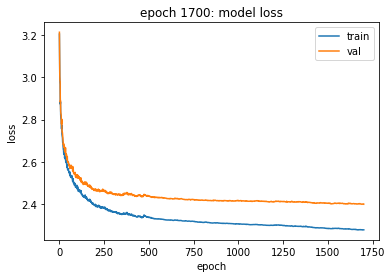

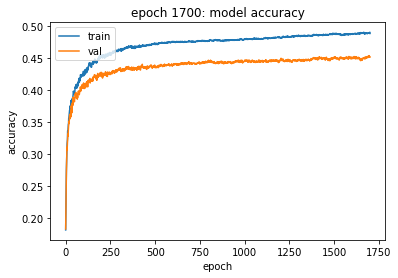



Epoch 1701/2000 ...........
Loss train: 2.277720457300265 
Loss val: 2.3996739581186795 
Train accuracy :  0.4896 
Validation accuracy :  0.4527
Alpha:  0.2


Epoch 1702/2000 ...........
Loss train: 2.2782168202271054 
Loss val: 2.3997039161943112 
Train accuracy :  0.489425 
Validation accuracy :  0.4532
Alpha:  0.2


Epoch 1703/2000 ...........
Loss train: 2.2776338473744016 
Loss val: 2.3994437846860937 
Train accuracy :  0.489925 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1704/2000 ...........
Loss train: 2.2773042371896137 
Loss val: 2.3995175811633773 
Train accuracy :  0.489775 
Validation accuracy :  0.4532
Alpha:  0.2


Epoch 1705/2000 ...........
Loss train: 2.2774338592333647 
Loss val: 2.399341592865546 
Train accuracy :  0.4901 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1706/2000 ...........
Loss train: 2.2776361449696227 
Loss val: 2.3991710864384035 
Train accuracy :  0.489925 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1707/2000 ...........
Loss

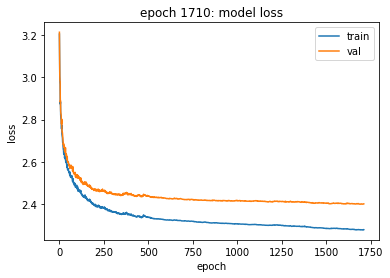

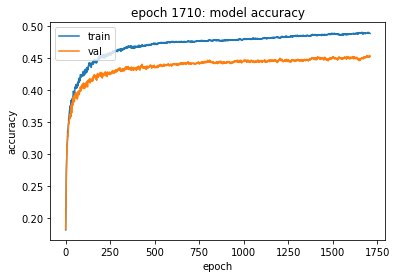



Epoch 1711/2000 ...........
Loss train: 2.278047638947625 
Loss val: 2.400384396526608 
Train accuracy :  0.489475 
Validation accuracy :  0.4527
Alpha:  0.2


Epoch 1712/2000 ...........
Loss train: 2.278517734344827 
Loss val: 2.400644806274745 
Train accuracy :  0.489 
Validation accuracy :  0.454
Alpha:  0.2


Epoch 1713/2000 ...........
Loss train: 2.2781091724666545 
Loss val: 2.400694692827793 
Train accuracy :  0.4897 
Validation accuracy :  0.4521
Alpha:  0.2


Epoch 1714/2000 ...........
Loss train: 2.2777679506019144 
Loss val: 2.400299825440646 
Train accuracy :  0.489025 
Validation accuracy :  0.4531
Alpha:  0.2


Epoch 1715/2000 ...........
Loss train: 2.2779768671207012 
Loss val: 2.4003690109445013 
Train accuracy :  0.4888 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1716/2000 ...........
Loss train: 2.2783004783428797 
Loss val: 2.400941826778051 
Train accuracy :  0.488775 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1717/2000 ...........
Loss train: 2

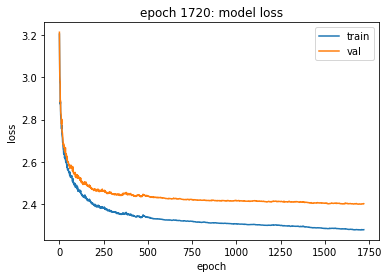

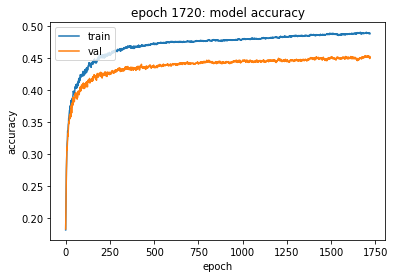



Epoch 1721/2000 ...........
Loss train: 2.2788311848210667 
Loss val: 2.401762789093303 
Train accuracy :  0.489525 
Validation accuracy :  0.4519
Alpha:  0.2


Epoch 1722/2000 ...........
Loss train: 2.2786174632103386 
Loss val: 2.4011770097029195 
Train accuracy :  0.489775 
Validation accuracy :  0.452
Alpha:  0.2


Epoch 1723/2000 ...........
Loss train: 2.27846498837468 
Loss val: 2.401572404845989 
Train accuracy :  0.490125 
Validation accuracy :  0.4517
Alpha:  0.2


Epoch 1724/2000 ...........
Loss train: 2.2778157552551583 
Loss val: 2.401230120679464 
Train accuracy :  0.49005 
Validation accuracy :  0.4513
Alpha:  0.2


Epoch 1725/2000 ...........
Loss train: 2.277780173891922 
Loss val: 2.40139806884772 
Train accuracy :  0.489525 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1726/2000 ...........
Loss train: 2.277463352497145 
Loss val: 2.401001770087781 
Train accuracy :  0.49015 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1727/2000 ...........
Loss train:

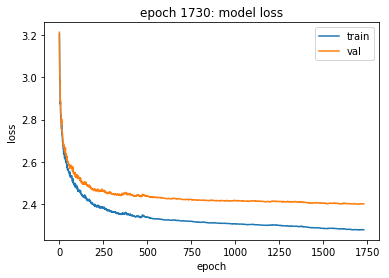

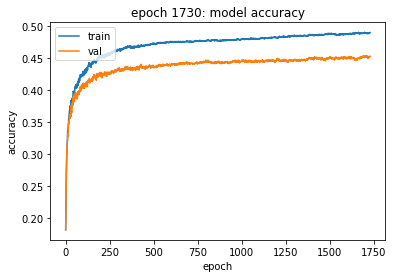



Epoch 1731/2000 ...........
Loss train: 2.2773565354720646 
Loss val: 2.4002319635843463 
Train accuracy :  0.4897 
Validation accuracy :  0.4531
Alpha:  0.2


Epoch 1732/2000 ...........
Loss train: 2.276884002442773 
Loss val: 2.4005001701748068 
Train accuracy :  0.4894 
Validation accuracy :  0.4513
Alpha:  0.2


Epoch 1733/2000 ...........
Loss train: 2.2776593032133006 
Loss val: 2.4000031922977696 
Train accuracy :  0.4892 
Validation accuracy :  0.4523
Alpha:  0.2


Epoch 1734/2000 ...........
Loss train: 2.2773435322921385 
Loss val: 2.3998485068229245 
Train accuracy :  0.489875 
Validation accuracy :  0.4519
Alpha:  0.2


Epoch 1735/2000 ...........
Loss train: 2.276933188769954 
Loss val: 2.39963129255905 
Train accuracy :  0.48985 
Validation accuracy :  0.4519
Alpha:  0.2


Epoch 1736/2000 ...........
Loss train: 2.2767814262759307 
Loss val: 2.399775122370858 
Train accuracy :  0.4895 
Validation accuracy :  0.4519
Alpha:  0.2


Epoch 1737/2000 ...........
Loss train: 

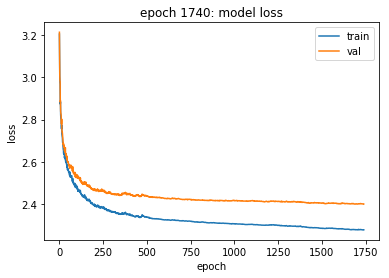

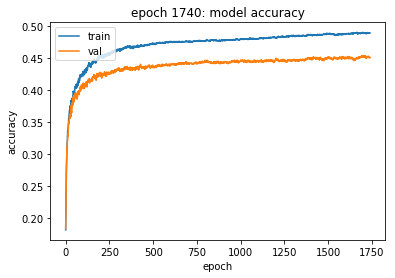



Epoch 1741/2000 ...........
Loss train: 2.2773965797914903 
Loss val: 2.3997791183480266 
Train accuracy :  0.4887 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1742/2000 ...........
Loss train: 2.2779024895682944 
Loss val: 2.40094551746894 
Train accuracy :  0.489775 
Validation accuracy :  0.4521
Alpha:  0.2


Epoch 1743/2000 ...........
Loss train: 2.2779897399475804 
Loss val: 2.4018796558120887 
Train accuracy :  0.48905 
Validation accuracy :  0.4523
Alpha:  0.2


Epoch 1744/2000 ...........
Loss train: 2.2776733090975148 
Loss val: 2.401417154369605 
Train accuracy :  0.488625 
Validation accuracy :  0.4521
Alpha:  0.2


Epoch 1745/2000 ...........
Loss train: 2.2773741756670636 
Loss val: 2.4005746081662105 
Train accuracy :  0.488 
Validation accuracy :  0.4506
Alpha:  0.2


Epoch 1746/2000 ...........
Loss train: 2.277151780380355 
Loss val: 2.3999144316370207 
Train accuracy :  0.48875 
Validation accuracy :  0.4504
Alpha:  0.2


Epoch 1747/2000 ...........
Loss trai

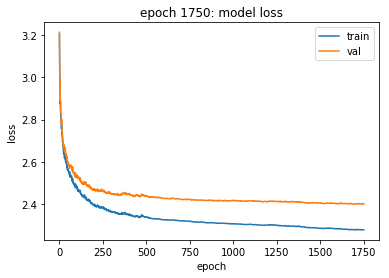

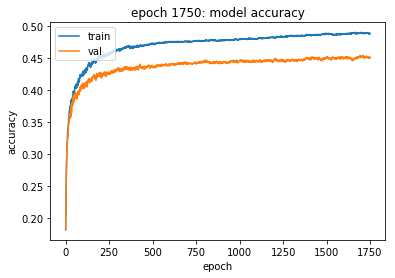



Epoch 1751/2000 ...........
Loss train: 2.277933786956362 
Loss val: 2.4005774127116384 
Train accuracy :  0.48965 
Validation accuracy :  0.4513
Alpha:  0.2


Epoch 1752/2000 ...........
Loss train: 2.27706347126209 
Loss val: 2.400221004329883 
Train accuracy :  0.490075 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1753/2000 ...........
Loss train: 2.2768486117619835 
Loss val: 2.400211945180776 
Train accuracy :  0.489525 
Validation accuracy :  0.4498
Alpha:  0.2


Epoch 1754/2000 ...........
Loss train: 2.2770838093519483 
Loss val: 2.3999735604233714 
Train accuracy :  0.489025 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1755/2000 ...........
Loss train: 2.2776282488033712 
Loss val: 2.4000793995266676 
Train accuracy :  0.48925 
Validation accuracy :  0.451
Alpha:  0.2


Epoch 1756/2000 ...........
Loss train: 2.2771250842875923 
Loss val: 2.399579620976361 
Train accuracy :  0.4898 
Validation accuracy :  0.4511
Alpha:  0.2


Epoch 1757/2000 ...........
Loss trai

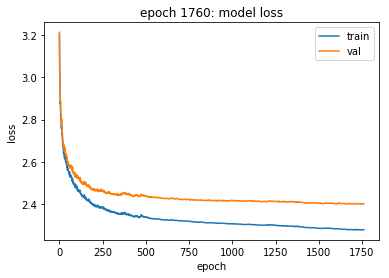

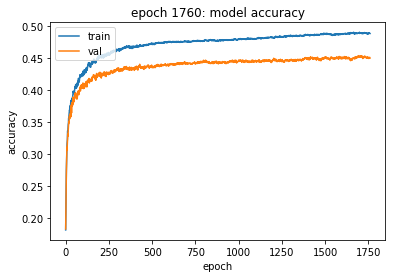



Epoch 1761/2000 ...........
Loss train: 2.276940186471118 
Loss val: 2.3998713566220142 
Train accuracy :  0.489375 
Validation accuracy :  0.45
Alpha:  0.2


Epoch 1762/2000 ...........
Loss train: 2.276380876452587 
Loss val: 2.399266181075679 
Train accuracy :  0.49015 
Validation accuracy :  0.4497
Alpha:  0.2


Epoch 1763/2000 ...........
Loss train: 2.276266521258162 
Loss val: 2.39952888619897 
Train accuracy :  0.49015 
Validation accuracy :  0.4493
Alpha:  0.2


Epoch 1764/2000 ...........
Loss train: 2.2763627808085856 
Loss val: 2.399381592385279 
Train accuracy :  0.4894 
Validation accuracy :  0.4496
Alpha:  0.2


Epoch 1765/2000 ...........
Loss train: 2.276662235014265 
Loss val: 2.3993679769992284 
Train accuracy :  0.489575 
Validation accuracy :  0.4523
Alpha:  0.2


Epoch 1766/2000 ...........
Loss train: 2.276503401054612 
Loss val: 2.3994908168413445 
Train accuracy :  0.489 
Validation accuracy :  0.4507
Alpha:  0.2


Epoch 1767/2000 ...........
Loss train: 2.27

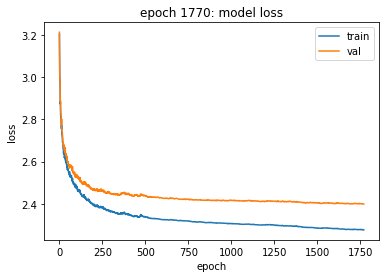

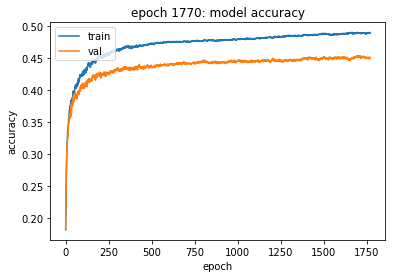



Epoch 1771/2000 ...........
Loss train: 2.276036011381347 
Loss val: 2.398848183596321 
Train accuracy :  0.48995 
Validation accuracy :  0.451
Alpha:  0.2


Epoch 1772/2000 ...........
Loss train: 2.2762107848653583 
Loss val: 2.3989023135685095 
Train accuracy :  0.490575 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1773/2000 ...........
Loss train: 2.276469997823973 
Loss val: 2.400345297398745 
Train accuracy :  0.490475 
Validation accuracy :  0.4496
Alpha:  0.2


Epoch 1774/2000 ...........
Loss train: 2.2759659929775444 
Loss val: 2.3999589214197443 
Train accuracy :  0.489775 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1775/2000 ...........
Loss train: 2.275837405294789 
Loss val: 2.400233479793217 
Train accuracy :  0.4907 
Validation accuracy :  0.4501
Alpha:  0.2


Epoch 1776/2000 ...........
Loss train: 2.276191202161853 
Loss val: 2.400028196672469 
Train accuracy :  0.490875 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1777/2000 ...........
Loss train

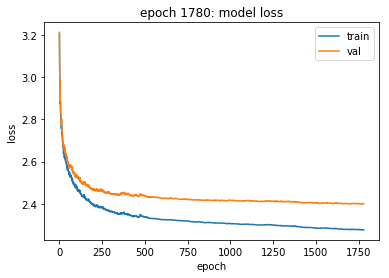

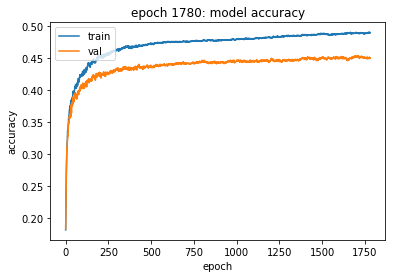



Epoch 1781/2000 ...........
Loss train: 2.2768469716774247 
Loss val: 2.4008264725084487 
Train accuracy :  0.4901 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1782/2000 ...........
Loss train: 2.2759796635997174 
Loss val: 2.400408121042483 
Train accuracy :  0.4907 
Validation accuracy :  0.4494
Alpha:  0.2


Epoch 1783/2000 ...........
Loss train: 2.276143159656848 
Loss val: 2.3998090396542953 
Train accuracy :  0.4908 
Validation accuracy :  0.4516
Alpha:  0.2


Epoch 1784/2000 ...........
Loss train: 2.276128856021078 
Loss val: 2.400068276019372 
Train accuracy :  0.489625 
Validation accuracy :  0.4517
Alpha:  0.2


Epoch 1785/2000 ...........
Loss train: 2.275078456306113 
Loss val: 2.3984366155400485 
Train accuracy :  0.49 
Validation accuracy :  0.4508
Alpha:  0.2


Epoch 1786/2000 ...........
Loss train: 2.2746573807193737 
Loss val: 2.3983046971388386 
Train accuracy :  0.49055 
Validation accuracy :  0.4499
Alpha:  0.2


Epoch 1787/2000 ...........
Loss train: 2.

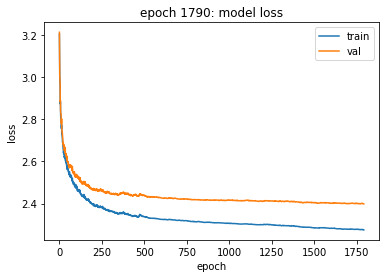

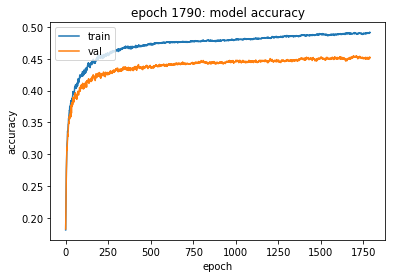



Epoch 1791/2000 ...........
Loss train: 2.274630119466799 
Loss val: 2.3982087125699945 
Train accuracy :  0.489325 
Validation accuracy :  0.449
Alpha:  0.2


Epoch 1792/2000 ...........
Loss train: 2.274306785833682 
Loss val: 2.3975155371238985 
Train accuracy :  0.49065 
Validation accuracy :  0.4514
Alpha:  0.2


Epoch 1793/2000 ...........
Loss train: 2.274036208952422 
Loss val: 2.3974590643519367 
Train accuracy :  0.49035 
Validation accuracy :  0.4494
Alpha:  0.2


Epoch 1794/2000 ...........
Loss train: 2.273983572174297 
Loss val: 2.3971355484691865 
Train accuracy :  0.4908 
Validation accuracy :  0.4512
Alpha:  0.2


Epoch 1795/2000 ...........
Loss train: 2.274185042170291 
Loss val: 2.397053321157141 
Train accuracy :  0.491275 
Validation accuracy :  0.452
Alpha:  0.2


Epoch 1796/2000 ...........
Loss train: 2.274317334692851 
Loss val: 2.3966986265214985 
Train accuracy :  0.4911 
Validation accuracy :  0.4506
Alpha:  0.2


Epoch 1797/2000 ...........
Loss train: 2

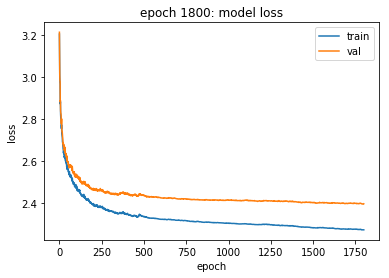

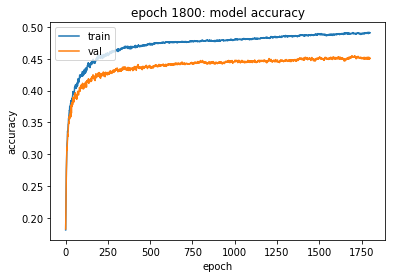



Epoch 1801/2000 ...........
Loss train: 2.2738616691251217 
Loss val: 2.3971790038581386 
Train accuracy :  0.490875 
Validation accuracy :  0.4505
Alpha:  0.2


Epoch 1802/2000 ...........
Loss train: 2.2741277986439035 
Loss val: 2.397501157166847 
Train accuracy :  0.490525 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1803/2000 ...........
Loss train: 2.2738066466412907 
Loss val: 2.3965712283679794 
Train accuracy :  0.491625 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1804/2000 ...........
Loss train: 2.2739139106824604 
Loss val: 2.396926459958809 
Train accuracy :  0.491425 
Validation accuracy :  0.4501
Alpha:  0.2


Epoch 1805/2000 ...........
Loss train: 2.273895102742314 
Loss val: 2.3970705695062384 
Train accuracy :  0.491025 
Validation accuracy :  0.4503
Alpha:  0.2


Epoch 1806/2000 ...........
Loss train: 2.274355670978033 
Loss val: 2.3973230839109854 
Train accuracy :  0.490975 
Validation accuracy :  0.452
Alpha:  0.2


Epoch 1807/2000 ...........
Los

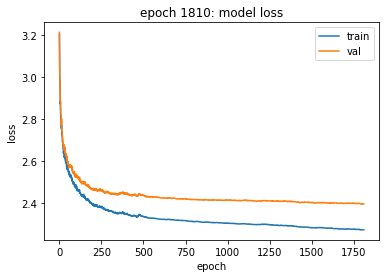

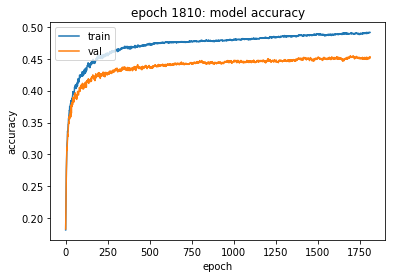



Epoch 1811/2000 ...........
Loss train: 2.2742413973285216 
Loss val: 2.3974708592291836 
Train accuracy :  0.490625 
Validation accuracy :  0.45
Alpha:  0.2


Epoch 1812/2000 ...........
Loss train: 2.274930577867608 
Loss val: 2.3979344462794123 
Train accuracy :  0.4902 
Validation accuracy :  0.4502
Alpha:  0.2


Epoch 1813/2000 ...........
Loss train: 2.2745462684146265 
Loss val: 2.397768529089271 
Train accuracy :  0.4913 
Validation accuracy :  0.4518
Alpha:  0.2


Epoch 1814/2000 ...........
Loss train: 2.274834825778614 
Loss val: 2.398191339749719 
Train accuracy :  0.491275 
Validation accuracy :  0.4539
Alpha:  0.2


Epoch 1815/2000 ...........
Loss train: 2.2742868016175812 
Loss val: 2.3972988328665115 
Train accuracy :  0.490925 
Validation accuracy :  0.4529
Alpha:  0.2


Epoch 1816/2000 ...........
Loss train: 2.2736325002304105 
Loss val: 2.397001620080903 
Train accuracy :  0.491525 
Validation accuracy :  0.4525
Alpha:  0.2


Epoch 1817/2000 ...........
Loss trai

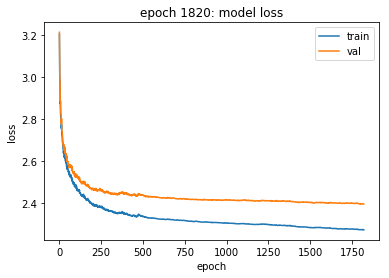

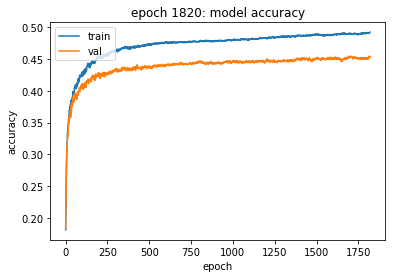



Epoch 1821/2000 ...........
Loss train: 2.27335890065854 
Loss val: 2.396032353849332 
Train accuracy :  0.49165 
Validation accuracy :  0.4551
Alpha:  0.2


Epoch 1822/2000 ...........
Loss train: 2.2737399684609914 
Loss val: 2.3957626272231862 
Train accuracy :  0.491425 
Validation accuracy :  0.4546
Alpha:  0.2


Epoch 1823/2000 ...........
Loss train: 2.273466182226477 
Loss val: 2.39609862364184 
Train accuracy :  0.4909 
Validation accuracy :  0.4558
Alpha:  0.2


Epoch 1824/2000 ...........
Loss train: 2.273167932003656 
Loss val: 2.396457488719671 
Train accuracy :  0.491225 
Validation accuracy :  0.4538
Alpha:  0.2


Epoch 1825/2000 ...........
Loss train: 2.2732525905507086 
Loss val: 2.3962059509207485 
Train accuracy :  0.4918 
Validation accuracy :  0.4546
Alpha:  0.2


Epoch 1826/2000 ...........
Loss train: 2.2731896219247885 
Loss val: 2.3959814251648615 
Train accuracy :  0.491775 
Validation accuracy :  0.4535
Alpha:  0.2


Epoch 1827/2000 ...........
Loss train:

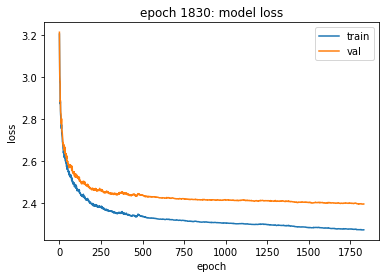

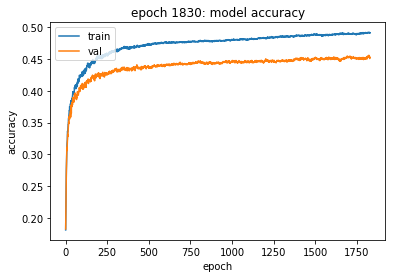



Epoch 1831/2000 ...........
Loss train: 2.2736863195007424 
Loss val: 2.397087286882411 
Train accuracy :  0.490875 
Validation accuracy :  0.4534
Alpha:  0.2


Epoch 1832/2000 ...........
Loss train: 2.2741901354720158 
Loss val: 2.3974721677872783 
Train accuracy :  0.490925 
Validation accuracy :  0.4531
Alpha:  0.2


Epoch 1833/2000 ...........
Loss train: 2.2740555173719526 
Loss val: 2.3972161383867783 
Train accuracy :  0.4908 
Validation accuracy :  0.4521
Alpha:  0.2


Epoch 1834/2000 ...........
Loss train: 2.2734532028192698 
Loss val: 2.395456926970127 
Train accuracy :  0.49215 
Validation accuracy :  0.4523
Alpha:  0.2


Epoch 1835/2000 ...........
Loss train: 2.2734026272644785 
Loss val: 2.3957053768565584 
Train accuracy :  0.4913 
Validation accuracy :  0.4525
Alpha:  0.2


Epoch 1836/2000 ...........
Loss train: 2.273043000592649 
Loss val: 2.394542202617062 
Train accuracy :  0.49155 
Validation accuracy :  0.4533
Alpha:  0.2


Epoch 1837/2000 ...........
Loss tra

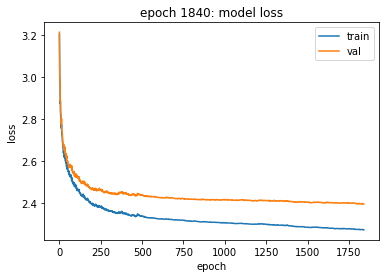

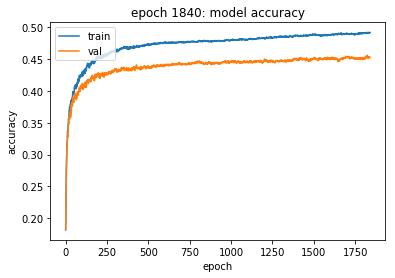



Epoch 1841/2000 ...........
Loss train: 2.272237442282793 
Loss val: 2.3951512487093045 
Train accuracy :  0.491425 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1842/2000 ...........
Loss train: 2.271965285942765 
Loss val: 2.3947018522127137 
Train accuracy :  0.49145 
Validation accuracy :  0.4525
Alpha:  0.2


Epoch 1843/2000 ...........
Loss train: 2.272010029494556 
Loss val: 2.394084566626177 
Train accuracy :  0.491725 
Validation accuracy :  0.4529
Alpha:  0.2


Epoch 1844/2000 ...........
Loss train: 2.2719664785125855 
Loss val: 2.3944662191389785 
Train accuracy :  0.4918 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1845/2000 ...........
Loss train: 2.272177149857662 
Loss val: 2.394300485461371 
Train accuracy :  0.4918 
Validation accuracy :  0.4546
Alpha:  0.2


Epoch 1846/2000 ...........
Loss train: 2.2722779982910595 
Loss val: 2.3944557911211994 
Train accuracy :  0.490675 
Validation accuracy :  0.4527
Alpha:  0.2


Epoch 1847/2000 ...........
Loss trai

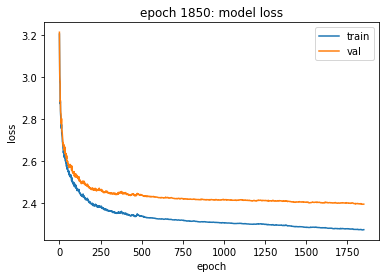

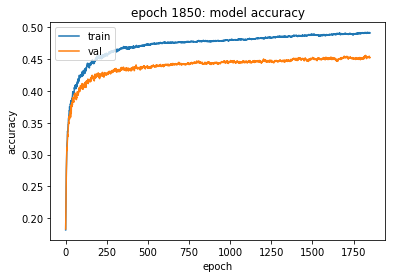



Epoch 1851/2000 ...........
Loss train: 2.2724912356539964 
Loss val: 2.394376425755979 
Train accuracy :  0.490925 
Validation accuracy :  0.4517
Alpha:  0.2


Epoch 1852/2000 ...........
Loss train: 2.272742282044249 
Loss val: 2.3942420832961173 
Train accuracy :  0.490925 
Validation accuracy :  0.4522
Alpha:  0.2


Epoch 1853/2000 ...........
Loss train: 2.2725595313604487 
Loss val: 2.394100991933214 
Train accuracy :  0.491825 
Validation accuracy :  0.4537
Alpha:  0.2


Epoch 1854/2000 ...........
Loss train: 2.273148794312866 
Loss val: 2.3945553302628015 
Train accuracy :  0.49165 
Validation accuracy :  0.4545
Alpha:  0.2


Epoch 1855/2000 ...........
Loss train: 2.2726924008552034 
Loss val: 2.3939353023891745 
Train accuracy :  0.49105 
Validation accuracy :  0.4543
Alpha:  0.2


Epoch 1856/2000 ...........
Loss train: 2.272326913911465 
Loss val: 2.3945586780487202 
Train accuracy :  0.492225 
Validation accuracy :  0.454
Alpha:  0.2


Epoch 1857/2000 ...........
Loss t

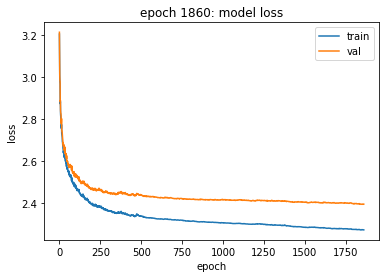

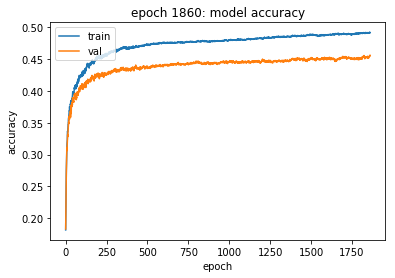



Epoch 1861/2000 ...........
Loss train: 2.272417777415337 
Loss val: 2.394579641666851 
Train accuracy :  0.491875 
Validation accuracy :  0.4552
Alpha:  0.2


Epoch 1862/2000 ...........
Loss train: 2.2722801061611753 
Loss val: 2.3938842597131256 
Train accuracy :  0.492375 
Validation accuracy :  0.4556
Alpha:  0.2


Epoch 1863/2000 ...........
Loss train: 2.273540975718474 
Loss val: 2.394904327050793 
Train accuracy :  0.492625 
Validation accuracy :  0.4544
Alpha:  0.2


Epoch 1864/2000 ...........
Loss train: 2.2738356855661928 
Loss val: 2.3942816081867044 
Train accuracy :  0.492 
Validation accuracy :  0.4566
Alpha:  0.2


Epoch 1865/2000 ...........
Loss train: 2.2731810478029355 
Loss val: 2.3937906664248123 
Train accuracy :  0.49155 
Validation accuracy :  0.4555
Alpha:  0.2


Epoch 1866/2000 ...........
Loss train: 2.2726001826719053 
Loss val: 2.393324044048005 
Train accuracy :  0.491425 
Validation accuracy :  0.4541
Alpha:  0.2


Epoch 1867/2000 ...........
Loss tr

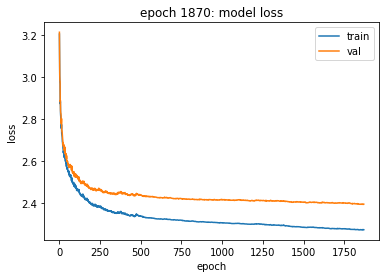

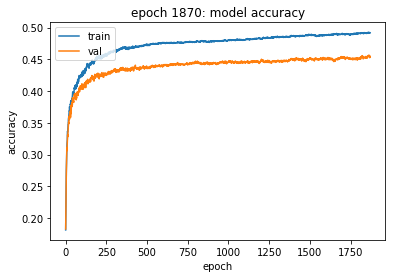



Epoch 1871/2000 ...........
Loss train: 2.273610151438429 
Loss val: 2.395150512965245 
Train accuracy :  0.4917 
Validation accuracy :  0.4561
Alpha:  0.2


Epoch 1872/2000 ...........
Loss train: 2.2736172183251613 
Loss val: 2.3949940661534956 
Train accuracy :  0.491525 
Validation accuracy :  0.4542
Alpha:  0.2


Epoch 1873/2000 ...........
Loss train: 2.2740253945640205 
Loss val: 2.3959282952827845 
Train accuracy :  0.491725 
Validation accuracy :  0.4549
Alpha:  0.2


Epoch 1874/2000 ...........
Loss train: 2.273696886669429 
Loss val: 2.3955454317477556 
Train accuracy :  0.490925 
Validation accuracy :  0.4548
Alpha:  0.2


Epoch 1875/2000 ...........
Loss train: 2.273133432376012 
Loss val: 2.3956425974288234 
Train accuracy :  0.491675 
Validation accuracy :  0.4544
Alpha:  0.2


Epoch 1876/2000 ...........
Loss train: 2.273308069564535 
Loss val: 2.395876092762921 
Train accuracy :  0.491825 
Validation accuracy :  0.4547
Alpha:  0.2


Epoch 1877/2000 ...........
Loss t

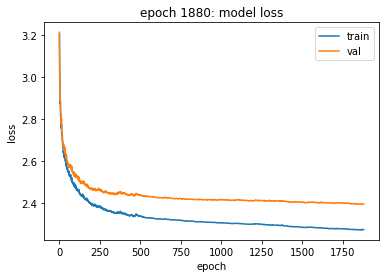

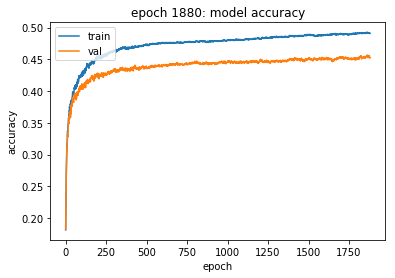



Epoch 1881/2000 ...........
Loss train: 2.273338181455433 
Loss val: 2.3955193651616824 
Train accuracy :  0.49155 
Validation accuracy :  0.453
Alpha:  0.2


Epoch 1882/2000 ...........
Loss train: 2.2735507518793074 
Loss val: 2.3951008674665357 
Train accuracy :  0.492075 
Validation accuracy :  0.452
Alpha:  0.2


Epoch 1883/2000 ...........
Loss train: 2.2729362178662393 
Loss val: 2.3943572680474188 
Train accuracy :  0.492075 
Validation accuracy :  0.4532
Alpha:  0.2


Epoch 1884/2000 ...........
Loss train: 2.2730149709299896 
Loss val: 2.3943362523515384 
Train accuracy :  0.491125 
Validation accuracy :  0.4518
Alpha:  0.2


Epoch 1885/2000 ...........
Loss train: 2.2725666176595207 
Loss val: 2.3947776213026226 
Train accuracy :  0.491 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1886/2000 ...........
Loss train: 2.2727703522015346 
Loss val: 2.395019784544722 
Train accuracy :  0.4921 
Validation accuracy :  0.4513
Alpha:  0.2


Epoch 1887/2000 ...........
Loss tra

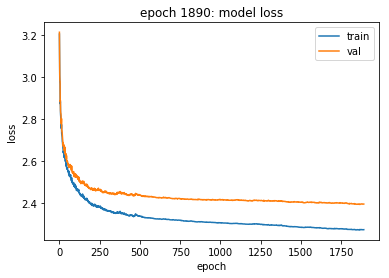

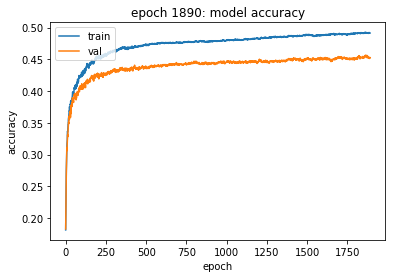



Epoch 1891/2000 ...........
Loss train: 2.27284471590071 
Loss val: 2.394780757557273 
Train accuracy :  0.491275 
Validation accuracy :  0.4536
Alpha:  0.2


Epoch 1892/2000 ...........
Loss train: 2.2725600394588055 
Loss val: 2.3941988894068644 
Train accuracy :  0.491525 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1893/2000 ...........
Loss train: 2.272351174021616 
Loss val: 2.3938159877660627 
Train accuracy :  0.49195 
Validation accuracy :  0.4514
Alpha:  0.2


Epoch 1894/2000 ...........
Loss train: 2.2723987580646607 
Loss val: 2.3940857759013614 
Train accuracy :  0.491675 
Validation accuracy :  0.4534
Alpha:  0.2


Epoch 1895/2000 ...........
Loss train: 2.271767787326157 
Loss val: 2.393978152658708 
Train accuracy :  0.492425 
Validation accuracy :  0.4521
Alpha:  0.2


Epoch 1896/2000 ...........
Loss train: 2.2719632364328066 
Loss val: 2.3943404985785235 
Train accuracy :  0.4921 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1897/2000 ...........
Loss tr

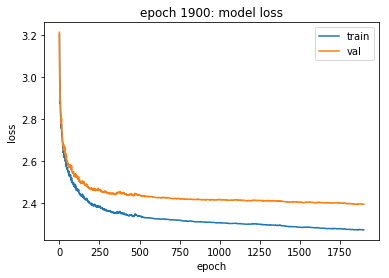

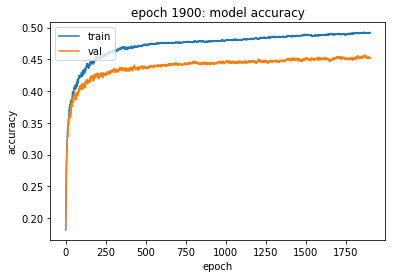



Epoch 1901/2000 ...........
Loss train: 2.2721833388800428 
Loss val: 2.3938680457728156 
Train accuracy :  0.4919 
Validation accuracy :  0.4528
Alpha:  0.2


Epoch 1902/2000 ...........
Loss train: 2.2718819873980607 
Loss val: 2.394180711589494 
Train accuracy :  0.492175 
Validation accuracy :  0.4516
Alpha:  0.2


Epoch 1903/2000 ...........
Loss train: 2.2717615847051125 
Loss val: 2.3946246366717965 
Train accuracy :  0.4915 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1904/2000 ...........
Loss train: 2.272186409388416 
Loss val: 2.3941328087554608 
Train accuracy :  0.4922 
Validation accuracy :  0.4514
Alpha:  0.2


Epoch 1905/2000 ...........
Loss train: 2.2721651250792454 
Loss val: 2.3945777741254184 
Train accuracy :  0.493275 
Validation accuracy :  0.4527
Alpha:  0.2


Epoch 1906/2000 ...........
Loss train: 2.2723654154812523 
Loss val: 2.3945869338965533 
Train accuracy :  0.49195 
Validation accuracy :  0.4543
Alpha:  0.2


Epoch 1907/2000 ...........
Loss tr

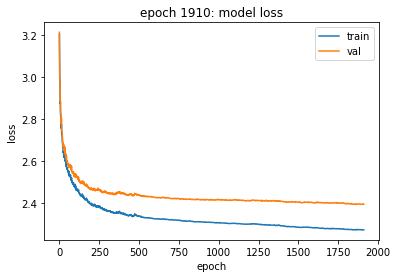

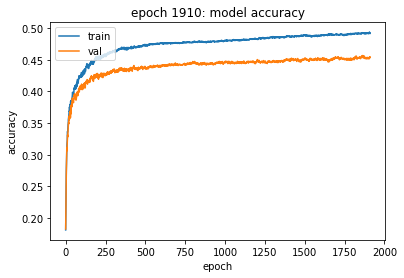



Epoch 1911/2000 ...........
Loss train: 2.2721214334532056 
Loss val: 2.3950760577503423 
Train accuracy :  0.4924 
Validation accuracy :  0.4537
Alpha:  0.2


Epoch 1912/2000 ...........
Loss train: 2.272343634812889 
Loss val: 2.394576718730196 
Train accuracy :  0.49145 
Validation accuracy :  0.4527
Alpha:  0.2


Epoch 1913/2000 ...........
Loss train: 2.2722040654771156 
Loss val: 2.394105730182113 
Train accuracy :  0.49155 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1914/2000 ...........
Loss train: 2.2720921955097877 
Loss val: 2.3945726398710434 
Train accuracy :  0.491225 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1915/2000 ...........
Loss train: 2.2712335135717967 
Loss val: 2.3938949008995807 
Train accuracy :  0.4919 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1916/2000 ...........
Loss train: 2.2710145991696375 
Loss val: 2.3938908789099793 
Train accuracy :  0.492575 
Validation accuracy :  0.4535
Alpha:  0.2


Epoch 1917/2000 ...........
Loss tr

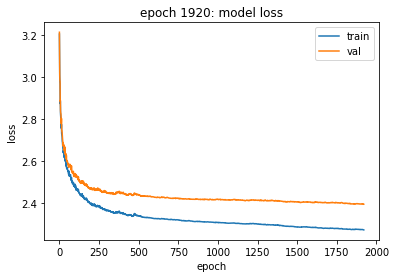

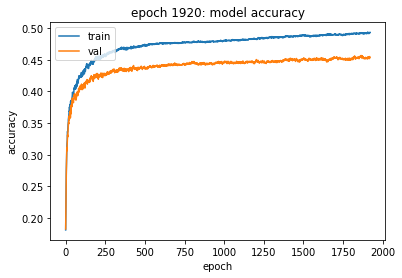



Epoch 1921/2000 ...........
Loss train: 2.270599131266372 
Loss val: 2.3932531296272743 
Train accuracy :  0.492775 
Validation accuracy :  0.4564
Alpha:  0.2


Epoch 1922/2000 ...........
Loss train: 2.270249111819651 
Loss val: 2.3930461681371717 
Train accuracy :  0.492625 
Validation accuracy :  0.4553
Alpha:  0.2


Epoch 1923/2000 ...........
Loss train: 2.2705519154506715 
Loss val: 2.393621058871188 
Train accuracy :  0.492725 
Validation accuracy :  0.4555
Alpha:  0.2


Epoch 1924/2000 ...........
Loss train: 2.2705032207457116 
Loss val: 2.3939965410342237 
Train accuracy :  0.49225 
Validation accuracy :  0.4547
Alpha:  0.2


Epoch 1925/2000 ...........
Loss train: 2.270172192376323 
Loss val: 2.39327702149784 
Train accuracy :  0.492075 
Validation accuracy :  0.4552
Alpha:  0.2


Epoch 1926/2000 ...........
Loss train: 2.269980790077656 
Loss val: 2.3932433557199895 
Train accuracy :  0.4918 
Validation accuracy :  0.4552
Alpha:  0.2


Epoch 1927/2000 ...........
Loss tra

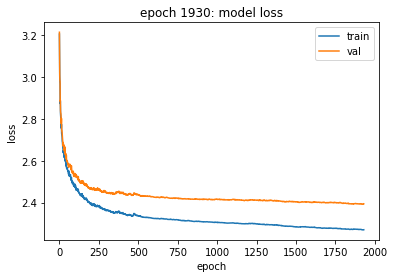

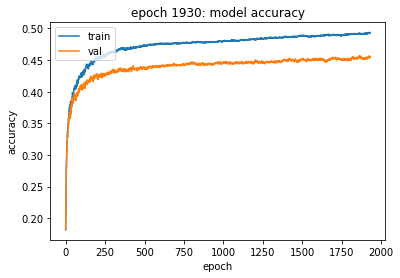



Epoch 1931/2000 ...........
Loss train: 2.271092910400145 
Loss val: 2.395137478421364 
Train accuracy :  0.492525 
Validation accuracy :  0.4534
Alpha:  0.2


Epoch 1932/2000 ...........
Loss train: 2.27058255326864 
Loss val: 2.3944549888625963 
Train accuracy :  0.492775 
Validation accuracy :  0.4548
Alpha:  0.2


Epoch 1933/2000 ...........
Loss train: 2.2704963592149126 
Loss val: 2.393872097801509 
Train accuracy :  0.4931 
Validation accuracy :  0.4556
Alpha:  0.2


Epoch 1934/2000 ...........
Loss train: 2.2704402039224245 
Loss val: 2.3937514909616193 
Train accuracy :  0.49305 
Validation accuracy :  0.4557
Alpha:  0.2


Epoch 1935/2000 ...........
Loss train: 2.2704335626744863 
Loss val: 2.3938948963338613 
Train accuracy :  0.492725 
Validation accuracy :  0.4564
Alpha:  0.2


Epoch 1936/2000 ...........
Loss train: 2.270649096615991 
Loss val: 2.394089984094873 
Train accuracy :  0.492125 
Validation accuracy :  0.4562
Alpha:  0.2


Epoch 1937/2000 ...........
Loss tra

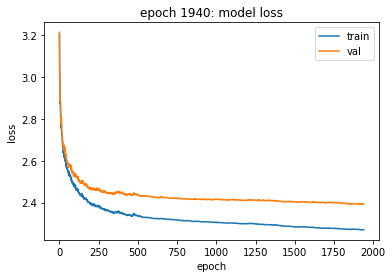

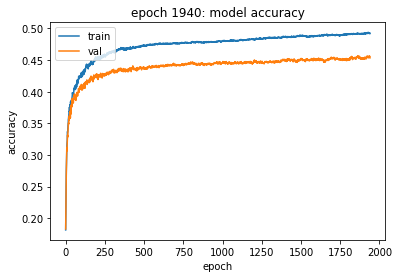



Epoch 1941/2000 ...........
Loss train: 2.2711336099354025 
Loss val: 2.394365096895911 
Train accuracy :  0.492725 
Validation accuracy :  0.4554
Alpha:  0.2


Epoch 1942/2000 ...........
Loss train: 2.2709929556164696 
Loss val: 2.3941526881826016 
Train accuracy :  0.492975 
Validation accuracy :  0.4564
Alpha:  0.2


Epoch 1943/2000 ...........
Loss train: 2.2711861681365075 
Loss val: 2.3945841089431696 
Train accuracy :  0.4922 
Validation accuracy :  0.4546
Alpha:  0.2


Epoch 1944/2000 ...........
Loss train: 2.2712191434536986 
Loss val: 2.3942684719363054 
Train accuracy :  0.492025 
Validation accuracy :  0.4554
Alpha:  0.2


Epoch 1945/2000 ...........
Loss train: 2.2710424235230846 
Loss val: 2.393525120633144 
Train accuracy :  0.49305 
Validation accuracy :  0.4553
Alpha:  0.2


Epoch 1946/2000 ...........
Loss train: 2.2705500941042587 
Loss val: 2.393255794896491 
Train accuracy :  0.493325 
Validation accuracy :  0.4562
Alpha:  0.2


Epoch 1947/2000 ...........
Loss

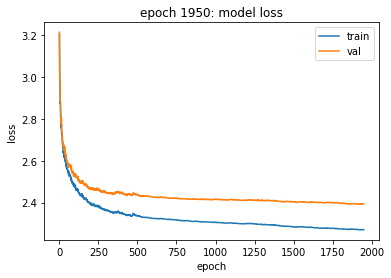

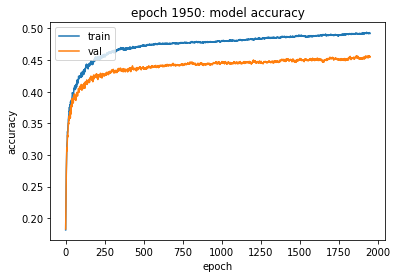



Epoch 1951/2000 ...........
Loss train: 2.2706094850056457 
Loss val: 2.3944419044604803 
Train accuracy :  0.492575 
Validation accuracy :  0.4545
Alpha:  0.2


Epoch 1952/2000 ...........
Loss train: 2.2707237470548085 
Loss val: 2.393948565482489 
Train accuracy :  0.492075 
Validation accuracy :  0.4552
Alpha:  0.2


Epoch 1953/2000 ...........
Loss train: 2.2706619484593866 
Loss val: 2.3942600178863684 
Train accuracy :  0.492175 
Validation accuracy :  0.4533
Alpha:  0.2


Epoch 1954/2000 ...........
Loss train: 2.2706307697081125 
Loss val: 2.3937572007971104 
Train accuracy :  0.492525 
Validation accuracy :  0.4546
Alpha:  0.2


Epoch 1955/2000 ...........
Loss train: 2.2708316237808135 
Loss val: 2.3942670749380124 
Train accuracy :  0.49165 
Validation accuracy :  0.4551
Alpha:  0.2


Epoch 1956/2000 ...........
Loss train: 2.270829535562115 
Loss val: 2.394273348861042 
Train accuracy :  0.492075 
Validation accuracy :  0.4553
Alpha:  0.2


Epoch 1957/2000 ...........
Lo

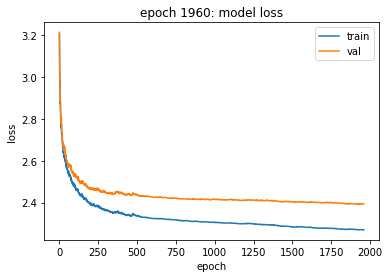

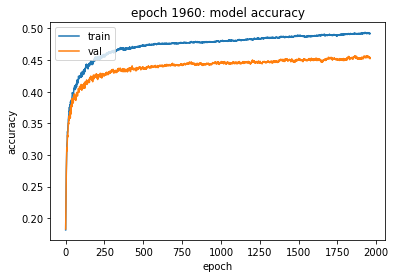



Epoch 1961/2000 ...........
Loss train: 2.2705588542095265 
Loss val: 2.394707616660203 
Train accuracy :  0.4921 
Validation accuracy :  0.4542
Alpha:  0.2


Epoch 1962/2000 ...........
Loss train: 2.271463411089825 
Loss val: 2.3960516889795778 
Train accuracy :  0.49175 
Validation accuracy :  0.4543
Alpha:  0.2


Epoch 1963/2000 ...........
Loss train: 2.2715688754641428 
Loss val: 2.396982100391799 
Train accuracy :  0.492525 
Validation accuracy :  0.4547
Alpha:  0.2


Epoch 1964/2000 ...........
Loss train: 2.270698806456162 
Loss val: 2.395660087107668 
Train accuracy :  0.49185 
Validation accuracy :  0.4543
Alpha:  0.2


Epoch 1965/2000 ...........
Loss train: 2.2703266304548806 
Loss val: 2.3953690914779564 
Train accuracy :  0.4917 
Validation accuracy :  0.4539
Alpha:  0.2


Epoch 1966/2000 ...........
Loss train: 2.2709245443867827 
Loss val: 2.3960329222229655 
Train accuracy :  0.492 
Validation accuracy :  0.4549
Alpha:  0.2


Epoch 1967/2000 ...........
Loss train: 

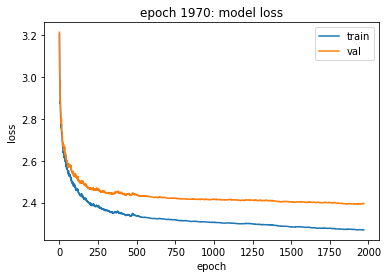

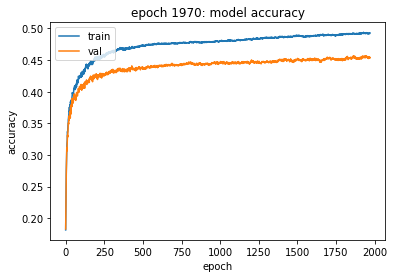



Epoch 1971/2000 ...........
Loss train: 2.271395920834539 
Loss val: 2.39669821467656 
Train accuracy :  0.49175 
Validation accuracy :  0.4519
Alpha:  0.2


Epoch 1972/2000 ...........
Loss train: 2.2716839543567717 
Loss val: 2.3969332829617946 
Train accuracy :  0.49205 
Validation accuracy :  0.4534
Alpha:  0.2


Epoch 1973/2000 ...........
Loss train: 2.271018439220954 
Loss val: 2.3960468901413465 
Train accuracy :  0.491125 
Validation accuracy :  0.4527
Alpha:  0.2


Epoch 1974/2000 ...........
Loss train: 2.2707552867567555 
Loss val: 2.3957657363062497 
Train accuracy :  0.491275 
Validation accuracy :  0.454
Alpha:  0.2


Epoch 1975/2000 ...........
Loss train: 2.270701805222771 
Loss val: 2.3965044749894497 
Train accuracy :  0.4916 
Validation accuracy :  0.4537
Alpha:  0.2


Epoch 1976/2000 ...........
Loss train: 2.270129618697502 
Loss val: 2.3959069707713585 
Train accuracy :  0.492275 
Validation accuracy :  0.4551
Alpha:  0.2


Epoch 1977/2000 ...........
Loss trai

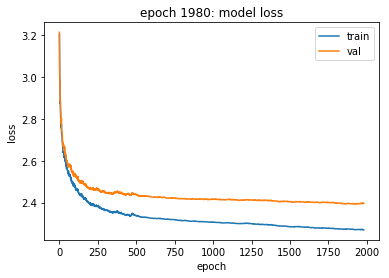

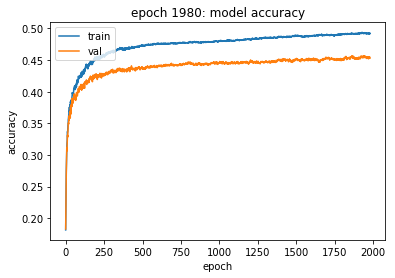



Epoch 1981/2000 ...........
Loss train: 2.2690052896420214 
Loss val: 2.3953033016249003 
Train accuracy :  0.49225 
Validation accuracy :  0.4547
Alpha:  0.2


Epoch 1982/2000 ...........
Loss train: 2.26898261494463 
Loss val: 2.39510764421175 
Train accuracy :  0.492225 
Validation accuracy :  0.455
Alpha:  0.2


Epoch 1983/2000 ...........
Loss train: 2.2687412853667817 
Loss val: 2.395255339751051 
Train accuracy :  0.49275 
Validation accuracy :  0.4527
Alpha:  0.2


Epoch 1984/2000 ...........
Loss train: 2.268984496129738 
Loss val: 2.394409948434414 
Train accuracy :  0.492725 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1985/2000 ...........
Loss train: 2.269524984373538 
Loss val: 2.395286543387156 
Train accuracy :  0.492425 
Validation accuracy :  0.4542
Alpha:  0.2


Epoch 1986/2000 ...........
Loss train: 2.26969161875672 
Loss val: 2.3947561112178586 
Train accuracy :  0.492225 
Validation accuracy :  0.4543
Alpha:  0.2


Epoch 1987/2000 ...........
Loss train: 

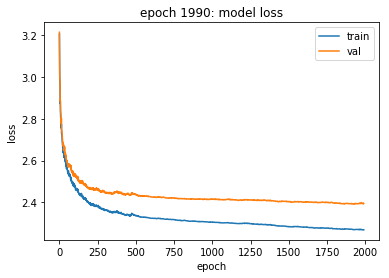

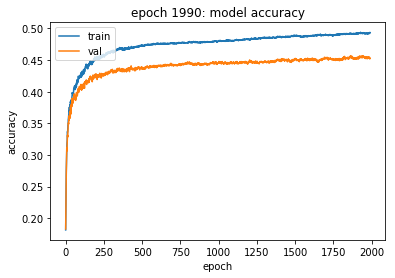



Epoch 1991/2000 ...........
Loss train: 2.269076991964757 
Loss val: 2.3946986066401577 
Train accuracy :  0.49275 
Validation accuracy :  0.4527
Alpha:  0.2


Epoch 1992/2000 ...........
Loss train: 2.2690700770429206 
Loss val: 2.395256894822636 
Train accuracy :  0.49315 
Validation accuracy :  0.4515
Alpha:  0.2


Epoch 1993/2000 ...........
Loss train: 2.269116819205546 
Loss val: 2.3946198973246604 
Train accuracy :  0.493975 
Validation accuracy :  0.4537
Alpha:  0.2


Epoch 1994/2000 ...........
Loss train: 2.2690243723302546 
Loss val: 2.3947915588032758 
Train accuracy :  0.494425 
Validation accuracy :  0.4528
Alpha:  0.2


Epoch 1995/2000 ...........
Loss train: 2.2689913123725334 
Loss val: 2.394948845955678 
Train accuracy :  0.49335 
Validation accuracy :  0.4526
Alpha:  0.2


Epoch 1996/2000 ...........
Loss train: 2.2690132715774793 
Loss val: 2.395370178979727 
Train accuracy :  0.492325 
Validation accuracy :  0.4538
Alpha:  0.2


Epoch 1997/2000 ...........
Loss t

In [23]:
batch_size = 1000
dropout_prob = 0.5
num_epochs = 2000
alpha = 4
#np.random.seed(0)
history_loss_train,history_loss_val, history_acc_train, history_acc_val = [],[],[],[]
num_train_samples = x_train.shape[0]
num_batches = num_train_samples // batch_size
layers_size = [3072, 256, 64, 10]
thetas = np.asarray([np.random.randn(layers_size[i], layers_size[i+1]) for i in range(0, len(layers_size)-1)])
y_pred = forward(thetas, x_train,dropout_prob, False)
loss_val = loss(y_train, y_pred[-1])
print("Initial loss :", loss_val)
Et = np.asarray([np.zeros(th.shape) for th in thetas])
for i in range(0, num_epochs):
    p = np.random.permutation(num_train_samples)
    print('\n\nEpoch %d/%d ' % (i, num_epochs), end='.')
    for batch_no in range(0, num_batches):
        if np.mod(batch_no, num_batches // 10) == 0:
            print('.', end='')
            sys.stdout.flush()
        
        x_train_batch = x_train[p[batch_no * batch_size : (batch_no + 1) * batch_size], :]
        y_train_batch = y_train[p[batch_no * batch_size: (batch_no + 1) * batch_size]]
        d_theta = backward(x_train_batch, y_train_batch, thetas,dropout_prob)
        
        for j in range(0,len(d_theta)):
            Et[j] = RMSprob(Et[j], d_theta[j], 0.9, alpha, 1)
            #thetas[j] =thetas[j] - alpha*d_theta[j] #Обычный mini-batch BackProp
            thetas[j] =thetas[j] - Et[j] 
  
    #loss train
    pred_train_probs = forward(thetas, x_train,dropout_prob, False)
    y_train_out = pred_train_probs[-1]
    loss_train = loss(y_train,  y_train_out)
    history_loss_train.append(loss_train)
    
    #loss val
    pred_val_probs = forward(thetas, x_val,dropout_prob, False)
    y_val_out = pred_val_probs[-1]
    loss_val = loss(y_val, y_val_out)
    history_loss_val.append(loss_val)
    
    history_acc_train.append(acc(y_train, y_train_out))
    history_acc_val.append(acc(y_val, y_val_out))
    print("\nLoss train:", loss_train,
          "\nLoss val:", loss_val,
          "\nTrain accuracy : ",acc(y_train, y_train_out),
          "\nValidation accuracy : ", acc(y_val, y_val_out))
    print("Alpha: ", alpha)
    alpha = max(0.2, alpha * 0.995)#изменение шага градиента (сначала идем большими, постепенно уменьшая)
    if (np.mod(i, num_epochs // (num_epochs/10)) == 0) and i != 0:#каждые 10 выводим на экран
        plt.plot(history_loss_train)
        plt.plot(history_loss_val)
        plt.title(f'epoch {i}: model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

        plt.plot(history_acc_train)
        plt.plot(history_acc_val)
        plt.title(f'epoch {i}: model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


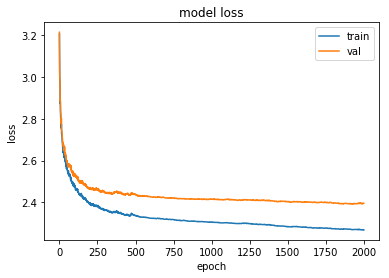

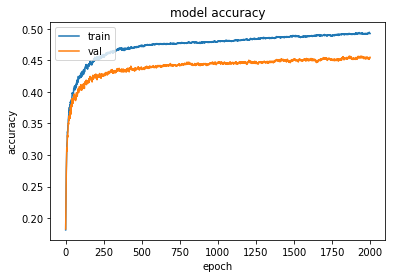

In [24]:
plt.plot(history_loss_train)
plt.plot(history_loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history_acc_train)
plt.plot(history_acc_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
pred_test_probs = forward(thetas, x_test,dropout_prob, False)
y_test_out = pred_test_probs[-1]
loss_test = loss(y_test, y_test_out)
print("\nLoss test:", loss_test,
          "\nTest accuracy : ",acc(y_test, y_test_out))


Loss test: 2.3686704153778644 
Test accuracy :  0.4669


In [26]:
import pickle
pickle.dump(thetas, open('weights\\thetasTwoHidLay256-64_RSMprob_2000epochs.pkl', 'wb'))

In [27]:
f = open('results_Khayrkina5710M.txt','w')
for y in y_test_out:
    f.write(str(np.argmax(y))+'\n')
f.close()